# Unsupervised concept drift detectors: SyncStream & SCD



In [1]:
import pandas as pd
from scipy.io import arff
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from category_encoders import TargetEncoder

import numpy as np
import math
from sklearn.decomposition import PCA
from scipy.stats import rankdata, norm, gaussian_kde
from sklearn.utils import resample
from statistics import variance

import matplotlib.pyplot as plt
from time import time

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

import sklearn
import category_encoders
import scipy

print(sklearn.__version__)
print(category_encoders.__version__)
print(scipy.__version__)

1.0.2
2.5.1.post0
1.9.1


### Reading the SEA dataset

In [2]:
def read_sea(filename):
    data, meta = arff.loadarff(filename)
    df = pd.DataFrame(data)
#     df = df.iloc[54450:55450,:] # For testing SCD with miniature scale
    
    X = df[["attrib1", "attrib2", "attrib3"]]
    
    X_train, X_test = train_test_split(X, train_size=0.30, shuffle=False)
    
    return X_train, X_test

### Reading the AGRAW dataset

In [3]:
def read_agraw(filename):
    data, meta = arff.loadarff(filename)
    df = pd.DataFrame(data)

    le = LabelEncoder()
#     te = TargetEncoder(cols=["elevel", "car", "zipcode"], smoothing=0, return_df=False)
#     ohe = OneHotEncoder()
#     oe = OrdinalEncoder()

    X = df.drop(columns=["class"])
    y = le.fit_transform(df["class"].str.decode("utf-8"))

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.30, shuffle=False)

#     encoder = 'target'
    
#     if encoder == 'onehot':
#         # OneHotEncoder
#         X_train_num = X_train.drop(columns=["elevel", "car", "zipcode"])
#         X_train_cat = X_train[["elevel", "car", "zipcode"]]
#         X_train_cat = ohe.fit_transform(X_train_cat).toarray()
#         X_train = np.concatenate([X_train_num, X_train_cat], axis=1)
#         X_test_num = X_test.drop(columns=["elevel", "car", "zipcode"])
#         X_test_cat = X_test[["elevel", "car", "zipcode"]]
#         X_test_cat = ohe.transform(X_test_cat).toarray()
#         X_test = np.concatenate([X_test_num, X_test_cat], axis=1)
#     elif encoder == 'ordinal':
#         # OrdinalEncoder
#         X_train_num = X_train.drop(columns=["elevel", "car", "zipcode"])
#         X_train_cat = X_train[["elevel", "car", "zipcode"]]
#         X_train_cat = oe.fit_transform(X_train_cat)
#         X_train = np.concatenate([X_train_num, X_train_cat], axis=1)
#         X_test_num = X_test.drop(columns=["elevel", "car", "zipcode"])
#         X_test_cat = X_test[["elevel", "car", "zipcode"]]
#         X_test_cat = oe.transform(X_test_cat)
#         X_test = np.concatenate([X_test_num, X_test_cat], axis=1)
#     elif encoder == 'target':
#         # TargetEncoder
#         X_train = te.fit_transform(X_train, y_train)
#         X_test = te.transform(X_test)
    
    return X_train, X_test, y_train, y_test

### Preprocessing

In [4]:
# def preprocess(X_train, X_test, total_batches):
#     scaler = MinMaxScaler()

#     X_train = pd.DataFrame(scaler.fit_transform(X_train))
#     X_test = pd.DataFrame(scaler.transform(X_test))

#     X_test_batches = np.array_split(X_test, total_batches)

#     return X_train, X_test_batches

def ensure_df(data):
    checked_data = data
    if not isinstance(data, pd.DataFrame):
        checked_data = pd.DataFrame(data)
    return checked_data

def encode(ref_data, test_batches, ref_labels, encoder=None):
    encoded_ref_data = ref_data
    encoded_test_batches = test_batches
    
    if encoder == 'onehot':
        # OneHotEncoder
        ohe = OneHotEncoder()
        ref_data_num = ref_data.select_dtypes(include=[np.number])
        ref_data_cat = ref_data.select_dtypes(exclude=[np.number])
        encoded_ref_data_cat = ohe.fit_transform(ref_data_cat).toarray()
        encoded_ref_data = pd.DataFrame(np.concatenate([ref_data_num, encoded_ref_data_cat], axis=1))
        encoded_test_batches = []
        for batch in range(len(test_batches)):
            test_data_num = test_batches[batch].select_dtypes(include=[np.number])
            test_data_cat = test_batches[batch].select_dtypes(exclude=[np.number])
            encoded_test_data_cat = ohe.transform(test_data_cat).toarray()
            encoded_test_batches.append(pd.DataFrame(np.concatenate([test_data_num, encoded_test_data_cat], axis=1)))
    elif encoder == 'ordinal':
        # OrdinalEncoder
        oe = OrdinalEncoder()
        ref_data_num = ref_data.select_dtypes(include=[np.number])
        ref_data_cat = ref_data.select_dtypes(exclude=[np.number])
        encoded_ref_data_cat = oe.fit_transform(ref_data_cat)
        encoded_ref_data = pd.DataFrame(np.concatenate([ref_data_num, encoded_ref_data_cat], axis=1))
        encoded_test_batches = []
        for batch in range(len(test_batches)):
            test_data_num = test_batches[batch].select_dtypes(include=[np.number])
            test_data_cat = test_batches[batch].select_dtypes(exclude=[np.number])
            encoded_test_data_cat = oe.transform(test_data_cat)
            encoded_test_batches.append(pd.DataFrame(np.concatenate([test_data_num, encoded_test_data_cat], axis=1)))
    elif encoder == 'target' and ref_labels is not None:
        # TargetEncoder
        cols = ref_data.select_dtypes(exclude=[np.number]).columns
        te = TargetEncoder(cols, smoothing=0, return_df=True)
        encoded_ref_data = te.fit_transform(ref_data, ref_labels)
        encoded_test_batches = []
        for batch in range(len(test_batches)):
            encoded_test_batches.append(te.transform(test_batches[batch]))
        
    return encoded_ref_data, encoded_test_batches
    
def scale(ref_data, test_batches, scaler=None):
    scaled_ref_data = ref_data
    scaled_test_batches = test_batches
    
    if scaler == 'minmax':
        mms = MinMaxScaler()
        scaled_ref_data = pd.DataFrame(mms.fit_transform(ref_data))
        scaled_test_batches = list(map(lambda batch: pd.DataFrame(mms.transform(batch)), test_batches))
        
    return scaled_ref_data, scaled_test_batches

### Postprocessing

In [5]:
def postprocess(real_drift, detected_drifts, total_batches):
    if len(detected_drifts) <= 0:
        return 0.0, 1.0
    else:
        false_positives = list(filter(lambda flagged_batch: flagged_batch < real_drift, detected_drifts))
        false_positive_rate = len(false_positives) / (real_drift - 1)
        if false_positive_rate < 0:
            false_positive_rate = 0.0
            
        first_detected_drift = detected_drifts[0]
        for i in range(len(detected_drifts)):
            if detected_drifts[i] >= real_drift:
                first_detected_drift = detected_drifts[i]
                break
        latency = (first_detected_drift - real_drift) / (total_batches - real_drift)
        if latency < 0:
            latency = 1.0
            
        return false_positive_rate, latency
    
def postprocess_rw(real_drifts, detected_drifts, n_batches):
    if len(detected_drifts) <= 0:
        return 0.0, 0.0
    else:
        false_positives = list(filter(lambda detected_drift: detected_drift not in real_drifts, detected_drifts))
        correct_positives = list(filter(lambda real_drift: real_drift in detected_drifts, real_drifts))

        false_positive_rate = len(false_positives) / (n_batches - len(real_drifts))
        accuracy = len(correct_positives) / len(real_drifts)
        
        return false_positive_rate, accuracy
    
    
def graph(deltas, crits, y_label, deltas_reverse=None, crits_reverse=None):
    print(deltas)
    print(crits)
    print(y_label)
    print(deltas_reverse)
    print(crits_reverse)
    
    plt.ylabel(y_label)
    plt.xlabel("Test batch")
    x_range = np.arange(1, len(deltas) + 1)
    
    bar_width = 0.5
    offset = 0
    if deltas_reverse:
        bar_width = 0.25
        offset = 0.125
    
    plt.bar(x_range - offset, deltas, width=bar_width, color="b")
    plt.plot(x_range - offset, crits, "r-")
    if deltas_reverse:
        plt.bar(x_range + offset, deltas_reverse, width=bar_width, color="c")
        plt.plot(x_range + offset, crits_reverse, "m-")
        
    plt.show()

### SyncStream-PCA

In [6]:
def syncstream_pca_all(raw_ref_data, raw_test_batches, ref_labels=None, encoder=None, scaler=None, consecutive=False):
    
    # Make sure data is in DataFrames
    ref_data = ensure_df(raw_ref_data)
    test_batches = []
    for batch in range(len(raw_test_batches)):
        test_batches.append(ensure_df(raw_test_batches[batch]))
    
    # Encode and scale the data
    if encoder:
        ref_data, test_batches = encode(ref_data, test_batches, ref_labels, encoder)
    if scaler:
        ref_data, test_batches = scale(ref_data, test_batches, scaler)
        
    print(test_batches[0].head())

    deltas = []
    crits = []
    drifts = []

    pca = PCA(n_components=1)

    pca.fit(ref_data.values)
    ref_eigenvector = pca.components_[0]

    for batch in range(len(test_batches)):
        pca.fit(test_batches[batch].values)
        batch_eigenvector = pca.components_[0]
        measured_angle = np.degrees(np.arccos(np.dot(batch_eigenvector, ref_eigenvector)))
        crit = 30
        
        if (consecutive):
            ref_eigenvector = batch_eigenvector
        
        deltas.append(measured_angle)
        crits.append(crit)
        if (measured_angle > crit):
            drifts.append(batch + 1)
    
    y_label = "SyncStream-PCA"
    if consecutive:
        y_label += " (consecutive)"
    else:
        y_label += " (fixed reference)"
    graph(deltas, crits, y_label)

    return drifts
    
def syncstream_pca(ref_data, test_data, ref_labels=None, encoder=None, scaler=None):
    drifts = syncstream_pca_all(ref_data, [test_data], ref_labels, encoder, scaler)
    return len(drifts) == 1
    

### SyncStream-Stat

In [7]:
def midrank(Dt, ranks_in_union, start_i, j):
    rank_sum = 0
    for i in range(start_i, start_i + len(Dt)):
        rank_sum += ranks_in_union[i]
    return rank_sum / len(Dt)

def v2(Dt, u, start_i):
    rank_diff_sum = 0
    for j in range(Dt.shape[1]):
        ranks_in_union = rankdata(u[:, j])
        ranks_in_Dt = rankdata(Dt[:, j])
        midrank_j = midrank(Dt, ranks_in_union, start_i, j)
        for i in range(0, len(Dt)):
            rank_diff_sum += (ranks_in_union[start_i + i] - ranks_in_Dt[i] - midrank_j + (len(Dt) + 1) / 2) ** 2
    return (1 / (len(Dt) - 1)) * rank_diff_sum

def midrank_diff(Dt, Dt1, u, j):
    ranks_in_union = rankdata(u[:, j])
    return midrank(Dt, ranks_in_union, 0, j) - midrank(Dt1, ranks_in_union, len(Dt), j)

def wilcoxon_test(Dt, Dt1, p):
    u = np.concatenate((Dt, Dt1))
    v2_Dt = v2(Dt, u, 0)
    v2_Dt1 = v2(Dt1, u, len(Dt))
    var_BF = (len(Dt) + len(Dt1)) * v2_Dt / len(Dt1) + (len(Dt) + len(Dt1)) * v2_Dt1 / len(Dt)
    sd_BF = np.sqrt(var_BF)
    midrank_diff_sum = 0
    for j in range(Dt.shape[1]):
        midrank_diff_sum += midrank_diff(Dt, Dt1, u, j)
    WBF = np.sqrt(len(Dt) * len(Dt1) / (len(Dt) + len(Dt1))) * midrank_diff_sum / sd_BF
    crit = norm.ppf(1-p/2)
    return abs(WBF) > crit, abs(WBF), crit

def syncstream_stat_all(raw_ref_data, raw_test_batches, ref_labels=None, encoder=None, scaler=None, p=0.01, consecutive=False):
    
    # Make sure data is in DataFrames
    ref_data = ensure_df(raw_ref_data)
    test_batches = []
    for batch in range(len(raw_test_batches)):
        test_batches.append(ensure_df(raw_test_batches[batch]))
    
    # Encode and scale the data
    if encoder:
        ref_data, test_batches = encode(ref_data, test_batches, ref_labels, encoder)
    if scaler:
        ref_data, test_batches = scale(ref_data, test_batches, scaler)
    
    print(test_batches[0].head())
    
    deltas = []
    crits = []
    drifts = []

    for batch in range(len(test_batches)):
        ref_batch = ref_data
        if consecutive and batch != 0:
            ref_batch = test_batches[batch - 1]
        detected_stat, delta, crit = wilcoxon_test(ref_batch.values, test_batches[batch].values, p)
        deltas.append(delta)
        crits.append(crit)
        if (detected_stat):
            drifts.append(batch + 1)
    
    y_label = "SyncStream-Stat"
    if consecutive:
        y_label += " (consecutive)"
    else:
        y_label += " (fixed reference)"
    graph(deltas, crits, y_label)
    
    return drifts

def syncstream_stat(ref_data, test_data, ref_labels=None, encoder=None, scaler=None, p=0.01):
    drifts = syncstream_stat_all(ref_data, [test_data], ref_labels, encoder, scaler, p)
    return len(drifts) == 1

### SCD

In [8]:
# Gaussian kernel function

# def g_kernel(bandwidth, diff):
#     k = len(diff)
#     det = np.linalg.det(bandwidth)
#     inv = np.linalg.inv(bandwidth)
#     exponent_matrix = np.matmul(np.matmul(diff.T, inv), diff)
#     return (1 / (np.sqrt(2 * np.pi)**k * np.sqrt(det))) * np.exp((-1 / 2) * exponent_matrix)


# Learning bandwidths with Expectation Maximization

# def init_bandwidths(n, k):
#     print('n', n)
#     print('k', k)
#     bandwidths = []
#     for i in range(n):
#         bandwidths.append(np.identity(k))
#     return bandwidths

# def soft_membership(bandwidth, S1, i, j):
#     if i == j:
#         return 0
#     density_sum = 0
#     for t in range(len(S1)):
#         if t != j:
#             density_sum += g_kernel(bandwidth, S1[j] - S1[t])
#     return g_kernel(bandwidth, S1[j] - S1[i]) / density_sum

# def bandwidth_update(i, S1, bandwidths):
#     nominator_sum = np.zeros((len(S1[0]), len(S1[0])))
#     denominator_sum = 0
#     for j in range(len(S1)):
#         soft_mb = soft_membership(bandwidths[i], S1, i, j)
#         point_kernel_diff = S1[j] - S1[i]
#         nominator_sum += soft_mb * np.outer(point_kernel_diff, point_kernel_diff.T)
#         denominator_sum += soft_mb
#     return nominator_sum / denominator_sum

# def pseudo_LLH(S1, bandwidths):
#     LLH = 0
#     for j in range(len(S1)):
#         temp_sum = 0
#         for i in range(len(S1)):
#             if i != j:
#                 temp_sum += (1 / (len(S1) - 1)) * g_kernel(bandwidths[i], S1[j] - S1[i])
#         LLH += np.log(temp_sum)
#     return LLH

# def learn_bandwidths(S1, maxIteration, phi):
#     bandwidths = init_bandwidths(len(S1), len(S1[0]))
#     L = []
#     for t in range(maxIteration):
#         # compute density for all i, j
#         # compute soft membership for all i, j
#         # compute new bandwidth for all i
#         for i in range(len(bandwidths)):
#             bandwidths[i] = bandwidth_update(i, S1, bandwidths)
#         # compute L and check for stopping criterion
#         L.append(pseudo_LLH(S1, bandwidths))
#         print(L[t])
#         if t > 0:
#             if (((L[t] - L[t - 1]) / L[t - 1]) < phi):
#                 break
#     return bandwidths


# The test statistic

# def density_estimate(S1, bandwidths, s):
#     density = 0
#     for i in range(len(S1)):
#         density += (1 / len(S1)) * g_kernel(bandwidths[i], s - S1[i])
#     return density

# def log_likelihood(bandwidths, S1, data, kde):
#     LLH = 0
#     for y in range(len(data)):
#         LLH += np.log(density_estimate(S1, bandwidths, data[y]))
#     return LLH

def delta(S1, S2, Sprime, kde):
#     return log_likelihood(bandwidths, S1, Sprime, kde) 
#         - (len(Sprime) / len(S2)) * log_likelihood(bandwidths, S1, S2, kde)
    return np.sum(kde.logpdf(Sprime.T)) - (len(Sprime) / len(S2)) * np.sum(kde.logpdf(S2.T)) # drop-in replacement


# Determining the critical value
    
def est_var_estimates(S2, estSize, kde):
    est_time = time()
    Est = []
    std_prev_t = 0.0
    for t in range(estSize):
        R = resample(S2)
#         print("resampling done at", time() - est_var_timer, "seconds")
#         densities = map(lambda x: np.log(density_estimate(S1, bandwidths, x)), R)
        densities = kde.logpdf(R.T) # drop-in replacement
#         print("densities computed at", time() - est_var_timer, "seconds")
        Est.append((len(S2) / (len(S2) - 1)) * variance(densities))
        
        # stopping criterion after 30 estimates if their SD stabilizes within 1 percent
        std_current_t = np.std(Est)
        diff_std = float('inf')
        if t > 1:
            diff_std = abs(std_prev_t - std_current_t) / std_prev_t
        print("t", t, 
              "mean:", round(np.mean(Est), 5), 
              "std:", round(std_current_t, 5), 
              "diff_std:", round(diff_std, 5), 
              "time:", time() - est_time
             )
        if t >= 29 and diff_std < 0.01:
            break
        std_prev_t = std_current_t
        
    Est.sort()
    return Est

def critical_value(p, stepSize, S2_size, Sprime_size, kde, Est):
    M = math.floor(p / stepSize - 1)
    C = []
    for i in range(M):
        alpha = (i + 1) * stepSize
        beta = p - alpha
        # estimate variance for this beta:
        upper_limit = Est[math.ceil((len(Est) * (1 - beta) - 1))]
        var = (Sprime_size + Sprime_size**2/S2_size) * upper_limit
        # find c such that P(D <= c) = alpha, D ~ N(0, var):
        D = norm(0, np.sqrt(var))
        c = D.ppf(alpha)
        C.append(c)
    Cmax = np.amin(C)
    return Cmax


# Full procedure

def density_test(S1, S2, Sprime, p, kde, Est):
    # Calculate delta between S2 and S'
    d = delta(S1, S2, Sprime, kde)
    # Get critical value from S2
    stepSize = 0.002
    c = critical_value(p, stepSize, len(S2), len(Sprime), kde, Est)
    # Report drift if delta < critical value
    return d < c, d, c

def scd_all(raw_ref_data, raw_test_batches, ref_labels=None, encoder=None, scaler=None, p=0.08, bidirectional=False):
    
    # Make sure data is in DataFrames
    ref_data = ensure_df(raw_ref_data)
    test_batches = []
    for batch in range(len(raw_test_batches)):
        test_batches.append(ensure_df(raw_test_batches[batch]))
    
    # Encode and scale the data
    if encoder:
        ref_data, test_batches = encode(ref_data, test_batches, ref_labels, encoder)
    if scaler:
        ref_data, test_batches = scale(ref_data, test_batches, scaler)
        
    print(test_batches[0].head())
    
    # Randomly partition the training set S into S1 and S2
    S1, S2 = train_test_split(ref_data, train_size=0.50, shuffle=True)
    
    # Use EM to learn the kernel model over S1
#     bandwidths = learn_bandwidths(S1.to_numpy(), maxIteration=100, phi=0.01)
    kde = gaussian_kde(S1.to_numpy().T) # drop-in replacement
    
    # Estimate the variance
    estSize = 4000
    Est = est_var_estimates(S2.to_numpy(), estSize, kde)
    
    deltas = []
    crits = []
    deltas_reverse = []
    crits_reverse = []
    drifts = []
    
    # Consider each test batch S':
    for batch in range(len(test_batches)):
        p_value = p
        if bidirectional:
            p_value = p/2
            
        detected_scd, delta, crit = density_test(
            S1.to_numpy(), 
            S2.to_numpy(), 
            test_batches[batch].to_numpy(), 
            p_value, 
            kde, 
            Est
        )
        deltas.append(delta)
        deltas_reverse.append(0)
        crits.append(crit)
        crits_reverse.append(0)
        if detected_scd:
            drifts.append(batch + 1)
            
        # If no drift was detected, run again with S and S' reversed
        elif bidirectional:
            print("Running in reverse for batch", batch)
            S1_reverse, S2_reverse = train_test_split(test_batches[batch], train_size=0.50, shuffle=True)
            
            # Use EM to learn the kernel model over S1
        #     bandwidths = learn_bandwidths(S1.to_numpy(), maxIteration=100, phi=0.01)
            kde_reverse = gaussian_kde(S1_reverse.to_numpy().T) # drop-in replacement
            
            # Estimate the variance
            Est_reverse = est_var_estimates(S2_reverse.to_numpy(), estSize, kde_reverse)
            
            detected_scd_reverse, delta_reverse, crit_reverse = density_test(
                S1_reverse.to_numpy(), 
                S2_reverse.to_numpy(), 
                ref_data.to_numpy(), 
                p_value, 
                kde_reverse, 
                Est_reverse
            )
            deltas_reverse[batch] = delta_reverse
            crits_reverse[batch] = crit_reverse
            if detected_scd_reverse:
                drifts.append(batch + 1)
    
    y_label = "SCD"
    if bidirectional:
        y_label += " (bidirectional)"
        graph(deltas, crits, y_label, deltas_reverse, crits_reverse)
    else:
        y_label += " (unidirectional)"
        graph(deltas, crits, y_label)
    
            
    return drifts

def scd(ref_data, test_data, ref_labels=None, encoder=None, scaler=None, p=0.08, bidirectional=False):
    drifts = scd_all(ref_data, [test_data], ref_labels, encoder, scaler, p, bidirectional)
    return len(drifts) == 1

### Run synthetic datasets:

In [9]:
def run_detectors(X_train, X_test, y_train, filename, real_drift, n_batches, encoder, scaler):
    ref_data = X_train
    test_batches = np.array_split(X_test, n_batches)
    ref_labels = y_train
    
#     timer = time()
#     drifts_pca_ref = syncstream_pca_all(ref_data, test_batches, ref_labels, encoder, scaler)
#     print("syncstream_pca_all took", time() - timer, "seconds")
    
#     timer = time()
#     drifts_stat_ref = syncstream_stat_all(ref_data, test_batches, ref_labels, encoder, scaler)
#     print("syncstream_stat_all took", time() - timer, "seconds")
    
    drifts_scd_unidir = []
    if encoder != "onehot": # due to matrix errors
        timer = time()
        drifts_scd_unidir = scd_all(ref_data, test_batches, ref_labels, encoder, scaler)
        print("scd_all took", time() - timer, "seconds")
        
#     timer = time()
#     drifts_pca_orig = syncstream_pca_all(ref_data, test_batches, ref_labels, encoder, scaler, consecutive=True)
#     print("syncstream_pca_all (cons) took", time() - timer, "seconds")
    
#     timer = time()
#     drifts_stat_orig = syncstream_stat_all(ref_data, test_batches, ref_labels, encoder, scaler, consecutive=True)
#     print("syncstream_stat_all (cons) took", time() - timer, "seconds")

#     drifts_scd_bidir = []
#     if encoder != "onehot": # due to matrix errors
#         drifts_scd_bidir = scd_all(ref_data, test_batches, ref_labels, encoder, scaler, bidirectional=True)
    
    print("\n", filename, "encoder:", encoder)
    report_1 = [
#         "PCA_ref:",
#         drifts_pca_ref,
#         postprocess(real_drift, drifts_pca_ref, n_batches),
#         "Stat_ref:",
#         drifts_stat_ref,
#         postprocess(real_drift, drifts_stat_ref, n_batches),
        "SCD_unidir:",
        drifts_scd_unidir,
        postprocess(real_drift, drifts_scd_unidir, n_batches)
    ]
    report_2 = [
#         "PCA_orig:",
#         drifts_pca_orig,
#         postprocess(real_drift, drifts_pca_orig, n_batches),
#         "Stat_orig:",
#         drifts_stat_orig,
#         postprocess(real_drift, drifts_stat_orig, n_batches),
#         "SCD_bidir:",
#         drifts_scd_bidir,
#         postprocess(real_drift, drifts_scd_bidir, n_batches)
    ]
    
    print(*report_1)
    print(*report_2, "\n")
    

SEA_filenames = [
    "synthetic_data/abrupt_drift/sea_1_abrupt_drift_0_noise_balanced.arff",
    "synthetic_data/gradual_drift/sea_1_gradual_drift_0_noise_balanced_1.arff",
    "synthetic_data/gradual_drift/sea_1_gradual_drift_0_noise_balanced_5.arff",
    "synthetic_data/gradual_drift/sea_1_gradual_drift_0_noise_balanced_05.arff",
    "synthetic_data/gradual_drift/sea_1_gradual_drift_0_noise_balanced_10.arff",
    "synthetic_data/gradual_drift/sea_1_gradual_drift_0_noise_balanced_20.arff"
]

for filename in SEA_filenames:
    X_train, X_test = read_sea(filename)
    print(X_train)
#     run_detectors(X_train, X_test, None, filename, real_drift=3, n_batches=7, encoder=None, scaler=None)
#     run_detectors(X_train, X_test, None, filename, real_drift=3, n_batches=7, encoder=None, scaler="minmax")
    
AGRAW_filenames = [
    "synthetic_data/abrupt_drift/agraw1_1_abrupt_drift_0_noise_balanced.arff",
    "synthetic_data/gradual_drift/agraw1_1_gradual_drift_0_noise_balanced_1.arff",
    "synthetic_data/gradual_drift/agraw1_1_gradual_drift_0_noise_balanced_5.arff",
    "synthetic_data/gradual_drift/agraw1_1_gradual_drift_0_noise_balanced_05.arff",
    "synthetic_data/gradual_drift/agraw1_1_gradual_drift_0_noise_balanced_10.arff",
    "synthetic_data/gradual_drift/agraw1_1_gradual_drift_0_noise_balanced_20.arff",
    "synthetic_data/abrupt_drift/agraw2_1_abrupt_drift_0_noise_balanced.arff",
    "synthetic_data/gradual_drift/agraw2_1_gradual_drift_0_noise_balanced_1.arff",
    "synthetic_data/gradual_drift/agraw2_1_gradual_drift_0_noise_balanced_5.arff",
    "synthetic_data/gradual_drift/agraw2_1_gradual_drift_0_noise_balanced_05.arff",
    "synthetic_data/gradual_drift/agraw2_1_gradual_drift_0_noise_balanced_10.arff",
    "synthetic_data/gradual_drift/agraw2_1_gradual_drift_0_noise_balanced_20.arff"
]

# for filename in AGRAW_filenames:
#     X_train, X_test, y_train, y_test = read_agraw(filename)
#     print(X_train)
#     run_detectors(X_train, X_test, y_train, filename, real_drift=3, n_batches=7, encoder="onehot", scaler=None)
#     run_detectors(X_train, X_test, y_train, filename, real_drift=3, n_batches=7, encoder="onehot", scaler="minmax")
#     run_detectors(X_train, X_test, y_train, filename, real_drift=3, n_batches=7, encoder="ordinal", scaler=None)
#     run_detectors(X_train, X_test, y_train, filename, real_drift=3, n_batches=7, encoder="ordinal", scaler="minmax")
#     run_detectors(X_train, X_test, y_train, filename, real_drift=3, n_batches=7, encoder="target", scaler=None)
#     run_detectors(X_train, X_test, y_train, filename, real_drift=3, n_batches=7, encoder="target", scaler="minmax")

        attrib1   attrib2   attrib3
0      7.308782  4.100808  2.077148
1      5.833539  0.422983  7.616747
2      1.397627  6.949480  8.052278
3      2.750299  0.753878  6.105915
4      2.049135  6.233638  1.847071
...         ...       ...       ...
29995  2.870127  2.417469  3.012608
29996  9.272350  7.206476  0.097194
29997  3.136536  3.789717  4.852476
29998  0.822596  9.993252  6.169456
29999  0.738065  5.029721  0.649651

[30000 rows x 3 columns]
        attrib1   attrib2   attrib3
0      7.308782  4.100808  2.077148
1      5.833539  0.422983  7.616747
2      1.397627  6.949480  8.052278
3      2.750299  0.753878  6.105915
4      2.049135  6.233638  1.847071
...         ...       ...       ...
29995  2.870127  2.417469  3.012608
29996  9.272350  7.206476  0.097194
29997  3.136536  3.789717  4.852476
29998  0.822596  9.993252  6.169456
29999  0.738065  5.029721  0.649651

[30000 rows x 3 columns]
        attrib1   attrib2   attrib3
0      7.308782  4.100808  2.077148
1      5.833

### Run real-world datasets:

      TEMP  DEWP     SLP  VISIB  WDSP  MXSPD    MAX   MIN
6053  73.0  60.4  1018.0   15.0   3.9    9.9   82.9  61.0
6054  74.5  62.3  1017.2   15.4   3.1    8.9   91.0  61.0
6055  81.4  64.3  1012.7   14.9   4.4   10.9   93.9  69.1
6056  82.4  69.3  1010.1   14.7   5.7   12.8   96.1  70.0
6057  86.6  71.5  1008.1   14.9   6.9   11.8  100.0  75.0
t 0 mean: 600326035802.5754 std: 0.0 diff_std: inf time: 1.0166850090026855
t 1 mean: 719472602658.1904 std: 119146566855.615 diff_std: inf time: 1.753373146057129
t 2 mean: 639676638944.0248 std: 148992375350.09824 diff_std: 0.2505 time: 2.508030891418457
t 3 mean: 629772696056.8909 std: 130166471061.03497 diff_std: 0.12635 time: 3.256892204284668
t 4 mean: 575828747748.1337 std: 158727585464.33594 diff_std: 0.21942 time: 4.0135369300842285
t 5 mean: 539813922071.65137 std: 165773068777.72836 diff_std: 0.04439 time: 4.8817009925842285
t 6 mean: 497012954067.21985 std: 185866704234.43637 diff_std: 0.12121 time: 5.826508045196533
t 7 mean: 47989

Running in reverse for batch 2
t 0 mean: 4864.69845 std: 0.0 diff_std: inf time: 0.001332998275756836
t 1 mean: 6709.01167 std: 1844.31322 diff_std: inf time: 0.0023376941680908203
t 2 mean: 6399.2305 std: 1568.30788 diff_std: 0.14965 time: 0.0032677650451660156
t 3 mean: 6192.66773 std: 1404.52723 diff_std: 0.10443 time: 0.004195690155029297
t 4 mean: 5937.97824 std: 1355.59003 diff_std: 0.03484 time: 0.005113840103149414
t 5 mean: 6270.20285 std: 1443.33627 diff_std: 0.06473 time: 0.006038665771484375
t 6 mean: 6277.2738 std: 1336.38197 diff_std: 0.0741 time: 0.0071239471435546875
t 7 mean: 5876.49424 std: 1639.22144 diff_std: 0.22661 time: 0.008409738540649414
t 8 mean: 5942.75002 std: 1556.79311 diff_std: 0.05029 time: 0.009402751922607422
t 9 mean: 5854.5371 std: 1500.42593 diff_std: 0.03621 time: 0.010338783264160156
t 10 mean: 5895.57949 std: 1436.47525 diff_std: 0.04262 time: 0.011355876922607422
t 11 mean: 5780.50344 std: 1427.29588 diff_std: 0.00639 time: 0.012468814849853516

Running in reverse for batch 9
t 0 mean: 118.45444 std: 0.0 diff_std: inf time: 0.0012679100036621094
t 1 mean: 115.75608 std: 2.69835 diff_std: inf time: 0.002496004104614258
t 2 mean: 370.01391 std: 359.58162 diff_std: 132.25959 time: 0.0034360885620117188
t 3 mean: 309.97433 std: 328.31154 diff_std: 0.08696 time: 0.004333972930908203
t 4 mean: 317.12231 std: 293.99855 diff_std: 0.10451 time: 0.005315065383911133
t 5 mean: 338.70102 std: 272.6857 diff_std: 0.07249 time: 0.006381988525390625
t 6 mean: 353.36893 std: 255.00172 diff_std: 0.06485 time: 0.007740020751953125
t 7 mean: 359.94185 std: 239.16535 diff_std: 0.0621 time: 0.008715152740478516
t 8 mean: 369.93118 std: 227.25051 diff_std: 0.04982 time: 0.009706974029541016
t 9 mean: 342.15246 std: 231.13509 diff_std: 0.01709 time: 0.010627031326293945
t 10 mean: 316.24613 std: 235.11302 diff_std: 0.01721 time: 0.011518001556396484
t 11 mean: 292.34794 std: 238.65033 diff_std: 0.01505 time: 0.012748003005981445
t 12 mean: 297.44959 

Running in reverse for batch 13
t 0 mean: 603.08389 std: 0.0 diff_std: inf time: 0.0015158653259277344
t 1 mean: 579.23259 std: 23.85131 diff_std: inf time: 0.003227710723876953
t 2 mean: 592.55447 std: 27.09615 diff_std: 0.13604 time: 0.004534721374511719
t 3 mean: 452.48489 std: 243.73985 diff_std: 7.99537 time: 0.0055806636810302734
t 4 mean: 378.95517 std: 262.97104 diff_std: 0.0789 time: 0.006559848785400391
t 5 mean: 521.19013 std: 398.47466 diff_std: 0.51528 time: 0.007485866546630859
t 6 mean: 589.57256 std: 405.16151 diff_std: 0.01678 time: 0.008498907089233398
t 7 mean: 517.46235 std: 424.30596 diff_std: 0.04725 time: 0.009418964385986328
t 8 mean: 518.91539 std: 400.0606 diff_std: 0.05714 time: 0.010373830795288086
t 9 mean: 533.4226 std: 382.01803 diff_std: 0.0451 time: 0.01129770278930664
t 10 mean: 534.59319 std: 364.25871 diff_std: 0.04649 time: 0.012235641479492188
t 11 mean: 602.53065 std: 415.2082 diff_std: 0.13987 time: 0.013307809829711914
t 12 mean: 653.69156 std: 

Running in reverse for batch 17
t 0 mean: 63.78223 std: 0.0 diff_std: inf time: 0.0015060901641845703
t 1 mean: 57.92382 std: 5.85841 diff_std: inf time: 0.0024590492248535156
t 2 mean: 48.44557 std: 14.23218 diff_std: 1.42936 time: 0.0033800601959228516
t 3 mean: 45.25718 std: 13.50606 diff_std: 0.05102 time: 0.004294157028198242
t 4 mean: 42.87929 std: 12.98261 diff_std: 0.03876 time: 0.005194902420043945
t 5 mean: 44.36064 std: 12.30564 diff_std: 0.05214 time: 0.006097078323364258
t 6 mean: 40.25429 std: 15.19766 diff_std: 0.23502 time: 0.0070230960845947266
t 7 mean: 44.70857 std: 18.4657 diff_std: 0.21504 time: 0.007927894592285156
t 8 mean: 42.61902 std: 18.38545 diff_std: 0.00435 time: 0.00881195068359375
t 9 mean: 40.51782 std: 18.54609 diff_std: 0.00874 time: 0.009727239608764648
t 10 mean: 39.72384 std: 17.86037 diff_std: 0.03697 time: 0.01087498664855957
t 11 mean: 40.10566 std: 17.14682 diff_std: 0.03995 time: 0.011805057525634766
t 12 mean: 40.49118 std: 16.52818 diff_std:

Running in reverse for batch 21
t 0 mean: 60.11332 std: 0.0 diff_std: inf time: 0.0010707378387451172
t 1 mean: 49.82399 std: 10.28933 diff_std: inf time: 0.0020117759704589844
t 2 mean: 47.36441 std: 9.09282 diff_std: 0.11629 time: 0.003162860870361328
t 3 mean: 57.57101 std: 19.35287 diff_std: 1.12837 time: 0.004554033279418945
t 4 mean: 64.69942 std: 22.42507 diff_std: 0.15875 time: 0.0057599544525146484
t 5 mean: 67.41191 std: 21.35082 diff_std: 0.0479 time: 0.006726980209350586
t 6 mean: 72.26328 std: 23.06404 diff_std: 0.08024 time: 0.007677793502807617
t 7 mean: 72.10835 std: 21.57833 diff_std: 0.06442 time: 0.00859689712524414
t 8 mean: 70.607 std: 20.7827 diff_std: 0.03687 time: 0.00951385498046875
t 9 mean: 72.29215 std: 20.35401 diff_std: 0.02063 time: 0.010432958602905273
t 10 mean: 71.89013 std: 19.44839 diff_std: 0.04449 time: 0.01134181022644043
t 11 mean: 72.37832 std: 18.69068 diff_std: 0.03896 time: 0.012234926223754883
t 12 mean: 72.53761 std: 17.9659 diff_std: 0.038

Running in reverse for batch 25
t 0 mean: 293.88344 std: 0.0 diff_std: inf time: 0.0011649131774902344
t 1 mean: 281.61533 std: 12.26811 diff_std: inf time: 0.002074718475341797
t 2 mean: 225.97254 std: 79.32577 diff_std: 5.46601 time: 0.0030226707458496094
t 3 mean: 248.79628 std: 79.26034 diff_std: 0.00082 time: 0.0039517879486083984
t 4 mean: 248.40698 std: 70.89688 diff_std: 0.10552 time: 0.0048677921295166016
t 5 mean: 275.77104 std: 89.06513 diff_std: 0.25626 time: 0.005777835845947266
t 6 mean: 274.59985 std: 82.50818 diff_std: 0.07362 time: 0.0067768096923828125
t 7 mean: 256.12035 std: 91.36242 diff_std: 0.10731 time: 0.007719755172729492
t 8 mean: 257.40561 std: 86.21399 diff_std: 0.05635 time: 0.008620977401733398
t 9 mean: 242.64923 std: 93.00174 diff_std: 0.07873 time: 0.009526968002319336
t 10 mean: 227.16321 std: 101.29752 diff_std: 0.0892 time: 0.010412931442260742
t 11 mean: 232.55213 std: 98.61812 diff_std: 0.02645 time: 0.011324882507324219
t 12 mean: 236.24329 std: 

Running in reverse for batch 29
t 0 mean: 629.41079 std: 0.0 diff_std: inf time: 0.0013377666473388672
t 1 mean: 1320.42706 std: 691.01627 diff_std: inf time: 0.0025758743286132812
t 2 mean: 1358.98049 std: 566.84071 diff_std: 0.1797 time: 0.003506898880004883
t 3 mean: 1418.09922 std: 501.46422 diff_std: 0.11533 time: 0.0044097900390625
t 4 mean: 1406.70948 std: 449.10132 diff_std: 0.10442 time: 0.0053157806396484375
t 5 mean: 1440.82205 std: 417.00719 diff_std: 0.07146 time: 0.0062868595123291016
t 6 mean: 1328.51145 std: 474.06212 diff_std: 0.13682 time: 0.007303953170776367
t 7 mean: 1302.37922 std: 448.80205 diff_std: 0.05328 time: 0.008227825164794922
t 8 mean: 1227.91151 std: 472.65891 diff_std: 0.05316 time: 0.009120702743530273
t 9 mean: 1236.44275 std: 449.13343 diff_std: 0.04977 time: 0.010011911392211914
t 10 mean: 1259.02064 std: 434.14305 diff_std: 0.03338 time: 0.010982990264892578
t 11 mean: 1287.02499 std: 425.91101 diff_std: 0.01896 time: 0.012005805969238281
t 12 mea

Running in reverse for batch 33
t 0 mean: 12.87854 std: 0.0 diff_std: inf time: 0.001336812973022461
t 1 mean: 13.38977 std: 0.51123 diff_std: inf time: 0.0022668838500976562
t 2 mean: 12.94399 std: 0.75609 diff_std: 0.47897 time: 0.0031647682189941406
t 3 mean: 12.39721 std: 1.15137 diff_std: 0.52279 time: 0.004068851470947266
t 4 mean: 12.03755 std: 1.25616 diff_std: 0.09102 time: 0.0049517154693603516
t 5 mean: 13.38541 std: 3.22469 diff_std: 1.5671 time: 0.005873918533325195
t 6 mean: 14.80639 std: 4.58564 diff_std: 0.42204 time: 0.00679469108581543
t 7 mean: 15.8583 std: 5.11325 diff_std: 0.11506 time: 0.007714748382568359
t 8 mean: 15.5772 std: 4.88594 diff_std: 0.04445 time: 0.008620738983154297
t 9 mean: 16.34924 std: 5.18166 diff_std: 0.06053 time: 0.00952768325805664
t 10 mean: 15.92587 std: 5.1187 diff_std: 0.01215 time: 0.01049494743347168
t 11 mean: 15.76011 std: 4.93153 diff_std: 0.03657 time: 0.011444807052612305
t 12 mean: 15.84272 std: 4.74669 diff_std: 0.03748 time: 0

Running in reverse for batch 37
t 0 mean: 76.34134 std: 0.0 diff_std: inf time: 0.0013020038604736328
t 1 mean: 74.37899 std: 1.96234 diff_std: inf time: 0.0021970272064208984
t 2 mean: 76.02467 std: 2.82554 diff_std: 0.43988 time: 0.0030939579010009766
t 3 mean: 75.48671 std: 2.61839 diff_std: 0.07331 time: 0.003981828689575195
t 4 mean: 75.57388 std: 2.34844 diff_std: 0.1031 time: 0.00485992431640625
t 5 mean: 66.86913 std: 19.58213 diff_std: 7.33837 time: 0.0058438777923583984
t 6 mean: 64.29136 std: 19.19764 diff_std: 0.01963 time: 0.006724834442138672
t 7 mean: 69.20012 std: 22.16195 diff_std: 0.15441 time: 0.007592916488647461
t 8 mean: 73.2288 std: 23.79962 diff_std: 0.0739 time: 0.00847005844116211
t 9 mean: 74.25227 std: 22.78612 diff_std: 0.04258 time: 0.00934600830078125
t 10 mean: 74.64495 std: 21.76117 diff_std: 0.04498 time: 0.01031184196472168
t 11 mean: 76.21094 std: 21.47235 diff_std: 0.01327 time: 0.011265993118286133
t 12 mean: 75.11796 std: 20.97453 diff_std: 0.0231

Running in reverse for batch 41
t 0 mean: 16082.96501 std: 0.0 diff_std: inf time: 0.0014178752899169922
t 1 mean: 16226.19054 std: 143.22553 diff_std: inf time: 0.0023241043090820312
t 2 mean: 24461.41391 std: 11646.95169 diff_std: 80.31896 time: 0.003409147262573242
t 3 mean: 18359.43102 std: 14609.62691 diff_std: 0.25437 time: 0.004495143890380859
t 4 mean: 14706.75648 std: 14970.67414 diff_std: 0.02471 time: 0.005402088165283203
t 5 mean: 19232.60394 std: 17005.41227 diff_std: 0.13591 time: 0.006340980529785156
t 6 mean: 20820.25236 std: 16217.1454 diff_std: 0.04635 time: 0.007250070571899414
t 7 mean: 18218.48172 std: 16658.50541 diff_std: 0.02722 time: 0.008138895034790039
t 8 mean: 17997.35712 std: 15718.23759 diff_std: 0.05644 time: 0.009019136428833008
t 9 mean: 16208.24018 std: 15848.1907 diff_std: 0.00827 time: 0.009927034378051758
t 10 mean: 16216.01292 std: 15110.67693 diff_std: 0.04654 time: 0.010885000228881836
t 11 mean: 16220.31264 std: 14467.37873 diff_std: 0.04257 ti

Running in reverse for batch 46
t 0 mean: 231.67316 std: 0.0 diff_std: inf time: 0.0009608268737792969
t 1 mean: 135.18109 std: 96.49207 diff_std: inf time: 0.0018796920776367188
t 2 mean: 149.23924 std: 81.25521 diff_std: 0.15791 time: 0.002790689468383789
t 3 mean: 168.51989 std: 77.89119 diff_std: 0.0414 time: 0.003692626953125
t 4 mean: 160.31464 std: 71.57468 diff_std: 0.08109 time: 0.004584789276123047
t 5 mean: 142.35227 std: 76.69646 diff_std: 0.07156 time: 0.005606889724731445
t 6 mean: 143.73602 std: 71.08798 diff_std: 0.07313 time: 0.006711721420288086
t 7 mean: 155.49128 std: 73.4106 diff_std: 0.03267 time: 0.007842779159545898
t 8 mean: 161.51559 std: 71.27877 diff_std: 0.02904 time: 0.008853912353515625
t 9 mean: 150.19253 std: 75.67365 diff_std: 0.06166 time: 0.009865760803222656
t 10 mean: 149.66283 std: 72.17144 diff_std: 0.04628 time: 0.010856866836547852
t 11 mean: 148.19227 std: 69.27081 diff_std: 0.04019 time: 0.011812686920166016
t 12 mean: 153.17038 std: 68.75109

Running in reverse for batch 50
t 0 mean: 172.49984 std: 0.0 diff_std: inf time: 0.0013501644134521484
t 1 mean: 152.53318 std: 19.96665 diff_std: inf time: 0.002393007278442383
t 2 mean: 161.34751 std: 20.52225 diff_std: 0.02783 time: 0.0033071041107177734
t 3 mean: 165.50809 std: 19.17821 diff_std: 0.06549 time: 0.004210948944091797
t 4 mean: 145.08988 std: 44.29285 diff_std: 1.30954 time: 0.005293130874633789
t 5 mean: 140.77175 std: 41.57056 diff_std: 0.06146 time: 0.0065898895263671875
t 6 mean: 145.27214 std: 40.03448 diff_std: 0.03695 time: 0.007688999176025391
t 7 mean: 132.43539 std: 50.55581 diff_std: 0.26281 time: 0.008597135543823242
t 8 mean: 124.3696 std: 52.84277 diff_std: 0.04524 time: 0.009488105773925781
t 9 mean: 115.7401 std: 56.42107 diff_std: 0.06772 time: 0.010508060455322266
t 10 mean: 110.51833 std: 56.27266 diff_std: 0.00263 time: 0.011444091796875
t 11 mean: 104.34098 std: 57.64098 diff_std: 0.02432 time: 0.012336254119873047
t 12 mean: 100.42775 std: 57.0146

Running in reverse for batch 54
t 0 mean: 293.10678 std: 0.0 diff_std: inf time: 0.0009531974792480469
t 1 mean: 153.75483 std: 139.35195 diff_std: inf time: 0.0018281936645507812
t 2 mean: 201.41955 std: 132.24911 diff_std: 0.05097 time: 0.0028450489044189453
t 3 mean: 350.15931 std: 281.93601 diff_std: 1.13186 time: 0.00374603271484375
t 4 mean: 282.46338 std: 286.21894 diff_std: 0.01519 time: 0.004647970199584961
t 5 mean: 328.05182 std: 280.46259 diff_std: 0.02011 time: 0.0056040287017822266
t 6 mean: 362.94531 std: 273.36342 diff_std: 0.02531 time: 0.006551027297973633
t 7 mean: 319.00405 std: 280.8958 diff_std: 0.02755 time: 0.0075321197509765625
t 8 mean: 318.39704 std: 264.83667 diff_std: 0.05717 time: 0.00846099853515625
t 9 mean: 287.57453 std: 267.72161 diff_std: 0.01089 time: 0.00935506820678711
t 10 mean: 262.39749 std: 267.39071 diff_std: 0.00124 time: 0.01037287712097168
t 11 mean: 266.89898 std: 256.44208 diff_std: 0.04095 time: 0.011397838592529297
t 12 mean: 247.12811

Running in reverse for batch 58
t 0 mean: 115.23119 std: 0.0 diff_std: inf time: 0.001322031021118164
t 1 mean: 96.48602 std: 18.74517 diff_std: inf time: 0.002218008041381836
t 2 mean: 122.17002 std: 39.4156 diff_std: 1.10271 time: 0.0031349658966064453
t 3 mean: 99.02679 std: 52.64996 diff_std: 0.33576 time: 0.004282951354980469
t 4 mean: 112.99012 std: 54.74955 diff_std: 0.03988 time: 0.0052301883697509766
t 5 mean: 100.64702 std: 57.09368 diff_std: 0.04282 time: 0.006153106689453125
t 6 mean: 93.95558 std: 55.34141 diff_std: 0.03069 time: 0.0070590972900390625
t 7 mean: 88.97073 std: 53.42077 diff_std: 0.03471 time: 0.007960081100463867
t 8 mean: 86.46919 std: 50.86014 diff_std: 0.04793 time: 0.008844137191772461
t 9 mean: 82.83586 std: 49.46603 diff_std: 0.02741 time: 0.009733915328979492
t 10 mean: 85.44805 std: 47.88193 diff_std: 0.03202 time: 0.010704994201660156
t 11 mean: 87.11772 std: 46.17671 diff_std: 0.03561 time: 0.011610984802246094
t 12 mean: 92.78266 std: 48.51148 dif

Running in reverse for batch 62
t 0 mean: 169.64289 std: 0.0 diff_std: inf time: 0.001590728759765625
t 1 mean: 168.93764 std: 0.70525 diff_std: inf time: 0.002804994583129883
t 2 mean: 115.98396 std: 74.89003 diff_std: 105.18998 time: 0.003776073455810547
t 3 mean: 89.59187 std: 79.34743 diff_std: 0.05952 time: 0.004843950271606445
t 4 mean: 105.42446 std: 77.71418 diff_std: 0.02058 time: 0.005848884582519531
t 5 mean: 140.32008 std: 105.45821 diff_std: 0.357 time: 0.006819963455200195
t 6 mean: 143.60199 std: 97.96572 diff_std: 0.07105 time: 0.00781702995300293
t 7 mean: 146.45058 std: 91.94794 diff_std: 0.06143 time: 0.008764982223510742
t 8 mean: 149.98887 std: 87.26511 diff_std: 0.05093 time: 0.009711980819702148
t 9 mean: 152.63453 std: 83.16655 diff_std: 0.04697 time: 0.010661840438842773
t 10 mean: 139.9399 std: 88.8787 diff_std: 0.06868 time: 0.011809825897216797
t 11 mean: 165.75803 std: 120.72065 diff_std: 0.35826 time: 0.013000965118408203
t 12 mean: 167.24936 std: 116.0996

Running in reverse for batch 66
t 0 mean: 2599.36192 std: 0.0 diff_std: inf time: 0.0011630058288574219
t 1 mean: 2115.62547 std: 483.73645 diff_std: inf time: 0.0021080970764160156
t 2 mean: 2549.42031 std: 729.62769 diff_std: 0.50832 time: 0.0031070709228515625
t 3 mean: 2514.08975 std: 634.8324 diff_std: 0.12992 time: 0.004027128219604492
t 4 mean: 2563.28021 std: 576.27124 diff_std: 0.09225 time: 0.0049991607666015625
t 5 mean: 2698.19743 std: 606.42703 diff_std: 0.05233 time: 0.006089925765991211
t 6 mean: 2506.56497 std: 731.81657 diff_std: 0.20677 time: 0.007015228271484375
t 7 mean: 2366.11797 std: 778.90216 diff_std: 0.06434 time: 0.007947921752929688
t 8 mean: 2347.50307 std: 736.24103 diff_std: 0.05477 time: 0.008852243423461914
t 9 mean: 2357.50082 std: 699.10325 diff_std: 0.05044 time: 0.009766101837158203
t 10 mean: 2493.58762 std: 793.41674 diff_std: 0.13491 time: 0.010698080062866211
t 11 mean: 2496.04115 std: 759.68228 diff_std: 0.04252 time: 0.011668205261230469
t 12 

Running in reverse for batch 70
t 0 mean: 66.95233 std: 0.0 diff_std: inf time: 0.0012311935424804688
t 1 mean: 68.25803 std: 1.30571 diff_std: inf time: 0.0021800994873046875
t 2 mean: 66.1687 std: 3.14121 diff_std: 1.40576 time: 0.0030841827392578125
t 3 mean: 53.41825 std: 22.25135 diff_std: 6.08369 time: 0.00399017333984375
t 4 mean: 51.18925 std: 20.39539 diff_std: 0.08341 time: 0.004884958267211914
t 5 mean: 55.72765 std: 21.20445 diff_std: 0.03967 time: 0.005856990814208984
t 6 mean: 53.48139 std: 20.38799 diff_std: 0.0385 time: 0.006777048110961914
t 7 mean: 54.42897 std: 19.2353 diff_std: 0.05654 time: 0.0077152252197265625
t 8 mean: 57.23432 std: 19.7951 diff_std: 0.0291 time: 0.008639097213745117
t 9 mean: 56.58908 std: 18.87878 diff_std: 0.04629 time: 0.00953221321105957
t 10 mean: 55.89164 std: 18.13483 diff_std: 0.03941 time: 0.010448217391967773
t 11 mean: 56.00401 std: 17.36677 diff_std: 0.04235 time: 0.011345148086547852
t 12 mean: 55.97684 std: 16.68572 diff_std: 0.03

Running in reverse for batch 74
t 0 mean: 238.19177 std: 0.0 diff_std: inf time: 0.0009899139404296875
t 1 mean: 223.97216 std: 14.21961 diff_std: inf time: 0.0019528865814208984
t 2 mean: 222.44727 std: 11.80885 diff_std: 0.16954 time: 0.003022909164428711
t 3 mean: 182.94338 std: 69.1828 diff_std: 4.85856 time: 0.004023075103759766
t 4 mean: 169.07983 std: 67.80708 diff_std: 0.01989 time: 0.005023956298828125
t 5 mean: 176.7573 std: 64.23565 diff_std: 0.05267 time: 0.0060307979583740234
t 6 mean: 200.71952 std: 83.55767 diff_std: 0.3008 time: 0.00704193115234375
t 7 mean: 203.19775 std: 78.43558 diff_std: 0.0613 time: 0.008037805557250977
t 8 mean: 190.04868 std: 82.77532 diff_std: 0.05533 time: 0.009032011032104492
t 9 mean: 191.46325 std: 78.64215 diff_std: 0.04993 time: 0.010015010833740234
t 10 mean: 180.02336 std: 83.25302 diff_std: 0.05863 time: 0.01099705696105957
t 11 mean: 183.04612 std: 80.3367 diff_std: 0.03503 time: 0.011955976486206055
t 12 mean: 205.41974 std: 109.38222

Running in reverse for batch 80
t 0 mean: 21.38135 std: 0.0 diff_std: inf time: 0.0009992122650146484
t 1 mean: 18.33038 std: 3.05096 diff_std: inf time: 0.001997232437133789
t 2 mean: 18.52798 std: 2.50673 diff_std: 0.17838 time: 0.00304412841796875
t 3 mean: 16.94235 std: 3.50078 diff_std: 0.39655 time: 0.004069328308105469
t 4 mean: 16.30738 std: 3.37892 diff_std: 0.03481 time: 0.005007266998291016
t 5 mean: 16.9466 std: 3.3996 diff_std: 0.00612 time: 0.006014347076416016
t 6 mean: 17.13789 std: 3.18211 diff_std: 0.06398 time: 0.006957054138183594
t 7 mean: 18.66492 std: 5.01824 diff_std: 0.57702 time: 0.007895231246948242
t 8 mean: 20.15176 std: 6.3301 diff_std: 0.26142 time: 0.009121179580688477
t 9 mean: 20.78971 std: 6.30286 diff_std: 0.0043 time: 0.010229110717773438
t 10 mean: 20.89357 std: 6.01851 diff_std: 0.04511 time: 0.01120615005493164
t 11 mean: 19.55282 std: 7.27856 diff_std: 0.20936 time: 0.01215219497680664
t 12 mean: 19.06218 std: 7.1966 diff_std: 0.01126 time: 0.01

Running in reverse for batch 84
t 0 mean: 754.90106 std: 0.0 diff_std: inf time: 0.0019702911376953125
t 1 mean: 394.5662 std: 360.33486 diff_std: inf time: 0.0030431747436523438
t 2 mean: 270.61229 std: 342.4762 diff_std: 0.04956 time: 0.00404810905456543
t 3 mean: 263.55639 std: 296.84477 diff_std: 0.13324 time: 0.0054361820220947266
t 4 mean: 215.37011 std: 282.45552 diff_std: 0.04847 time: 0.007704019546508789
t 5 mean: 185.29515 std: 266.47098 diff_std: 0.05659 time: 0.009610891342163086
t 6 mean: 162.3017 std: 253.05168 diff_std: 0.05036 time: 0.011317014694213867
t 7 mean: 195.05097 std: 252.06816 diff_std: 0.00389 time: 0.012406110763549805
t 8 mean: 176.16872 std: 243.57925 diff_std: 0.03368 time: 0.013378143310546875
t 9 mean: 160.95715 std: 235.54255 diff_std: 0.03299 time: 0.0143280029296875
t 10 mean: 147.61948 std: 228.50726 diff_std: 0.02987 time: 0.015851974487304688
t 11 mean: 137.61488 std: 221.281 diff_std: 0.03162 time: 0.016849040985107422
t 12 mean: 166.77695 std:

Running in reverse for batch 88
t 0 mean: 79.12988 std: 0.0 diff_std: inf time: 0.0014622211456298828
t 1 mean: 117.57654 std: 38.44666 diff_std: inf time: 0.0024802684783935547
t 2 mean: 91.04808 std: 48.91777 diff_std: 0.27235 time: 0.0035431385040283203
t 3 mean: 70.16185 std: 55.70831 diff_std: 0.13882 time: 0.004595279693603516
t 4 mean: 75.37852 std: 50.90764 diff_std: 0.08618 time: 0.0055773258209228516
t 5 mean: 81.77995 std: 48.62662 diff_std: 0.04481 time: 0.006883144378662109
t 6 mean: 82.33317 std: 45.03989 diff_std: 0.07376 time: 0.007862091064453125
t 7 mean: 79.78563 std: 42.66671 diff_std: 0.05269 time: 0.008819341659545898
t 8 mean: 79.47304 std: 40.23627 diff_std: 0.05696 time: 0.009823322296142578
t 9 mean: 79.1391 std: 38.18462 diff_std: 0.05099 time: 0.010910272598266602
t 10 mean: 82.36755 std: 37.81193 diff_std: 0.00976 time: 0.011948108673095703
t 11 mean: 87.09673 std: 39.45395 diff_std: 0.04343 time: 0.012913227081298828
t 12 mean: 85.86584 std: 38.1452 diff_s

Running in reverse for batch 92
t 0 mean: 54.04103 std: 0.0 diff_std: inf time: 0.0010380744934082031
t 1 mean: 39.85569 std: 14.18534 diff_std: inf time: 0.002009868621826172
t 2 mean: 47.72168 std: 16.05918 diff_std: 0.1321 time: 0.0029561519622802734
t 3 mean: 49.65221 std: 14.30397 diff_std: 0.1093 time: 0.0039141178131103516
t 4 mean: 48.45198 std: 13.01711 diff_std: 0.08997 time: 0.0049228668212890625
t 5 mean: 49.7184 std: 12.2157 diff_std: 0.06157 time: 0.007104158401489258
t 6 mean: 46.41552 std: 13.90539 diff_std: 0.13832 time: 0.008424997329711914
t 7 mean: 44.21417 std: 14.25172 diff_std: 0.02491 time: 0.009437084197998047
t 8 mean: 45.77899 std: 14.14682 diff_std: 0.00736 time: 0.010469913482666016
t 9 mean: 44.39281 std: 14.05036 diff_std: 0.00682 time: 0.011407852172851562
t 10 mean: 43.63349 std: 13.60999 diff_std: 0.03134 time: 0.012408018112182617
t 11 mean: 42.43046 std: 13.62776 diff_std: 0.00131 time: 0.013521909713745117
t 12 mean: 43.52673 std: 13.63274 diff_std:

Running in reverse for batch 96
t 0 mean: 225.08727 std: 0.0 diff_std: inf time: 0.0010406970977783203
t 1 mean: 191.01763 std: 34.06963 diff_std: inf time: 0.0020411014556884766
t 2 mean: 248.7237 std: 86.21953 diff_std: 1.53069 time: 0.0030689239501953125
t 3 mean: 246.30416 std: 74.78581 diff_std: 0.13261 time: 0.0040590763092041016
t 4 mean: 239.92682 std: 68.09564 diff_std: 0.08946 time: 0.0050890445709228516
t 5 mean: 224.64955 std: 70.93064 diff_std: 0.04163 time: 0.006114006042480469
t 6 mean: 239.50534 std: 75.07721 diff_std: 0.05846 time: 0.007138967514038086
t 7 mean: 249.2722 std: 74.8315 diff_std: 0.00327 time: 0.00814676284790039
t 8 mean: 263.66066 std: 81.44804 diff_std: 0.08842 time: 0.009155988693237305
t 9 mean: 258.28166 std: 78.93547 diff_std: 0.03085 time: 0.010138988494873047
t 10 mean: 260.57066 std: 75.6093 diff_std: 0.04214 time: 0.011162996292114258
t 11 mean: 258.71866 std: 72.65052 diff_std: 0.03913 time: 0.012188911437988281
t 12 mean: 261.50072 std: 70.46

Running in reverse for batch 100
t 0 mean: 287.51663 std: 0.0 diff_std: inf time: 0.00140380859375
t 1 mean: 330.72998 std: 43.21334 diff_std: inf time: 0.0023298263549804688
t 2 mean: 323.2308 std: 36.84296 diff_std: 0.14742 time: 0.0032567977905273438
t 3 mean: 267.55739 std: 101.57086 diff_std: 1.75686 time: 0.004210948944091797
t 4 mean: 271.57642 std: 91.20264 diff_std: 0.10208 time: 0.0051457881927490234
t 5 mean: 299.99598 std: 104.73756 diff_std: 0.1484 time: 0.006058931350708008
t 6 mean: 272.25119 std: 118.41223 diff_std: 0.13056 time: 0.0069959163665771484
t 7 mean: 274.24119 std: 110.88956 diff_std: 0.06353 time: 0.007950782775878906
t 8 mean: 287.31819 std: 110.89762 diff_std: 7e-05 time: 0.008896112442016602
t 9 mean: 267.78211 std: 120.42999 diff_std: 0.08596 time: 0.009829998016357422
t 10 mean: 254.84551 std: 121.89524 diff_std: 0.01217 time: 0.010870933532714844
t 11 mean: 245.80903 std: 120.49266 diff_std: 0.01151 time: 0.011916160583496094
t 12 mean: 249.73561 std: 

Running in reverse for batch 104
t 0 mean: 213.74408 std: 0.0 diff_std: inf time: 0.0010488033294677734
t 1 mean: 193.34631 std: 20.39777 diff_std: inf time: 0.0019888877868652344
t 2 mean: 161.36957 std: 48.19132 diff_std: 1.36258 time: 0.002961874008178711
t 3 mean: 162.74743 std: 41.80309 diff_std: 0.13256 time: 0.003916025161743164
t 4 mean: 160.41 std: 37.68094 diff_std: 0.09861 time: 0.004869699478149414
t 5 mean: 158.06454 std: 34.79535 diff_std: 0.07658 time: 0.005921840667724609
t 6 mean: 160.27574 std: 32.6664 diff_std: 0.06119 time: 0.006871938705444336
t 7 mean: 161.86916 std: 30.84607 diff_std: 0.05572 time: 0.007848978042602539
t 8 mean: 159.09397 std: 30.12264 diff_std: 0.02345 time: 0.008827924728393555
t 9 mean: 155.9765 std: 30.06831 diff_std: 0.0018 time: 0.009937763214111328
t 10 mean: 156.87868 std: 28.81061 diff_std: 0.04183 time: 0.010953903198242188
t 11 mean: 152.36329 std: 31.38721 diff_std: 0.08943 time: 0.011914968490600586
t 12 mean: 153.7073 std: 30.51314 

Running in reverse for batch 108
t 0 mean: 24.95104 std: 0.0 diff_std: inf time: 0.0013580322265625
t 1 mean: 27.69105 std: 2.74001 diff_std: inf time: 0.0023229122161865234
t 2 mean: 38.44605 std: 15.37353 diff_std: 4.61076 time: 0.003268003463745117
t 3 mean: 31.63306 std: 17.79072 diff_std: 0.15723 time: 0.004217863082885742
t 4 mean: 44.47253 std: 30.20954 diff_std: 0.69805 time: 0.005169868469238281
t 5 mean: 49.00583 std: 29.38141 diff_std: 0.02741 time: 0.006089925765991211
t 6 mean: 55.71016 std: 31.7747 diff_std: 0.08146 time: 0.007034778594970703
t 7 mean: 51.59696 std: 31.65212 diff_std: 0.00386 time: 0.007966995239257812
t 8 mean: 49.47447 std: 30.43976 diff_std: 0.0383 time: 0.008903980255126953
t 9 mean: 49.97957 std: 28.91742 diff_std: 0.05001 time: 0.009862899780273438
t 10 mean: 51.29642 std: 27.88437 diff_std: 0.03572 time: 0.010802984237670898
t 11 mean: 51.82219 std: 26.75414 diff_std: 0.04053 time: 0.011750936508178711
t 12 mean: 49.198 std: 27.26463 diff_std: 0.01

Running in reverse for batch 112
t 0 mean: 6.28401 std: 0.0 diff_std: inf time: 0.0009760856628417969
t 1 mean: 129.36853 std: 123.08452 diff_std: inf time: 0.0018990039825439453
t 2 mean: 235.32432 std: 180.42485 diff_std: 0.46586 time: 0.002947092056274414
t 3 mean: 291.74518 std: 184.29537 diff_std: 0.02145 time: 0.003885030746459961
t 4 mean: 282.92035 std: 165.78099 diff_std: 0.10046 time: 0.00481414794921875
t 5 mean: 310.87702 std: 163.7396 diff_std: 0.01231 time: 0.005723237991333008
t 6 mean: 267.68489 std: 184.8619 diff_std: 0.129 time: 0.006653308868408203
t 7 mean: 235.0481 std: 193.28296 diff_std: 0.04555 time: 0.007564067840576172
t 8 mean: 277.30896 std: 217.93398 diff_std: 0.12754 time: 0.008467912673950195
t 9 mean: 251.12462 std: 221.17023 diff_std: 0.01485 time: 0.009383201599121094
t 10 mean: 250.41849 std: 210.88937 diff_std: 0.04648 time: 0.0103302001953125
t 11 mean: 265.88025 std: 208.32152 diff_std: 0.01218 time: 0.011251211166381836
t 12 mean: 279.56242 std: 2

Running in reverse for batch 115
t 0 mean: 101.13784 std: 0.0 diff_std: inf time: 0.0015270709991455078
t 1 mean: 96.69369 std: 4.44415 diff_std: inf time: 0.0029859542846679688
t 2 mean: 91.77843 std: 7.84133 diff_std: 0.76442 time: 0.0043909549713134766
t 3 mean: 74.76091 std: 30.24736 diff_std: 2.85743 time: 0.005418062210083008
t 4 mean: 64.17405 std: 34.35475 diff_std: 0.13579 time: 0.006795167922973633
t 5 mean: 62.41823 std: 31.60625 diff_std: 0.08 time: 0.0078008174896240234
t 6 mean: 68.36062 std: 32.6821 diff_std: 0.03404 time: 0.008778095245361328
t 7 mean: 63.10577 std: 33.58421 diff_std: 0.0276 time: 0.009764909744262695
t 8 mean: 65.48793 std: 32.37243 diff_std: 0.03608 time: 0.010702848434448242
t 9 mean: 67.77408 std: 31.46769 diff_std: 0.02795 time: 0.011729001998901367
t 10 mean: 64.17144 std: 32.09339 diff_std: 0.01988 time: 0.012753963470458984
t 11 mean: 67.33889 std: 32.47328 diff_std: 0.01184 time: 0.014139890670776367
t 12 mean: 67.58113 std: 31.2106 diff_std: 0

Running in reverse for batch 119
t 0 mean: 3774.63947 std: 0.0 diff_std: inf time: 0.0016679763793945312
t 1 mean: 3694.65018 std: 79.98929 diff_std: inf time: 0.002705097198486328
t 2 mean: 3693.18093 std: 65.34403 diff_std: 0.18309 time: 0.0037889480590820312
t 3 mean: 3701.37963 std: 58.34413 diff_std: 0.10712 time: 0.005129098892211914
t 4 mean: 3656.93266 std: 103.07941 diff_std: 0.76675 time: 0.006140947341918945
t 5 mean: 3606.95057 std: 146.10105 diff_std: 0.41736 time: 0.007346153259277344
t 6 mean: 3123.16254 std: 1192.72852 diff_std: 7.16372 time: 0.008308172225952148
t 7 mean: 3538.31016 std: 1565.63375 diff_std: 0.31265 time: 0.009360074996948242
t 8 mean: 3165.88049 std: 1813.4176 diff_std: 0.15826 time: 0.010441064834594727
t 9 mean: 3219.32449 std: 1727.81406 diff_std: 0.04721 time: 0.011888980865478516
t 10 mean: 3262.66197 std: 1653.09652 diff_std: 0.04324 time: 0.013055801391601562
t 11 mean: 3301.2895 std: 1587.896 diff_std: 0.03944 time: 0.014182090759277344
t 12 m

Running in reverse for batch 123
t 0 mean: 1133.01569 std: 0.0 diff_std: inf time: 0.0010101795196533203
t 1 mean: 875.40447 std: 257.61122 diff_std: inf time: 0.00197601318359375
t 2 mean: 987.52437 std: 263.40863 diff_std: 0.0225 time: 0.0029201507568359375
t 3 mean: 833.61007 std: 350.86594 diff_std: 0.33202 time: 0.0038712024688720703
t 4 mean: 798.48522 std: 321.59065 diff_std: 0.08344 time: 0.004786252975463867
t 5 mean: 777.05739 std: 297.45512 diff_std: 0.07505 time: 0.0057070255279541016
t 6 mean: 760.04464 std: 278.52507 diff_std: 0.06364 time: 0.006711006164550781
t 7 mean: 748.3793 std: 262.35806 diff_std: 0.05805 time: 0.007668972015380859
t 8 mean: 803.88632 std: 292.97101 diff_std: 0.11668 time: 0.008664131164550781
t 9 mean: 819.8923 std: 282.05414 diff_std: 0.03726 time: 0.009675025939941406
t 10 mean: 818.11262 std: 268.98695 diff_std: 0.04633 time: 0.010876178741455078
t 11 mean: 848.35067 std: 276.37334 diff_std: 0.02746 time: 0.012063980102539062
t 12 mean: 909.992

Running in reverse for batch 128
t 0 mean: 139.11297 std: 0.0 diff_std: inf time: 0.00150299072265625
t 1 mean: 129.46005 std: 9.65293 diff_std: inf time: 0.0025162696838378906
t 2 mean: 98.98941 std: 43.80683 diff_std: 3.53819 time: 0.0034580230712890625
t 3 mean: 86.31711 std: 43.82968 diff_std: 0.00052 time: 0.004395961761474609
t 4 mean: 98.62638 std: 46.29152 diff_std: 0.05617 time: 0.005330324172973633
t 5 mean: 91.90702 std: 44.84979 diff_std: 0.03114 time: 0.006453037261962891
t 6 mean: 104.64648 std: 51.9414 diff_std: 0.15812 time: 0.0074863433837890625
t 7 mean: 116.96612 std: 58.50714 diff_std: 0.12641 time: 0.008460044860839844
t 8 mean: 108.95344 std: 59.63528 diff_std: 0.01928 time: 0.009406328201293945
t 9 mean: 113.2011 std: 57.99236 diff_std: 0.02755 time: 0.010394096374511719
t 10 mean: 109.15585 std: 56.754 diff_std: 0.02135 time: 0.011340141296386719
t 11 mean: 110.63011 std: 54.55737 diff_std: 0.0387 time: 0.012316226959228516
t 12 mean: 113.18108 std: 53.15669 dif

Running in reverse for batch 132
t 0 mean: 9.4014 std: 0.0 diff_std: inf time: 0.000993967056274414
t 1 mean: 8.40228 std: 0.99912 diff_std: inf time: 0.002076864242553711
t 2 mean: 5.79498 std: 3.77645 diff_std: 2.77977 time: 0.003076791763305664
t 3 mean: 6.08879 std: 3.30986 diff_std: 0.12355 time: 0.004032135009765625
t 4 mean: 7.35185 std: 3.89171 diff_std: 0.1758 time: 0.004966020584106445
t 5 mean: 6.36105 std: 4.18683 diff_std: 0.07583 time: 0.006209135055541992
t 6 mean: 7.24326 std: 4.43791 diff_std: 0.05997 time: 0.007219076156616211
t 7 mean: 6.65981 std: 4.42901 diff_std: 0.00201 time: 0.008231878280639648
t 8 mean: 6.96731 std: 4.26533 diff_std: 0.03696 time: 0.009217023849487305
t 9 mean: 7.2494 std: 4.13399 diff_std: 0.03079 time: 0.010282039642333984
t 10 mean: 7.65156 std: 4.14169 diff_std: 0.00186 time: 0.011321783065795898
t 11 mean: 7.95483 std: 4.09094 diff_std: 0.01225 time: 0.012305974960327148
t 12 mean: 7.66724 std: 4.05475 diff_std: 0.00885 time: 0.0132491588

Running in reverse for batch 136
t 0 mean: 222.32911 std: 0.0 diff_std: inf time: 0.0011801719665527344
t 1 mean: 179.6061 std: 42.72301 diff_std: inf time: 0.0022170543670654297
t 2 mean: 155.22623 std: 49.04685 diff_std: 0.14802 time: 0.0032320022583007812
t 3 mean: 171.59763 std: 51.07116 diff_std: 0.04127 time: 0.004213094711303711
t 4 mean: 154.9717 std: 56.50042 diff_std: 0.10631 time: 0.005179166793823242
t 5 mean: 204.79715 std: 122.77265 diff_std: 1.17295 time: 0.006444215774536133
t 6 mean: 190.44892 std: 118.975 diff_std: 0.03093 time: 0.007600307464599609
t 7 mean: 189.84501 std: 111.30239 diff_std: 0.06449 time: 0.008820056915283203
t 8 mean: 182.27546 std: 107.09873 diff_std: 0.03777 time: 0.009799957275390625
t 9 mean: 197.99448 std: 112.013 diff_std: 0.04589 time: 0.010770320892333984
t 10 mean: 198.24861 std: 106.80323 diff_std: 0.04651 time: 0.011808156967163086
t 11 mean: 200.90866 std: 102.63619 diff_std: 0.03902 time: 0.01289510726928711
t 12 mean: 191.90732 std: 1

Running in reverse for batch 142
t 0 mean: 83.70199 std: 0.0 diff_std: inf time: 0.0013267993927001953
t 1 mean: 117.52185 std: 33.81985 diff_std: inf time: 0.002373933792114258
t 2 mean: 108.08968 std: 30.66681 diff_std: 0.09323 time: 0.004006862640380859
t 3 mean: 161.88886 std: 96.89373 diff_std: 2.15956 time: 0.004997968673706055
t 4 mean: 130.47796 std: 107.03876 diff_std: 0.1047 time: 0.005995988845825195
t 5 mean: 122.92335 std: 99.16202 diff_std: 0.07359 time: 0.007008075714111328
t 6 mean: 109.31039 std: 97.67422 diff_std: 0.015 time: 0.007914066314697266
t 7 mean: 106.98328 std: 91.57309 diff_std: 0.06246 time: 0.008812189102172852
t 8 mean: 96.69445 std: 91.10859 diff_std: 0.00507 time: 0.009698867797851562
t 9 mean: 88.99725 std: 89.46462 diff_std: 0.01804 time: 0.010604143142700195
t 10 mean: 83.27893 std: 87.1968 diff_std: 0.02535 time: 0.011513948440551758
t 11 mean: 77.45503 std: 85.68997 diff_std: 0.01728 time: 0.01240086555480957
t 12 mean: 73.09954 std: 83.69938 diff

Running in reverse for batch 146
t 0 mean: 111.39829 std: 0.0 diff_std: inf time: 0.0013380050659179688
t 1 mean: 142.28675 std: 30.88846 diff_std: inf time: 0.0023229122161865234
t 2 mean: 167.65713 std: 43.85632 diff_std: 0.41983 time: 0.0032930374145507812
t 3 mean: 178.77261 std: 42.58162 diff_std: 0.02907 time: 0.004378080368041992
t 4 mean: 162.87512 std: 49.61327 diff_std: 0.16513 time: 0.005321979522705078
t 5 mean: 151.01485 std: 52.48391 diff_std: 0.05786 time: 0.0071909427642822266
t 6 mean: 147.87223 std: 49.19663 diff_std: 0.06263 time: 0.009025096893310547
t 7 mean: 140.98973 std: 49.49092 diff_std: 0.00598 time: 0.010179996490478516
t 8 mean: 155.56973 std: 62.27208 diff_std: 0.25825 time: 0.011164188385009766
t 9 mean: 149.67452 std: 61.66695 diff_std: 0.00972 time: 0.012384891510009766
t 10 mean: 147.81117 std: 59.09165 diff_std: 0.04176 time: 0.01361393928527832
t 11 mean: 146.41407 std: 56.76538 diff_std: 0.03937 time: 0.01477813720703125
t 12 mean: 147.27708 std: 54

Running in reverse for batch 150
t 0 mean: 1151.99337 std: 0.0 diff_std: inf time: 0.001622915267944336
t 1 mean: 789.52288 std: 362.47048 diff_std: inf time: 0.0030798912048339844
t 2 mean: 770.48947 std: 297.17746 diff_std: 0.18013 time: 0.004306793212890625
t 3 mean: 680.44376 std: 300.93275 diff_std: 0.01264 time: 0.005769968032836914
t 4 mean: 774.03361 std: 327.84853 diff_std: 0.08944 time: 0.007324934005737305
t 5 mean: 757.23111 std: 301.6325 diff_std: 0.07996 time: 0.008701801300048828
t 6 mean: 778.64654 std: 284.14158 diff_std: 0.05799 time: 0.0099029541015625
t 7 mean: 791.2543 std: 267.87511 diff_std: 0.05725 time: 0.01115107536315918
t 8 mean: 804.03077 std: 255.12736 diff_std: 0.04759 time: 0.012331008911132812
t 9 mean: 727.24123 std: 334.1417 diff_std: 0.30971 time: 0.01345682144165039
t 10 mean: 697.25887 std: 332.40041 diff_std: 0.00521 time: 0.014605998992919922
t 11 mean: 711.54935 std: 321.75911 diff_std: 0.03201 time: 0.015631675720214844
t 12 mean: 737.22556 std

Running in reverse for batch 154
t 0 mean: 23.84775 std: 0.0 diff_std: inf time: 0.0012407302856445312
t 1 mean: 114.56275 std: 90.71499 diff_std: inf time: 0.0023479461669921875
t 2 mean: 86.80328 std: 83.82908 diff_std: 0.07591 time: 0.003663778305053711
t 3 mean: 72.86908 std: 76.50472 diff_std: 0.08737 time: 0.00514674186706543
t 4 mean: 97.28685 std: 84.06716 diff_std: 0.09885 time: 0.011265039443969727
t 5 mean: 142.25007 std: 126.48265 diff_std: 0.50454 time: 0.014458894729614258
t 6 mean: 125.2072 std: 124.31898 diff_std: 0.01711 time: 0.01601386070251465
t 7 mean: 135.95246 std: 119.71438 diff_std: 0.03704 time: 0.01699090003967285
t 8 mean: 160.93678 std: 133.16482 diff_std: 0.11235 time: 0.018892765045166016
t 9 mean: 181.26222 std: 140.27721 diff_std: 0.05341 time: 0.01985478401184082
t 10 mean: 182.8504 std: 133.84333 diff_std: 0.04587 time: 0.02080988883972168
t 11 mean: 170.17172 std: 134.86823 diff_std: 0.00766 time: 0.02177572250366211
t 12 mean: 159.15169 std: 135.083

Running in reverse for batch 158
t 0 mean: 48.00471 std: 0.0 diff_std: inf time: 0.0010051727294921875
t 1 mean: 49.23615 std: 1.23143 diff_std: inf time: 0.001986980438232422
t 2 mean: 74.53166 std: 35.78739 diff_std: 28.06161 time: 0.0031218528747558594
t 3 mean: 84.7291 std: 35.67234 diff_std: 0.00321 time: 0.004124879837036133
t 4 mean: 94.43626 std: 37.34874 diff_std: 0.04699 time: 0.005071163177490234
t 5 mean: 79.42005 std: 47.85262 diff_std: 0.28124 time: 0.006047964096069336
t 6 mean: 87.26725 std: 48.29306 diff_std: 0.0092 time: 0.0070340633392333984
t 7 mean: 91.57988 std: 46.59274 diff_std: 0.03521 time: 0.007994890213012695
t 8 mean: 90.13595 std: 44.1175 diff_std: 0.05313 time: 0.009009838104248047
t 9 mean: 93.58645 std: 43.11464 diff_std: 0.02273 time: 0.01004481315612793
t 10 mean: 96.32088 std: 42.0078 diff_std: 0.02567 time: 0.011022090911865234
t 11 mean: 94.17266 std: 40.84561 diff_std: 0.02767 time: 0.012118101119995117
t 12 mean: 96.04381 std: 39.7749 diff_std: 0

Running in reverse for batch 165
t 0 mean: 26.36449 std: 0.0 diff_std: inf time: 0.0010612010955810547
t 1 mean: 18.69596 std: 7.66853 diff_std: inf time: 0.0020532608032226562
t 2 mean: 18.90307 std: 6.26817 diff_std: 0.18261 time: 0.0030341148376464844
t 3 mean: 20.1315 std: 5.83049 diff_std: 0.06983 time: 0.003959178924560547
t 4 mean: 16.98519 std: 8.17268 diff_std: 0.40171 time: 0.005090236663818359
t 5 mean: 20.04093 std: 10.11674 diff_std: 0.23787 time: 0.006063222885131836
t 6 mean: 17.97908 std: 10.64118 diff_std: 0.05184 time: 0.006989240646362305
t 7 mean: 18.38942 std: 10.01294 diff_std: 0.05904 time: 0.007935047149658203
t 8 mean: 18.27958 std: 9.4454 diff_std: 0.05668 time: 0.008890867233276367
t 9 mean: 19.97954 std: 10.31033 diff_std: 0.09157 time: 0.009871244430541992
t 10 mean: 22.08436 std: 11.8719 diff_std: 0.15146 time: 0.010792970657348633
t 11 mean: 21.24113 std: 11.70548 diff_std: 0.01402 time: 0.011726140975952148
t 12 mean: 20.43301 std: 11.58944 diff_std: 0.0

Running in reverse for batch 169
t 0 mean: 10.49747 std: 0.0 diff_std: inf time: 0.0010600090026855469
t 1 mean: 15.36795 std: 4.87048 diff_std: inf time: 0.002089977264404297
t 2 mean: 14.96323 std: 4.01771 diff_std: 0.17509 time: 0.003075122833251953
t 3 mean: 15.18236 std: 3.50008 diff_std: 0.12884 time: 0.004055023193359375
t 4 mean: 15.15846 std: 3.13093 diff_std: 0.10547 time: 0.004987955093383789
t 5 mean: 16.28982 std: 3.8169 diff_std: 0.2191 time: 0.005986213684082031
t 6 mean: 15.66016 std: 3.85569 diff_std: 0.01016 time: 0.007008075714111328
t 7 mean: 14.92933 std: 4.09229 diff_std: 0.06136 time: 0.008138179779052734
t 8 mean: 15.17432 std: 3.91998 diff_std: 0.04211 time: 0.009301185607910156
t 9 mean: 15.3483 std: 3.75527 diff_std: 0.04202 time: 0.010688066482543945
t 10 mean: 15.96489 std: 4.07699 diff_std: 0.08567 time: 0.012072086334228516
t 11 mean: 15.97088 std: 3.90347 diff_std: 0.04256 time: 0.013135910034179688
t 12 mean: 15.28276 std: 4.44378 diff_std: 0.13842 time

Running in reverse for batch 174
t 0 mean: 192.52603 std: 0.0 diff_std: inf time: 0.0013680458068847656
t 1 mean: 192.82568 std: 0.29965 diff_std: inf time: 0.002357006072998047
t 2 mean: 181.65159 std: 15.80444 diff_std: 51.74329 time: 0.0033369064331054688
t 3 mean: 185.81788 std: 15.47286 diff_std: 0.02098 time: 0.004279136657714844
t 4 mean: 185.15424 std: 13.90285 diff_std: 0.10147 time: 0.005258083343505859
t 5 mean: 171.51769 std: 33.02805 diff_std: 1.37563 time: 0.006190776824951172
t 6 mean: 188.95518 std: 52.53012 diff_std: 0.59047 time: 0.007139921188354492
t 7 mean: 186.02436 std: 49.7455 diff_std: 0.05301 time: 0.008102893829345703
t 8 mean: 178.66233 std: 51.31524 diff_std: 0.03156 time: 0.00928807258605957
t 9 mean: 171.81923 std: 52.83352 diff_std: 0.02959 time: 0.010265827178955078
t 10 mean: 158.92142 std: 64.8163 diff_std: 0.2268 time: 0.011188983917236328
t 11 mean: 153.69377 std: 64.43344 diff_std: 0.00591 time: 0.012302875518798828
t 12 mean: 151.56134 std: 62.344

Running in reverse for batch 178
t 0 mean: 33.17528 std: 0.0 diff_std: inf time: 0.001249074935913086
t 1 mean: 35.27872 std: 2.10343 diff_std: inf time: 0.00225830078125
t 2 mean: 42.23319 std: 9.98394 diff_std: 3.7465 time: 0.003200054168701172
t 3 mean: 38.50584 std: 10.79068 diff_std: 0.0808 time: 0.004235029220581055
t 4 mean: 34.88999 std: 12.0602 diff_std: 0.11765 time: 0.0052032470703125
t 5 mean: 32.9346 std: 11.84588 diff_std: 0.01777 time: 0.006197214126586914
t 6 mean: 30.62379 std: 12.34169 diff_std: 0.04186 time: 0.007311105728149414
t 7 mean: 32.12289 std: 12.20691 diff_std: 0.01092 time: 0.00830221176147461
t 8 mean: 34.67724 std: 13.58858 diff_std: 0.11319 time: 0.00926828384399414
t 9 mean: 34.95673 std: 12.9185 diff_std: 0.04931 time: 0.010238409042358398
t 10 mean: 35.10535 std: 12.32627 diff_std: 0.04584 time: 0.011229276657104492
t 11 mean: 35.63991 std: 11.93394 diff_std: 0.03183 time: 0.012175321578979492
t 12 mean: 38.02458 std: 14.13163 diff_std: 0.18415 time:

Running in reverse for batch 182
t 0 mean: 40.24926 std: 0.0 diff_std: inf time: 0.0012798309326171875
t 1 mean: 43.98576 std: 3.7365 diff_std: inf time: 0.002260923385620117
t 2 mean: 45.20666 std: 3.50554 diff_std: 0.06181 time: 0.003184795379638672
t 3 mean: 72.32042 std: 47.06043 diff_std: 12.4246 time: 0.0054547786712646484
t 4 mean: 78.39241 std: 43.80895 diff_std: 0.06909 time: 0.006838798522949219
t 5 mean: 104.38009 std: 70.54183 diff_std: 0.61022 time: 0.008491754531860352
t 6 mean: 111.91561 std: 67.86734 diff_std: 0.03791 time: 0.010046958923339844
t 7 mean: 102.03827 std: 68.65247 diff_std: 0.01157 time: 0.011066913604736328
t 8 mean: 96.24981 std: 66.76472 diff_std: 0.0275 time: 0.012485742568969727
t 9 mean: 106.12842 std: 69.92894 diff_std: 0.04739 time: 0.013463735580444336
t 10 mean: 100.82788 std: 68.74928 diff_std: 0.01687 time: 0.014401674270629883
t 11 mean: 100.34575 std: 65.84184 diff_std: 0.04229 time: 0.01624584197998047
t 12 mean: 107.8399 std: 68.37852 diff_

Running in reverse for batch 187
t 0 mean: 706.11684 std: 0.0 diff_std: inf time: 0.0012199878692626953
t 1 mean: 432.37198 std: 273.74485 diff_std: inf time: 0.002360105514526367
t 2 mean: 317.90051 std: 275.97995 diff_std: 0.00816 time: 0.003587007522583008
t 3 mean: 360.40494 std: 250.08715 diff_std: 0.09382 time: 0.005048036575317383
t 4 mean: 320.50115 std: 237.4955 diff_std: 0.05035 time: 0.006064891815185547
t 5 mean: 298.36548 std: 222.38113 diff_std: 0.06364 time: 0.0070269107818603516
t 6 mean: 303.7551 std: 206.30775 diff_std: 0.07228 time: 0.008193016052246094
t 7 mean: 312.63444 std: 194.40788 diff_std: 0.05768 time: 0.00927591323852539
t 8 mean: 338.09194 std: 196.92567 diff_std: 0.01295 time: 0.010267972946166992
t 9 mean: 370.37444 std: 210.43095 diff_std: 0.06858 time: 0.011245965957641602
t 10 mean: 396.18291 std: 216.60193 diff_std: 0.02933 time: 0.012372970581054688
t 11 mean: 373.46824 std: 220.64046 diff_std: 0.01864 time: 0.013754129409790039
t 12 mean: 385.73172

Running in reverse for batch 191
t 0 mean: 26.72822 std: 0.0 diff_std: inf time: 0.0021457672119140625
t 1 mean: 22.1395 std: 4.58872 diff_std: inf time: 0.003677845001220703
t 2 mean: 22.93842 std: 3.91333 diff_std: 0.14719 time: 0.005091667175292969
t 3 mean: 21.73773 std: 3.97625 diff_std: 0.01608 time: 0.006525993347167969
t 4 mean: 21.702 std: 3.55719 diff_std: 0.10539 time: 0.0075147151947021484
t 5 mean: 23.50519 std: 5.17709 diff_std: 0.45539 time: 0.008748769760131836
t 6 mean: 22.64439 std: 5.23633 diff_std: 0.01144 time: 0.010193824768066406
t 7 mean: 23.2413 std: 5.14644 diff_std: 0.01717 time: 0.011930704116821289
t 8 mean: 23.5147 std: 4.91334 diff_std: 0.04529 time: 0.013408899307250977
t 9 mean: 24.06149 std: 4.94142 diff_std: 0.00572 time: 0.014532804489135742
t 10 mean: 23.96276 std: 4.7218 diff_std: 0.04445 time: 0.015666961669921875
t 11 mean: 23.40928 std: 4.87925 diff_std: 0.03335 time: 0.016826868057250977
t 12 mean: 22.84888 std: 5.07389 diff_std: 0.03989 time: 

Running in reverse for batch 195
t 0 mean: 247.49706 std: 0.0 diff_std: inf time: 0.0013320446014404297
t 1 mean: 314.74355 std: 67.24649 diff_std: inf time: 0.003993034362792969
t 2 mean: 282.28625 std: 71.56592 diff_std: 0.06423 time: 0.006078004837036133
t 3 mean: 267.55615 std: 67.02379 diff_std: 0.06347 time: 0.007949113845825195
t 4 mean: 242.89534 std: 77.62972 diff_std: 0.15824 time: 0.009001970291137695
t 5 mean: 249.47453 std: 72.37683 diff_std: 0.06767 time: 0.010328054428100586
t 6 mean: 235.08293 std: 75.71506 diff_std: 0.04612 time: 0.011635065078735352
t 7 mean: 229.62612 std: 72.28148 diff_std: 0.04535 time: 0.012663125991821289
t 8 mean: 226.44 std: 68.74089 diff_std: 0.04898 time: 0.014003992080688477
t 9 mean: 212.27921 std: 77.83014 diff_std: 0.13222 time: 0.015080928802490234
t 10 mean: 202.05343 std: 80.94758 diff_std: 0.04005 time: 0.016243934631347656
t 11 mean: 195.93447 std: 80.11447 diff_std: 0.01029 time: 0.0176849365234375
t 12 mean: 199.20488 std: 77.80075

Running in reverse for batch 199
t 0 mean: 52.47416 std: 0.0 diff_std: inf time: 0.0010039806365966797
t 1 mean: 48.30135 std: 4.17281 diff_std: inf time: 0.0019969940185546875
t 2 mean: 47.48269 std: 3.59842 diff_std: 0.13765 time: 0.0030939579010009766
t 3 mean: 44.47956 std: 6.06365 diff_std: 0.68509 time: 0.004295825958251953
t 4 mean: 42.97619 std: 6.20119 diff_std: 0.02268 time: 0.005350828170776367
t 5 mean: 41.78285 std: 6.25827 diff_std: 0.00921 time: 0.006357908248901367
t 6 mean: 39.97111 std: 7.2983 diff_std: 0.16619 time: 0.007337808609008789
t 7 mean: 43.44641 std: 11.45211 diff_std: 0.56915 time: 0.008452892303466797
t 8 mean: 42.36725 std: 11.2203 diff_std: 0.02024 time: 0.009623050689697266
t 9 mean: 41.85629 std: 10.75432 diff_std: 0.04153 time: 0.010887861251831055
t 10 mean: 44.19674 std: 12.64588 diff_std: 0.17589 time: 0.012038707733154297
t 11 mean: 46.75948 std: 14.79311 diff_std: 0.1698 time: 0.013960838317871094
t 12 mean: 46.66824 std: 14.21627 diff_std: 0.03

Running in reverse for batch 203
t 0 mean: 29.93451 std: 0.0 diff_std: inf time: 0.0013070106506347656
t 1 mean: 29.68734 std: 0.24717 diff_std: inf time: 0.0022759437561035156
t 2 mean: 33.28538 std: 5.09239 diff_std: 19.60288 time: 0.0034270286560058594
t 3 mean: 29.77142 std: 7.51619 diff_std: 0.47596 time: 0.004502058029174805
t 4 mean: 28.30478 std: 7.33476 diff_std: 0.02414 time: 0.005454063415527344
t 5 mean: 27.04133 std: 7.2673 diff_std: 0.0092 time: 0.0065021514892578125
t 6 mean: 26.39887 std: 6.90981 diff_std: 0.04919 time: 0.00744318962097168
t 7 mean: 25.56268 std: 6.83167 diff_std: 0.01131 time: 0.008435249328613281
t 8 mean: 26.17458 std: 6.66943 diff_std: 0.02375 time: 0.00962209701538086
t 9 mean: 25.7532 std: 6.45222 diff_std: 0.03257 time: 0.010772943496704102
t 10 mean: 24.75349 std: 6.9167 diff_std: 0.07199 time: 0.012005090713500977
t 11 mean: 24.79773 std: 6.62386 diff_std: 0.04234 time: 0.013012886047363281
t 12 mean: 24.50732 std: 6.44302 diff_std: 0.0273 time

Running in reverse for batch 207
t 0 mean: 14.90653 std: 0.0 diff_std: inf time: 0.0021789073944091797
t 1 mean: 12.28101 std: 2.62551 diff_std: inf time: 0.0048370361328125
t 2 mean: 12.57639 std: 2.18404 diff_std: 0.16815 time: 0.006993770599365234
t 3 mean: 12.9853 std: 2.01969 diff_std: 0.07525 time: 0.008866071701049805
t 4 mean: 13.49305 std: 2.07233 diff_std: 0.02607 time: 0.011174917221069336
t 5 mean: 13.06559 std: 2.11953 diff_std: 0.02278 time: 0.014160871505737305
t 6 mean: 13.5033 std: 2.23612 diff_std: 0.05501 time: 0.015480995178222656
t 7 mean: 12.97051 std: 2.52236 diff_std: 0.12801 time: 0.01703500747680664
t 8 mean: 13.51526 std: 2.83361 diff_std: 0.1234 time: 0.018342018127441406
t 9 mean: 14.27225 std: 3.51906 diff_std: 0.2419 time: 0.019537925720214844
t 10 mean: 14.13611 std: 3.3828 diff_std: 0.03872 time: 0.021660804748535156
t 11 mean: 14.17835 std: 3.24181 diff_std: 0.04168 time: 0.023406028747558594
t 12 mean: 14.60325 std: 3.44492 diff_std: 0.06265 time: 0.0

Running in reverse for batch 212
t 0 mean: 284.78113 std: 0.0 diff_std: inf time: 0.0012519359588623047
t 1 mean: 212.87202 std: 71.90912 diff_std: inf time: 0.0021479129791259766
t 2 mean: 187.03976 std: 69.15122 diff_std: 0.03835 time: 0.0030829906463623047
t 3 mean: 148.38155 std: 89.83202 diff_std: 0.29907 time: 0.004021883010864258
t 4 mean: 173.29096 std: 94.53967 diff_std: 0.05241 time: 0.004948854446411133
t 5 mean: 160.34504 std: 91.02807 diff_std: 0.03714 time: 0.0058841705322265625
t 6 mean: 138.61374 std: 99.67885 diff_std: 0.09503 time: 0.006808042526245117
t 7 mean: 138.95142 std: 93.24531 diff_std: 0.06454 time: 0.0077359676361083984
t 8 mean: 132.02308 std: 90.07012 diff_std: 0.03405 time: 0.008781909942626953
t 9 mean: 140.40625 std: 89.07223 diff_std: 0.01108 time: 0.00979304313659668
t 10 mean: 140.97793 std: 84.94628 diff_std: 0.04632 time: 0.010953903198242188
t 11 mean: 152.45073 std: 89.791 diff_std: 0.05703 time: 0.01194000244140625
t 12 mean: 143.36389 std: 91.

Running in reverse for batch 215
t 0 mean: 225.9418 std: 0.0 diff_std: inf time: 0.0011279582977294922
t 1 mean: 213.72855 std: 12.21325 diff_std: inf time: 0.002124786376953125
t 2 mean: 226.09709 std: 20.13464 diff_std: 0.64859 time: 0.0031359195709228516
t 3 mean: 242.07962 std: 32.71662 diff_std: 0.62489 time: 0.004215717315673828
t 4 mean: 256.4972 std: 41.08245 diff_std: 0.25571 time: 0.00581669807434082
t 5 mean: 270.86026 std: 49.37572 diff_std: 0.20187 time: 0.007241010665893555
t 6 mean: 276.54744 std: 47.78854 diff_std: 0.03214 time: 0.008512020111083984
t 7 mean: 260.68051 std: 61.32367 diff_std: 0.28323 time: 0.009501934051513672
t 8 mean: 271.41558 std: 65.30454 diff_std: 0.06492 time: 0.010492801666259766
t 9 mean: 275.01587 std: 62.88779 diff_std: 0.03701 time: 0.01180887222290039
t 10 mean: 279.2677 std: 61.45015 diff_std: 0.02286 time: 0.01295781135559082
t 11 mean: 279.43427 std: 58.83663 diff_std: 0.04253 time: 0.014412641525268555
t 12 mean: 273.71386 std: 59.90107

Running in reverse for batch 219
t 0 mean: 166.08559 std: 0.0 diff_std: inf time: 0.000997304916381836
t 1 mean: 345.61733 std: 179.53174 diff_std: inf time: 0.0019500255584716797
t 2 mean: 397.00303 std: 163.61157 diff_std: 0.08868 time: 0.0029172897338867188
t 3 mean: 423.76673 std: 149.082 diff_std: 0.08881 time: 0.0038499832153320312
t 4 mean: 580.95114 std: 341.4793 diff_std: 1.29055 time: 0.0048062801361083984
t 5 mean: 515.65353 std: 344.22713 diff_std: 0.00805 time: 0.005713224411010742
t 6 mean: 470.60165 std: 337.25788 diff_std: 0.02025 time: 0.006614208221435547
t 7 mean: 468.51938 std: 315.52396 diff_std: 0.06444 time: 0.007546186447143555
t 8 mean: 473.37615 std: 297.79585 diff_std: 0.05619 time: 0.008478164672851562
t 9 mean: 517.32833 std: 311.76959 diff_std: 0.04692 time: 0.009607076644897461
t 10 mean: 513.77023 std: 297.47351 diff_std: 0.04585 time: 0.01059103012084961
t 11 mean: 537.4593 std: 295.44742 diff_std: 0.00681 time: 0.01159214973449707
t 12 mean: 532.95586 

Running in reverse for batch 222
t 0 mean: 117.61189 std: 0.0 diff_std: inf time: 0.0010628700256347656
t 1 mean: 71.03415 std: 46.57773 diff_std: inf time: 0.002010822296142578
t 2 mean: 71.64316 std: 38.04031 diff_std: 0.18329 time: 0.002972841262817383
t 3 mean: 75.11685 std: 33.48878 diff_std: 0.11965 time: 0.003916740417480469
t 4 mean: 79.13018 std: 31.0101 diff_std: 0.07402 time: 0.0049648284912109375
t 5 mean: 74.66912 std: 30.01434 diff_std: 0.03211 time: 0.00592803955078125
t 6 mean: 77.76927 std: 28.8068 diff_std: 0.04023 time: 0.006891012191772461
t 7 mean: 81.70755 std: 28.89071 diff_std: 0.00291 time: 0.008027791976928711
t 8 mean: 75.58404 std: 32.27864 diff_std: 0.11727 time: 0.009519815444946289
t 9 mean: 72.19495 std: 32.26598 diff_std: 0.00039 time: 0.01051783561706543
t 10 mean: 68.84389 std: 32.53835 diff_std: 0.00844 time: 0.011568784713745117
t 11 mean: 68.73225 std: 31.1553 diff_std: 0.04251 time: 0.012563943862915039
t 12 mean: 68.66878 std: 29.93385 diff_std: 

Running in reverse for batch 226
t 0 mean: 2306.62524 std: 0.0 diff_std: inf time: 0.0012822151184082031
t 1 mean: 2272.94416 std: 33.68108 diff_std: inf time: 0.0024149417877197266
t 2 mean: 2675.7608 std: 570.33215 diff_std: 15.93331 time: 0.0037488937377929688
t 3 mean: 2243.17406 std: 897.41457 diff_std: 0.57349 time: 0.004846811294555664
t 4 mean: 2306.42709 std: 812.57991 diff_std: 0.09453 time: 0.006120920181274414
t 5 mean: 2151.27491 std: 818.90135 diff_std: 0.00778 time: 0.007515907287597656
t 6 mean: 2304.36153 std: 845.82065 diff_std: 0.03287 time: 0.008547067642211914
t 7 mean: 2184.49776 std: 852.38328 diff_std: 0.00776 time: 0.009668827056884766
t 8 mean: 2180.94866 std: 803.69736 diff_std: 0.05712 time: 0.01076507568359375
t 9 mean: 2089.10047 std: 810.71655 diff_std: 0.00873 time: 0.011732101440429688
t 10 mean: 2056.84323 std: 779.68941 diff_std: 0.03827 time: 0.012787103652954102
t 11 mean: 2074.03992 std: 748.67145 diff_std: 0.03978 time: 0.014158248901367188
t 12 m

Running in reverse for batch 230
t 0 mean: 86.56568 std: 0.0 diff_std: inf time: 0.000997304916381836
t 1 mean: 70.39401 std: 16.17167 diff_std: inf time: 0.0019440650939941406
t 2 mean: 67.27751 std: 13.92026 diff_std: 0.13922 time: 0.002935171127319336
t 3 mean: 76.59626 std: 20.14566 diff_std: 0.44722 time: 0.003984212875366211
t 4 mean: 80.02992 std: 19.2831 diff_std: 0.04282 time: 0.005095243453979492
t 5 mean: 78.27593 std: 18.03461 diff_std: 0.06475 time: 0.006129264831542969
t 6 mean: 78.95444 std: 16.77932 diff_std: 0.0696 time: 0.007024288177490234
t 7 mean: 71.44017 std: 25.32986 diff_std: 0.50959 time: 0.007955074310302734
t 8 mean: 73.63301 std: 24.67349 diff_std: 0.02591 time: 0.008874177932739258
t 9 mean: 72.4261 std: 23.6857 diff_std: 0.04003 time: 0.009855985641479492
t 10 mean: 73.79018 std: 22.9917 diff_std: 0.0293 time: 0.01087808609008789
t 11 mean: 74.67933 std: 22.20954 diff_std: 0.03402 time: 0.011802196502685547
t 12 mean: 70.44135 std: 25.90069 diff_std: 0.16

Running in reverse for batch 234
t 0 mean: 45.1541 std: 0.0 diff_std: inf time: 0.0011589527130126953
t 1 mean: 47.05365 std: 1.89955 diff_std: inf time: 0.002431154251098633
t 2 mean: 46.72183 std: 1.62041 diff_std: 0.14695 time: 0.0038530826568603516
t 3 mean: 36.9537 std: 16.977 diff_std: 9.47695 time: 0.0049860477447509766
t 4 mean: 49.34387 std: 29.06269 diff_std: 0.71189 time: 0.0061681270599365234
t 5 mean: 54.13353 std: 28.61068 diff_std: 0.01555 time: 0.008440971374511719
t 6 mean: 47.22063 std: 31.43822 diff_std: 0.09883 time: 0.010844945907592773
t 7 mean: 42.08772 std: 32.39203 diff_std: 0.03034 time: 0.012540102005004883
t 8 mean: 37.70488 std: 32.9596 diff_std: 0.01752 time: 0.01382899284362793
t 9 mean: 42.58221 std: 34.5224 diff_std: 0.04742 time: 0.015162944793701172
t 10 mean: 43.4642 std: 33.03378 diff_std: 0.04312 time: 0.01656317710876465
t 11 mean: 46.52939 std: 33.22113 diff_std: 0.00567 time: 0.017894983291625977
t 12 mean: 43.58811 std: 33.50464 diff_std: 0.008

Running in reverse for batch 239
t 0 mean: 22.54256 std: 0.0 diff_std: inf time: 0.0009911060333251953
t 1 mean: 23.16916 std: 0.6266 diff_std: inf time: 0.002348184585571289
t 2 mean: 21.91574 std: 1.84495 diff_std: 1.94439 time: 0.0037610530853271484
t 3 mean: 19.61742 std: 4.28949 diff_std: 1.32498 time: 0.004782915115356445
t 4 mean: 19.5073 std: 3.84295 diff_std: 0.1041 time: 0.005716085433959961
t 5 mean: 20.52955 std: 4.18712 diff_std: 0.08956 time: 0.006630897521972656
t 6 mean: 20.81596 std: 3.93949 diff_std: 0.05914 time: 0.008088827133178711
t 7 mean: 22.13172 std: 5.06933 diff_std: 0.2868 time: 0.009536027908325195
t 8 mean: 21.91182 std: 4.81971 diff_std: 0.04924 time: 0.0105438232421875
t 9 mean: 20.86261 std: 5.55107 diff_std: 0.15174 time: 0.011569976806640625
t 10 mean: 21.4177 std: 5.57623 diff_std: 0.00453 time: 0.012808084487915039
t 11 mean: 20.58876 std: 6.00513 diff_std: 0.07692 time: 0.0142669677734375
t 12 mean: 19.99531 std: 6.12486 diff_std: 0.01994 time: 0.0

Running in reverse for batch 243
t 0 mean: 55.5422 std: 0.0 diff_std: inf time: 0.001081228256225586
t 1 mean: 45.87797 std: 9.66423 diff_std: inf time: 0.002061128616333008
t 2 mean: 35.9741 std: 16.07602 diff_std: 0.66346 time: 0.0030090808868408203
t 3 mean: 43.40849 std: 18.96416 diff_std: 0.17966 time: 0.003946065902709961
t 4 mean: 47.18248 std: 18.56565 diff_std: 0.02101 time: 0.005212306976318359
t 5 mean: 43.49506 std: 18.84732 diff_std: 0.01517 time: 0.006261110305786133
t 6 mean: 41.90477 std: 17.87875 diff_std: 0.05139 time: 0.007188320159912109
t 7 mean: 44.24707 std: 17.8353 diff_std: 0.00243 time: 0.00810694694519043
t 8 mean: 46.41148 std: 17.895 diff_std: 0.00335 time: 0.009036064147949219
t 9 mean: 46.91854 std: 17.0447 diff_std: 0.04752 time: 0.00997614860534668
t 10 mean: 48.35014 std: 16.87026 diff_std: 0.01023 time: 0.010938167572021484
t 11 mean: 48.39925 std: 16.15286 diff_std: 0.04252 time: 0.01192617416381836
t 12 mean: 47.25676 std: 16.01587 diff_std: 0.00848

Running in reverse for batch 247
t 0 mean: 280.42983 std: 0.0 diff_std: inf time: 0.0010609626770019531
t 1 mean: 969.89923 std: 689.4694 diff_std: inf time: 0.0020499229431152344
t 2 mean: 928.6571 std: 565.96278 diff_std: 0.17913 time: 0.0030770301818847656
t 3 mean: 1012.08696 std: 510.99611 diff_std: 0.09712 time: 0.004096031188964844
t 4 mean: 995.00151 std: 458.32441 diff_std: 0.10308 time: 0.00520014762878418
t 5 mean: 981.9196 std: 419.41237 diff_std: 0.0849 time: 0.006190061569213867
t 6 mean: 1051.6985 std: 424.25437 diff_std: 0.01154 time: 0.0071258544921875
t 7 mean: 1155.59289 std: 482.75367 diff_std: 0.13789 time: 0.008203983306884766
t 8 mean: 1122.87763 std: 464.45542 diff_std: 0.0379 time: 0.009200096130371094
t 9 mean: 1056.22877 std: 483.86526 diff_std: 0.04179 time: 0.010161161422729492
t 10 mean: 1085.32065 std: 470.43046 diff_std: 0.02777 time: 0.011188983917236328
t 11 mean: 1026.17425 std: 491.26777 diff_std: 0.04429 time: 0.012160062789916992
t 12 mean: 977.210

Running in reverse for batch 251
t 0 mean: 72.32106 std: 0.0 diff_std: inf time: 0.0011582374572753906
t 1 mean: 61.16606 std: 11.155 diff_std: inf time: 0.0025260448455810547
t 2 mean: 75.85694 std: 22.68479 diff_std: 1.0336 time: 0.0037450790405273438
t 3 mean: 76.36555 std: 19.66535 diff_std: 0.1331 time: 0.004760265350341797
t 4 mean: 71.1431 std: 20.4567 diff_std: 0.04024 time: 0.0057451725006103516
t 5 mean: 76.08537 std: 21.69932 diff_std: 0.06074 time: 0.006762027740478516
t 6 mean: 70.25678 std: 24.64607 diff_std: 0.1358 time: 0.007888317108154297
t 7 mean: 74.62318 std: 25.78678 diff_std: 0.04628 time: 0.008938074111938477
t 8 mean: 74.95737 std: 24.33038 diff_std: 0.05648 time: 0.010386943817138672
t 9 mean: 76.01741 std: 23.29987 diff_std: 0.04235 time: 0.011760234832763672
t 10 mean: 74.9831 std: 22.45504 diff_std: 0.03626 time: 0.01284933090209961
t 11 mean: 73.18838 std: 22.30787 diff_std: 0.00655 time: 0.01378631591796875
t 12 mean: 71.3794 std: 22.33002 diff_std: 0.000

Running in reverse for batch 255
t 0 mean: 5.22035 std: 0.0 diff_std: inf time: 0.0009648799896240234
t 1 mean: 4.10085 std: 1.1195 diff_std: inf time: 0.0018839836120605469
t 2 mean: 4.70165 std: 1.24797 diff_std: 0.11476 time: 0.0027840137481689453
t 3 mean: 4.52566 std: 1.12294 diff_std: 0.10019 time: 0.003679990768432617
t 4 mean: 4.03586 std: 1.403 diff_std: 0.2494 time: 0.004579067230224609
t 5 mean: 3.77391 std: 1.40834 diff_std: 0.00381 time: 0.0054779052734375
t 6 mean: 3.77148 std: 1.30389 diff_std: 0.07417 time: 0.006374835968017578
t 7 mean: 3.70266 std: 1.23319 diff_std: 0.05422 time: 0.007268190383911133
t 8 mean: 3.91184 std: 1.30453 diff_std: 0.05786 time: 0.008188962936401367
t 9 mean: 3.99014 std: 1.25968 diff_std: 0.03438 time: 0.009086847305297852
t 10 mean: 3.92814 std: 1.21696 diff_std: 0.03392 time: 0.009997129440307617
t 11 mean: 3.72102 std: 1.35257 diff_std: 0.11144 time: 0.010876893997192383
t 12 mean: 3.70166 std: 1.30124 diff_std: 0.03795 time: 0.0117719173

Running in reverse for batch 258
t 0 mean: 38.40469 std: 0.0 diff_std: inf time: 0.0012822151184082031
t 1 mean: 37.74556 std: 0.65912 diff_std: inf time: 0.002157926559448242
t 2 mean: 32.65313 std: 7.22187 diff_std: 9.95681 time: 0.003161907196044922
t 3 mean: 27.55648 std: 10.81869 diff_std: 0.49805 time: 0.004342079162597656
t 4 mean: 25.1895 std: 10.77245 diff_std: 0.00427 time: 0.005233049392700195
t 5 mean: 25.1411 std: 9.83445 diff_std: 0.08707 time: 0.006126880645751953
t 6 mean: 24.6969 std: 9.16971 diff_std: 0.06759 time: 0.007096052169799805
t 7 mean: 22.67033 std: 10.11544 diff_std: 0.10314 time: 0.007995843887329102
t 8 mean: 21.72135 std: 9.90745 diff_std: 0.02056 time: 0.00888514518737793
t 9 mean: 22.95109 std: 10.09713 diff_std: 0.01915 time: 0.009962081909179688
t 10 mean: 22.42647 std: 9.76913 diff_std: 0.03248 time: 0.011272907257080078
t 11 mean: 24.07052 std: 10.82658 diff_std: 0.10824 time: 0.012199878692626953
t 12 mean: 23.44524 std: 10.62497 diff_std: 0.01862

Running in reverse for batch 262
t 0 mean: 3.43368 std: 0.0 diff_std: inf time: 0.0010039806365966797
t 1 mean: 8.38224 std: 4.94855 diff_std: inf time: 0.001967906951904297
t 2 mean: 6.87527 std: 4.56808 diff_std: 0.07689 time: 0.002969980239868164
t 3 mean: 5.73911 std: 4.4185 diff_std: 0.03274 time: 0.003905057907104492
t 4 mean: 5.22268 std: 4.08476 diff_std: 0.07553 time: 0.004832029342651367
t 5 mean: 6.37229 std: 4.52906 diff_std: 0.10877 time: 0.005786895751953125
t 6 mean: 9.51593 std: 8.76795 diff_std: 0.93593 time: 0.006782054901123047
t 7 mean: 9.83853 std: 8.24596 diff_std: 0.05953 time: 0.007837057113647461
t 8 mean: 9.12375 std: 8.03294 diff_std: 0.02583 time: 0.008788108825683594
t 9 mean: 8.5248 std: 7.82968 diff_std: 0.0253 time: 0.009725093841552734
t 10 mean: 9.48737 std: 8.06204 diff_std: 0.02968 time: 0.010653018951416016
t 11 mean: 10.30057 std: 8.17644 diff_std: 0.01419 time: 0.01168203353881836
t 12 mean: 9.74814 std: 8.0854 diff_std: 0.01113 time: 0.0127449035

Running in reverse for batch 266
t 0 mean: 1483.6256 std: 0.0 diff_std: inf time: 0.0013120174407958984
t 1 mean: 1115.7007 std: 367.9249 diff_std: inf time: 0.0022592544555664062
t 2 mean: 1271.35618 std: 372.42862 diff_std: 0.01224 time: 0.003225088119506836
t 3 mean: 1384.16142 std: 377.0973 diff_std: 0.01254 time: 0.0041620731353759766
t 4 mean: 1515.27284 std: 427.22677 diff_std: 0.13294 time: 0.0050961971282958984
t 5 mean: 1423.65417 std: 440.53622 diff_std: 0.03115 time: 0.006003141403198242
t 6 mean: 1366.67912 std: 431.07366 diff_std: 0.02148 time: 0.006926059722900391
t 7 mean: 1380.06963 std: 404.78585 diff_std: 0.06098 time: 0.007839202880859375
t 8 mean: 1329.4786 std: 407.58002 diff_std: 0.0069 time: 0.008913040161132812
t 9 mean: 1362.0937 std: 398.85214 diff_std: 0.02141 time: 0.009887933731079102
t 10 mean: 1366.30097 std: 380.52325 diff_std: 0.04595 time: 0.010845184326171875
t 11 mean: 1345.69853 std: 370.67575 diff_std: 0.02588 time: 0.011778116226196289
t 12 mean:

Running in reverse for batch 273
t 0 mean: 412.07049 std: 0.0 diff_std: inf time: 0.0009672641754150391
t 1 mean: 381.75438 std: 30.31611 diff_std: inf time: 0.001950979232788086
t 2 mean: 357.54709 std: 42.24567 diff_std: 0.39351 time: 0.002918243408203125
t 3 mean: 345.39921 std: 42.20469 diff_std: 0.00097 time: 0.003838062286376953
t 4 mean: 399.64783 std: 114.87665 diff_std: 1.72189 time: 0.0049512386322021484
t 5 mean: 357.74891 std: 140.62292 diff_std: 0.22412 time: 0.005908966064453125
t 6 mean: 362.19753 std: 130.64675 diff_std: 0.07094 time: 0.006838083267211914
t 7 mean: 338.4272 std: 137.44163 diff_std: 0.05201 time: 0.007761240005493164
t 8 mean: 336.34594 std: 129.71485 diff_std: 0.05622 time: 0.008807182312011719
t 9 mean: 376.07538 std: 171.31611 diff_std: 0.32071 time: 0.009850263595581055
t 10 mean: 376.61363 std: 163.35237 diff_std: 0.04649 time: 0.010941028594970703
t 11 mean: 352.43989 std: 175.75096 diff_std: 0.0759 time: 0.011903047561645508
t 12 mean: 339.90469 s

Running in reverse for batch 277
t 0 mean: 2.81002 std: 0.0 diff_std: inf time: 0.001013040542602539
t 1 mean: 23.32731 std: 20.51728 diff_std: inf time: 0.0019750595092773438
t 2 mean: 30.83013 std: 19.82988 diff_std: 0.0335 time: 0.0028922557830810547
t 3 mean: 35.3462 std: 18.87068 diff_std: 0.04837 time: 0.0038552284240722656
t 4 mean: 34.23874 std: 17.02316 diff_std: 0.0979 time: 0.00509333610534668
t 5 mean: 35.80556 std: 15.92999 diff_std: 0.06422 time: 0.006585121154785156
t 6 mean: 32.23817 std: 17.14263 diff_std: 0.07612 time: 0.008022069931030273
t 7 mean: 28.76681 std: 18.47941 diff_std: 0.07798 time: 0.009459972381591797
t 8 mean: 29.38232 std: 17.50931 diff_std: 0.0525 time: 0.012024164199829102
t 9 mean: 27.44163 std: 17.60156 diff_std: 0.00527 time: 0.01310110092163086
t 10 mean: 27.90752 std: 16.84697 diff_std: 0.04287 time: 0.014651060104370117
t 11 mean: 26.61484 std: 16.68981 diff_std: 0.00933 time: 0.015658140182495117
t 12 mean: 25.38467 std: 16.59164 diff_std: 0.

Running in reverse for batch 281
t 0 mean: 4.6626 std: 0.0 diff_std: inf time: 0.0013287067413330078
t 1 mean: 35.06436 std: 30.40176 diff_std: inf time: 0.002355813980102539
t 2 mean: 41.44033 std: 26.40992 diff_std: 0.1313 time: 0.0032608509063720703
t 3 mean: 32.01569 std: 28.09954 diff_std: 0.06398 time: 0.004186868667602539
t 4 mean: 60.07844 std: 61.49585 diff_std: 1.1885 time: 0.005129814147949219
t 5 mean: 51.08094 std: 59.63409 diff_std: 0.03027 time: 0.006081819534301758
t 6 mean: 60.62819 std: 59.95909 diff_std: 0.00545 time: 0.0071048736572265625
t 7 mean: 53.36808 std: 59.28465 diff_std: 0.01125 time: 0.008128881454467773
t 8 mean: 50.71578 std: 56.39529 diff_std: 0.04874 time: 0.009071826934814453
t 9 mean: 56.1343 std: 55.91627 diff_std: 0.00849 time: 0.009996652603149414
t 10 mean: 56.05954 std: 53.3146 diff_std: 0.04653 time: 0.01094198226928711
t 11 mean: 59.71519 std: 52.46501 diff_std: 0.01594 time: 0.01193690299987793
t 12 mean: 66.09561 std: 55.03959 diff_std: 0.0

Running in reverse for batch 285
t 0 mean: 259.46033 std: 0.0 diff_std: inf time: 0.0010418891906738281
t 1 mean: 133.1089 std: 126.35143 diff_std: inf time: 0.001984119415283203
t 2 mean: 139.18799 std: 103.52311 diff_std: 0.18067 time: 0.002897977828979492
t 3 mean: 110.31321 std: 102.6598 diff_std: 0.00834 time: 0.003909111022949219
t 4 mean: 117.82948 std: 93.0441 diff_std: 0.09367 time: 0.004929065704345703
t 5 mean: 101.24366 std: 92.68109 diff_std: 0.0039 time: 0.006060123443603516
t 6 mean: 107.38054 std: 87.1128 diff_std: 0.06008 time: 0.007033109664916992
t 7 mean: 113.23287 std: 82.94461 diff_std: 0.04785 time: 0.007961273193359375
t 8 mean: 117.19589 std: 79.00019 diff_std: 0.04755 time: 0.00888204574584961
t 9 mean: 107.01088 std: 80.93538 diff_std: 0.0245 time: 0.010016202926635742
t 10 mean: 98.0342 std: 82.22434 diff_std: 0.01593 time: 0.01157999038696289
t 11 mean: 110.57929 std: 89.04275 diff_std: 0.08292 time: 0.012533187866210938
t 12 mean: 103.80669 std: 88.70815 d

Running in reverse for batch 289
t 0 mean: 10.25468 std: 0.0 diff_std: inf time: 0.0019490718841552734
t 1 mean: 12.2496 std: 1.99492 diff_std: inf time: 0.004260063171386719
t 2 mean: 9.26789 std: 4.52042 diff_std: 1.26597 time: 0.009572982788085938
t 3 mean: 8.10536 std: 4.40229 diff_std: 0.02613 time: 0.010761022567749023
t 4 mean: 7.39676 std: 4.1848 diff_std: 0.0494 time: 0.01218104362487793
t 5 mean: 7.08333 std: 3.88394 diff_std: 0.07189 time: 0.013230085372924805
t 6 mean: 6.79254 std: 3.6657 diff_std: 0.05619 time: 0.01456904411315918
t 7 mean: 7.13477 std: 3.54648 diff_std: 0.03252 time: 0.016164064407348633
t 8 mean: 7.42205 std: 3.44097 diff_std: 0.02975 time: 0.018971920013427734
t 9 mean: 7.62712 std: 3.32186 diff_std: 0.03462 time: 0.021863937377929688
t 10 mean: 7.37609 std: 3.26523 diff_std: 0.01705 time: 0.023518085479736328
t 11 mean: 7.54558 std: 3.17636 diff_std: 0.02722 time: 0.025268077850341797
t 12 mean: 7.34428 std: 3.13041 diff_std: 0.01447 time: 0.0273749828

Running in reverse for batch 293
t 0 mean: 126.64197 std: 0.0 diff_std: inf time: 0.0012059211730957031
t 1 mean: 87.13828 std: 39.50369 diff_std: inf time: 0.002173185348510742
t 2 mean: 98.12497 std: 35.80189 diff_std: 0.09371 time: 0.003281116485595703
t 3 mean: 94.41701 std: 31.66352 diff_std: 0.11559 time: 0.0042421817779541016
t 4 mean: 94.05907 std: 28.32976 diff_std: 0.10529 time: 0.005190134048461914
t 5 mean: 89.61453 std: 27.70527 diff_std: 0.02204 time: 0.006166934967041016
t 6 mean: 85.49685 std: 27.56192 diff_std: 0.00517 time: 0.007111072540283203
t 7 mean: 76.78253 std: 34.58724 diff_std: 0.25489 time: 0.008059024810791016
t 8 mean: 73.38373 std: 33.99665 diff_std: 0.01708 time: 0.009009122848510742
t 9 mean: 67.31817 std: 37.03126 diff_std: 0.08926 time: 0.009919881820678711
t 10 mean: 68.90916 std: 35.66457 diff_std: 0.03691 time: 0.01094198226928711
t 11 mean: 74.97454 std: 39.63134 diff_std: 0.11122 time: 0.01198720932006836
t 12 mean: 74.08342 std: 38.20148 diff_st

Running in reverse for batch 297
t 0 mean: 146.56893 std: 0.0 diff_std: inf time: 0.001341104507446289
t 1 mean: 79.9983 std: 66.57063 diff_std: inf time: 0.002380847930908203
t 2 mean: 82.9881 std: 54.5189 diff_std: 0.18104 time: 0.003348112106323242
t 3 mean: 85.61553 std: 47.43356 diff_std: 0.12996 time: 0.004575014114379883
t 4 mean: 333.29012 std: 497.16272 diff_std: 9.48124 time: 0.006060123443603516
t 5 mean: 680.36875 std: 899.05145 diff_std: 0.80836 time: 0.007608890533447266
t 6 mean: 589.20583 std: 861.79295 diff_std: 0.04144 time: 0.009164810180664062
t 7 mean: 796.6882 std: 975.29162 diff_std: 0.1317 time: 0.010689020156860352
t 8 mean: 718.15888 std: 945.96004 diff_std: 0.03007 time: 0.012354135513305664
t 9 mean: 654.89213 std: 917.26795 diff_std: 0.03033 time: 0.013561010360717773
t 10 mean: 603.4967 std: 889.55397 diff_std: 0.03021 time: 0.01458597183227539
t 11 mean: 823.35027 std: 1121.18491 diff_std: 0.26039 time: 0.01648998260498047
t 12 mean: 766.2528 std: 1095.20

Running in reverse for batch 301
t 0 mean: 11.23044 std: 0.0 diff_std: inf time: 0.0012230873107910156
t 1 mean: 132.16295 std: 120.9325 diff_std: inf time: 0.0021209716796875
t 2 mean: 124.07954 std: 99.40052 diff_std: 0.17805 time: 0.003016948699951172
t 3 mean: 136.85301 std: 88.881 diff_std: 0.10583 time: 0.003917217254638672
t 4 mean: 131.15276 std: 80.31088 diff_std: 0.09642 time: 0.004830121994018555
t 5 mean: 111.76967 std: 85.16682 diff_std: 0.06046 time: 0.0058650970458984375
t 6 mean: 97.96047 std: 85.79833 diff_std: 0.00741 time: 0.00676417350769043
t 7 mean: 87.49522 std: 84.89896 diff_std: 0.01048 time: 0.00910806655883789
t 8 mean: 89.51734 std: 80.24759 diff_std: 0.05479 time: 0.01065206527709961
t 9 mean: 98.60347 std: 80.8624 diff_std: 0.00766 time: 0.01171422004699707
t 10 mean: 99.25177 std: 77.12652 diff_std: 0.0462 time: 0.01271510124206543
t 11 mean: 92.03154 std: 77.62886 diff_std: 0.00651 time: 0.01370096206665039
t 12 mean: 92.83458 std: 74.63525 diff_std: 0.0

Running in reverse for batch 305
t 0 mean: 6.17183 std: 0.0 diff_std: inf time: 0.0013921260833740234
t 1 mean: 6.76178 std: 0.58995 diff_std: inf time: 0.0024881362915039062
t 2 mean: 5.36752 std: 2.02976 diff_std: 2.44058 time: 0.003951072692871094
t 3 mean: 5.3893 std: 1.75823 diff_std: 0.13378 time: 0.0050411224365234375
t 4 mean: 5.07894 std: 1.69068 diff_std: 0.03842 time: 0.005975008010864258
t 5 mean: 5.03768 std: 1.54612 diff_std: 0.0855 time: 0.007297039031982422
t 6 mean: 5.00018 std: 1.43438 diff_std: 0.07228 time: 0.008568048477172852
t 7 mean: 5.17092 std: 1.41574 diff_std: 0.01299 time: 0.009664058685302734
t 8 mean: 5.05146 std: 1.37687 diff_std: 0.02746 time: 0.010846138000488281
t 9 mean: 5.05201 std: 1.30622 diff_std: 0.05132 time: 0.012366056442260742
t 10 mean: 5.07352 std: 1.24728 diff_std: 0.04512 time: 0.013848066329956055
t 11 mean: 5.01224 std: 1.21135 diff_std: 0.02881 time: 0.01519322395324707
t 12 mean: 4.98658 std: 1.16722 diff_std: 0.03643 time: 0.0162250

Running in reverse for batch 309
t 0 mean: 172.9743 std: 0.0 diff_std: inf time: 0.0013799667358398438
t 1 mean: 151.69064 std: 21.28366 diff_std: inf time: 0.002292156219482422
t 2 mean: 123.13372 std: 43.9658 diff_std: 1.06571 time: 0.003190755844116211
t 3 mean: 118.1379 std: 39.04636 diff_std: 0.11189 time: 0.004349946975708008
t 4 mean: 122.79619 std: 36.14545 diff_std: 0.07429 time: 0.006067991256713867
t 5 mean: 125.1383 std: 33.40916 diff_std: 0.0757 time: 0.007965087890625
t 6 mean: 128.12677 std: 31.78529 diff_std: 0.04861 time: 0.008928060531616211
t 7 mean: 135.17239 std: 35.09276 diff_std: 0.10406 time: 0.009812116622924805
t 8 mean: 124.41334 std: 44.95247 diff_std: 0.28096 time: 0.010850906372070312
t 9 mean: 127.01072 std: 43.35169 diff_std: 0.03561 time: 0.011972904205322266
t 10 mean: 127.80149 std: 41.40979 diff_std: 0.04479 time: 0.013009071350097656
t 11 mean: 125.94055 std: 40.1244 diff_std: 0.03104 time: 0.014616966247558594
t 12 mean: 124.41949 std: 38.9087 diff

Running in reverse for batch 313
t 0 mean: 36.81811 std: 0.0 diff_std: inf time: 0.0009620189666748047
t 1 mean: 40.3731 std: 3.555 diff_std: inf time: 0.001867055892944336
t 2 mean: 38.03771 std: 4.39698 diff_std: 0.23684 time: 0.0028259754180908203
t 3 mean: 39.49025 std: 4.56395 diff_std: 0.03798 time: 0.0037860870361328125
t 4 mean: 44.15558 std: 10.18453 diff_std: 1.23151 time: 0.0047380924224853516
t 5 mean: 44.67968 std: 9.37074 diff_std: 0.07991 time: 0.005713939666748047
t 6 mean: 41.63445 std: 11.44147 diff_std: 0.22098 time: 0.006672859191894531
t 7 mean: 38.21599 std: 14.01231 diff_std: 0.22469 time: 0.007628202438354492
t 8 mean: 37.20394 std: 13.51749 diff_std: 0.03531 time: 0.008639097213745117
t 9 mean: 35.71722 std: 13.5773 diff_std: 0.00442 time: 0.009685039520263672
t 10 mean: 35.16433 std: 13.06299 diff_std: 0.03788 time: 0.01077580451965332
t 11 mean: 34.87202 std: 12.54438 diff_std: 0.0397 time: 0.011714935302734375
t 12 mean: 35.63479 std: 12.3385 diff_std: 0.016

Running in reverse for batch 317
t 0 mean: 7.54977 std: 0.0 diff_std: inf time: 0.001413106918334961
t 1 mean: 7.85181 std: 0.30204 diff_std: inf time: 0.002346038818359375
t 2 mean: 7.35354 std: 0.74658 diff_std: 1.47177 time: 0.0035660266876220703
t 3 mean: 7.76387 std: 0.96081 diff_std: 0.28695 time: 0.005006074905395508
t 4 mean: 7.58956 std: 0.92739 diff_std: 0.03478 time: 0.006060123443603516
t 5 mean: 8.29428 std: 1.78881 diff_std: 0.92886 time: 0.006981849670410156
t 6 mean: 8.52048 std: 1.74635 diff_std: 0.02374 time: 0.007888078689575195
t 7 mean: 8.67701 std: 1.68524 diff_std: 0.03499 time: 0.008774995803833008
t 8 mean: 8.72219 std: 1.59399 diff_std: 0.05415 time: 0.009684085845947266
t 9 mean: 9.73229 std: 3.38665 diff_std: 1.12464 time: 0.01063394546508789
t 10 mean: 10.60635 std: 4.25048 diff_std: 0.25507 time: 0.011555194854736328
t 11 mean: 10.44319 std: 4.10535 diff_std: 0.03415 time: 0.012418985366821289
t 12 mean: 10.33469 std: 3.96216 diff_std: 0.03488 time: 0.0135

Running in reverse for batch 321
t 0 mean: 107.21832 std: 0.0 diff_std: inf time: 0.0012700557708740234
t 1 mean: 66.8511 std: 40.36722 diff_std: inf time: 0.00287628173828125
t 2 mean: 87.46823 std: 44.00538 diff_std: 0.09013 time: 0.004154205322265625
t 3 mean: 86.67104 std: 38.13478 diff_std: 0.13341 time: 0.005222320556640625
t 4 mean: 99.59519 std: 42.79654 diff_std: 0.12224 time: 0.0063800811767578125
t 5 mean: 86.82373 std: 48.39254 diff_std: 0.13076 time: 0.007409334182739258
t 6 mean: 86.01048 std: 44.84705 diff_std: 0.07327 time: 0.00864100456237793
t 7 mean: 93.73026 std: 46.6585 diff_std: 0.04039 time: 0.01006627082824707
t 8 mean: 87.67881 std: 47.2026 diff_std: 0.01166 time: 0.011186361312866211
t 9 mean: 82.55899 std: 47.34121 diff_std: 0.00294 time: 0.012177228927612305
t 10 mean: 83.58978 std: 45.25562 diff_std: 0.04405 time: 0.013172149658203125
t 11 mean: 79.84987 std: 45.06944 diff_std: 0.00411 time: 0.014171123504638672
t 12 mean: 75.06006 std: 46.37146 diff_std: 0

Running in reverse for batch 325
t 0 mean: 2718.29464 std: 0.0 diff_std: inf time: 0.0010619163513183594
t 1 mean: 2723.29789 std: 5.00325 diff_std: inf time: 0.002056121826171875
t 2 mean: 3492.26447 std: 1087.49064 diff_std: 216.35673 time: 0.003217935562133789
t 3 mean: 2674.48333 std: 1700.96294 diff_std: 0.56412 time: 0.0042040348052978516
t 4 mean: 3162.51262 std: 1807.57027 diff_std: 0.06267 time: 0.005503177642822266
t 5 mean: 2652.33234 std: 2006.03544 diff_std: 0.1098 time: 0.006535053253173828
t 6 mean: 2669.59248 std: 1857.70909 diff_std: 0.07394 time: 0.007508993148803711
t 7 mean: 3177.67158 std: 2196.97709 diff_std: 0.18263 time: 0.008456945419311523
t 8 mean: 2829.35975 std: 2293.68185 diff_std: 0.04402 time: 0.009387016296386719
t 9 mean: 2815.63864 std: 2176.36698 diff_std: 0.05115 time: 0.010605096817016602
t 10 mean: 2579.53609 std: 2205.31626 diff_std: 0.0133 time: 0.011583089828491211
t 11 mean: 2373.09327 std: 2219.67112 diff_std: 0.00651 time: 0.0126442909240722

Running in reverse for batch 329
t 0 mean: 61.46314 std: 0.0 diff_std: inf time: 0.001306295394897461
t 1 mean: 75.04463 std: 13.58149 diff_std: inf time: 0.002317190170288086
t 2 mean: 82.6897 std: 15.48759 diff_std: 0.14035 time: 0.0033822059631347656
t 3 mean: 83.44302 std: 13.47596 diff_std: 0.12989 time: 0.005609035491943359
t 4 mean: 77.36799 std: 17.11449 diff_std: 0.27 time: 0.007270336151123047
t 5 mean: 66.12792 std: 29.59364 diff_std: 0.72916 time: 0.00882411003112793
t 6 mean: 59.07943 std: 32.38455 diff_std: 0.09431 time: 0.010288238525390625
t 7 mean: 54.47166 std: 32.65402 diff_std: 0.00832 time: 0.011897087097167969
t 8 mean: 50.17018 std: 33.10333 diff_std: 0.01376 time: 0.012870311737060547
t 9 mean: 53.60039 std: 33.04761 diff_std: 0.00168 time: 0.013955116271972656
t 10 mean: 51.40653 std: 32.26436 diff_std: 0.0237 time: 0.01544189453125
t 11 mean: 52.08972 std: 30.97376 diff_std: 0.04 time: 0.017182111740112305
t 12 mean: 57.40422 std: 34.9929 diff_std: 0.12976 tim

Running in reverse for batch 334
t 0 mean: 15.90723 std: 0.0 diff_std: inf time: 0.0013401508331298828
t 1 mean: 19.97807 std: 4.07083 diff_std: inf time: 0.002452850341796875
t 2 mean: 27.08391 std: 10.5846 diff_std: 1.60011 time: 0.003628969192504883
t 3 mean: 29.00096 std: 9.74939 diff_std: 0.07891 time: 0.004597187042236328
t 4 mean: 26.97564 std: 9.615 diff_std: 0.01378 time: 0.005532026290893555
t 5 mean: 26.49735 std: 8.84217 diff_std: 0.08038 time: 0.006467103958129883
t 6 mean: 24.99746 std: 8.9729 diff_std: 0.01478 time: 0.0074520111083984375
t 7 mean: 24.23054 std: 8.63516 diff_std: 0.03764 time: 0.008426904678344727
t 8 mean: 25.36049 std: 8.74615 diff_std: 0.01285 time: 0.009388923645019531
t 9 mean: 25.8546 std: 8.4287 diff_std: 0.0363 time: 0.010335206985473633
t 10 mean: 24.6248 std: 8.92797 diff_std: 0.05923 time: 0.011338949203491211
t 11 mean: 23.91008 std: 8.87048 diff_std: 0.00644 time: 0.012311935424804688
t 12 mean: 23.1072 std: 8.96483 diff_std: 0.01064 time: 0.

Running in reverse for batch 338
t 0 mean: 418.9627 std: 0.0 diff_std: inf time: 0.0016498565673828125
t 1 mean: 331.67044 std: 87.29226 diff_std: inf time: 0.0036458969116210938
t 2 mean: 334.13801 std: 71.35921 diff_std: 0.18253 time: 0.0045948028564453125
t 3 mean: 381.00158 std: 102.01805 diff_std: 0.42964 time: 0.005528926849365234
t 4 mean: 312.44825 std: 164.69481 diff_std: 0.61437 time: 0.006429910659790039
t 5 mean: 404.64695 std: 255.16005 diff_std: 0.54929 time: 0.007364034652709961
t 6 mean: 380.53669 std: 243.50262 diff_std: 0.04569 time: 0.008327722549438477
t 7 mean: 360.91675 std: 233.61599 diff_std: 0.0406 time: 0.009268999099731445
t 8 mean: 345.01747 std: 224.7992 diff_std: 0.03774 time: 0.010251998901367188
t 9 mean: 349.57134 std: 213.70038 diff_std: 0.04937 time: 0.011198759078979492
t 10 mean: 355.94474 std: 204.74968 diff_std: 0.04188 time: 0.012185096740722656
t 11 mean: 338.75809 std: 204.15211 diff_std: 0.00292 time: 0.013120889663696289
t 12 mean: 363.81198 

Running in reverse for batch 341
t 0 mean: 659.82339 std: 0.0 diff_std: inf time: 0.001954793930053711
t 1 mean: 912.47396 std: 252.65057 diff_std: inf time: 0.0037088394165039062
t 2 mean: 613.04928 std: 471.02563 diff_std: 0.86434 time: 0.00504302978515625
t 3 mean: 617.92348 std: 408.00752 diff_std: 0.13379 time: 0.006662845611572266
t 4 mean: 502.93074 std: 431.35766 diff_std: 0.05723 time: 0.008044004440307617
t 5 mean: 524.35705 std: 396.67782 diff_std: 0.0804 time: 0.009747982025146484
t 6 mean: 542.88856 std: 370.04696 diff_std: 0.06713 time: 0.012454986572265625
t 7 mean: 670.60337 std: 483.73073 diff_std: 0.30721 time: 0.014243841171264648
t 8 mean: 668.05379 std: 456.12272 diff_std: 0.05707 time: 0.01579594612121582
t 9 mean: 664.48692 std: 432.84829 diff_std: 0.05103 time: 0.017368793487548828
t 10 mean: 607.31871 std: 450.56318 diff_std: 0.04093 time: 0.019064903259277344
t 11 mean: 609.94472 std: 431.46931 diff_std: 0.04238 time: 0.020797014236450195
t 12 mean: 612.97113 

Running in reverse for batch 345
t 0 mean: 10.52099 std: 0.0 diff_std: inf time: 0.0010077953338623047
t 1 mean: 11.66575 std: 1.14476 diff_std: inf time: 0.001955747604370117
t 2 mean: 11.57261 std: 0.94393 diff_std: 0.17544 time: 0.002894878387451172
t 3 mean: 10.79028 std: 1.58252 diff_std: 0.67653 time: 0.0038149356842041016
t 4 mean: 10.72054 std: 1.42231 diff_std: 0.10124 time: 0.005634784698486328
t 5 mean: 10.30553 std: 1.59592 diff_std: 0.12206 time: 0.006888866424560547
t 6 mean: 10.55186 std: 1.59599 diff_std: 5e-05 time: 0.008141756057739258
t 7 mean: 10.29426 std: 1.64112 diff_std: 0.02828 time: 0.009288787841796875
t 8 mean: 10.24008 std: 1.55484 diff_std: 0.05258 time: 0.010718822479248047
t 9 mean: 10.0528 std: 1.57842 diff_std: 0.01517 time: 0.012057781219482422
t 10 mean: 10.22626 std: 1.60181 diff_std: 0.01482 time: 0.012985706329345703
t 11 mean: 10.12741 std: 1.56827 diff_std: 0.02094 time: 0.013969898223876953
t 12 mean: 9.9792 std: 1.59183 diff_std: 0.01502 time:

Running in reverse for batch 349
t 0 mean: 69.51177 std: 0.0 diff_std: inf time: 0.0013687610626220703
t 1 mean: 63.75686 std: 5.7549 diff_std: inf time: 0.002312898635864258
t 2 mean: 69.78823 std: 9.73827 diff_std: 0.69217 time: 0.0035431385040283203
t 3 mean: 75.37635 std: 12.83771 diff_std: 0.31827 time: 0.004568815231323242
t 4 mean: 71.51735 std: 13.83521 diff_std: 0.0777 time: 0.005539894104003906
t 5 mean: 70.02615 std: 13.06251 diff_std: 0.05585 time: 0.0065670013427734375
t 6 mean: 70.62401 std: 12.18188 diff_std: 0.06742 time: 0.007894039154052734
t 7 mean: 72.95551 std: 12.95761 diff_std: 0.06368 time: 0.009200811386108398
t 8 mean: 74.07111 std: 12.61748 diff_std: 0.02625 time: 0.010761022567749023
t 9 mean: 72.01712 std: 13.46294 diff_std: 0.06701 time: 0.01230001449584961
t 10 mean: 73.73452 std: 13.93801 diff_std: 0.03529 time: 0.013577938079833984
t 11 mean: 74.16681 std: 13.42143 diff_std: 0.03706 time: 0.01478886604309082
t 12 mean: 74.39976 std: 12.92012 diff_std: 0

Running in reverse for batch 353
t 0 mean: 192.3351 std: 0.0 diff_std: inf time: 0.0016169548034667969
t 1 mean: 1456.32813 std: 1263.99303 diff_std: inf time: 0.002679109573364258
t 2 mean: 1232.63282 std: 1079.44342 diff_std: 0.14601 time: 0.004372119903564453
t 3 mean: 2208.85062 std: 1932.07198 diff_std: 0.78988 time: 0.006431102752685547
t 4 mean: 1805.11811 std: 1907.43846 diff_std: 0.01275 time: 0.007821083068847656
t 5 mean: 2614.1687 std: 2510.9259 diff_std: 0.31639 time: 0.008813858032226562
t 6 mean: 2445.87616 std: 2360.93302 diff_std: 0.05974 time: 0.00993204116821289
t 7 mean: 3010.40514 std: 2666.10294 diff_std: 0.12926 time: 0.012760162353515625
t 8 mean: 2982.90807 std: 2514.82886 diff_std: 0.05674 time: 0.014445066452026367
t 9 mean: 2962.01411 std: 2386.59942 diff_std: 0.05099 time: 0.01575303077697754
t 10 mean: 2925.94281 std: 2278.39044 diff_std: 0.04534 time: 0.016916990280151367
t 11 mean: 2752.44861 std: 2256.00909 diff_std: 0.00982 time: 0.018509864807128906
t

Running in reverse for batch 357
t 0 mean: 2373.6534 std: 0.0 diff_std: inf time: 0.0010039806365966797
t 1 mean: 2337.59336 std: 36.06004 diff_std: inf time: 0.0019440650939941406
t 2 mean: 3427.01979 std: 1540.96294 diff_std: 41.73325 time: 0.003025054931640625
t 3 mean: 3148.91542 std: 1418.78512 diff_std: 0.07929 time: 0.0040280818939208984
t 4 mean: 2981.73459 std: 1312.31044 diff_std: 0.07505 time: 0.005009174346923828
t 5 mean: 3153.56828 std: 1258.08042 diff_std: 0.04132 time: 0.006000041961669922
t 6 mean: 3290.47459 std: 1212.07133 diff_std: 0.03657 time: 0.006982088088989258
t 7 mean: 3580.17206 std: 1368.5575 diff_std: 0.12911 time: 0.007975101470947266
t 8 mean: 3438.3743 std: 1351.18353 diff_std: 0.0127 time: 0.008961915969848633
t 9 mean: 3324.32188 std: 1326.72486 diff_std: 0.0181 time: 0.0099029541015625
t 10 mean: 3511.25764 std: 1396.29172 diff_std: 0.05244 time: 0.010834217071533203
t 11 mean: 3568.71525 std: 1350.36162 diff_std: 0.03289 time: 0.011801004409790039
t

Running in reverse for batch 361
t 0 mean: 18.88734 std: 0.0 diff_std: inf time: 0.001260995864868164
t 1 mean: 25.91096 std: 7.02362 diff_std: inf time: 0.0022568702697753906
t 2 mean: 25.0188 std: 5.87191 diff_std: 0.16398 time: 0.003214120864868164
t 3 mean: 26.0249 std: 5.37552 diff_std: 0.08454 time: 0.004197835922241211
t 4 mean: 28.14457 std: 6.41007 diff_std: 0.19246 time: 0.005138874053955078
t 5 mean: 28.74121 std: 6.00173 diff_std: 0.0637 time: 0.006312847137451172
t 6 mean: 28.9685 std: 5.58434 diff_std: 0.06954 time: 0.007341146469116211
t 7 mean: 30.15786 std: 6.09826 diff_std: 0.09203 time: 0.008345842361450195
t 8 mean: 29.16791 std: 6.39506 diff_std: 0.04867 time: 0.009689807891845703
t 9 mean: 28.31867 std: 6.58012 diff_std: 0.02894 time: 0.010798931121826172
t 10 mean: 29.17911 std: 6.83853 diff_std: 0.03927 time: 0.011772871017456055
t 11 mean: 28.75254 std: 6.6985 diff_std: 0.02048 time: 0.013059139251708984
t 12 mean: 29.06588 std: 6.5266 diff_std: 0.02566 time: 0

Running in reverse for batch 365
t 0 mean: 250.68552 std: 0.0 diff_std: inf time: 0.001316070556640625
t 1 mean: 259.3036 std: 8.61808 diff_std: inf time: 0.002228975296020508
t 2 mean: 281.02154 std: 31.50954 diff_std: 2.65621 time: 0.0032880306243896484
t 3 mean: 254.19081 std: 53.89157 diff_std: 0.71033 time: 0.004261016845703125
t 4 mean: 206.7811 std: 106.36805 diff_std: 0.97374 time: 0.0052089691162109375
t 5 mean: 204.44805 std: 97.24034 diff_std: 0.08581 time: 0.006163120269775391
t 6 mean: 224.21315 std: 102.21951 diff_std: 0.0512 time: 0.007174015045166016
t 7 mean: 232.83964 std: 98.30381 diff_std: 0.03831 time: 0.00811624526977539
t 8 mean: 232.99798 std: 92.6828 diff_std: 0.05718 time: 0.00904703140258789
t 9 mean: 228.06906 std: 89.16131 diff_std: 0.038 time: 0.010164976119995117
t 10 mean: 214.27652 std: 95.54777 diff_std: 0.07163 time: 0.011417150497436523
t 11 mean: 217.46338 std: 92.08861 diff_std: 0.0362 time: 0.012601137161254883
t 12 mean: 214.185 std: 89.20176 dif

Running in reverse for batch 369
t 0 mean: 208.02247 std: 0.0 diff_std: inf time: 0.0011792182922363281
t 1 mean: 204.5537 std: 3.46877 diff_std: inf time: 0.0021991729736328125
t 2 mean: 161.90847 std: 60.37593 diff_std: 16.40556 time: 0.0035300254821777344
t 3 mean: 481.30233 std: 555.67189 diff_std: 8.20353 time: 0.004579067230224609
t 4 mean: 397.70824 std: 524.37476 diff_std: 0.05632 time: 0.0056192874908447266
t 5 mean: 349.23855 std: 490.80271 diff_std: 0.06402 time: 0.006693124771118164
t 6 mean: 385.00638 std: 462.76436 diff_std: 0.05713 time: 0.007634162902832031
t 7 mean: 352.9056 std: 441.12947 diff_std: 0.04675 time: 0.008627176284790039
t 8 mean: 336.66567 std: 418.42969 diff_std: 0.05146 time: 0.009595155715942383
t 9 mean: 414.16005 std: 460.0255 diff_std: 0.09941 time: 0.010591983795166016
t 10 mean: 383.21966 std: 449.39743 diff_std: 0.0231 time: 0.011530160903930664
t 11 mean: 420.79502 std: 447.94999 diff_std: 0.00322 time: 0.012469053268432617
t 12 mean: 432.7979 s

Running in reverse for batch 373
t 0 mean: 103.75786 std: 0.0 diff_std: inf time: 0.0015339851379394531
t 1 mean: 108.31452 std: 4.55666 diff_std: inf time: 0.0025048255920410156
t 2 mean: 163.6964 std: 78.41013 diff_std: 16.2078 time: 0.003735780715942383
t 3 mean: 150.75501 std: 71.50909 diff_std: 0.08801 time: 0.00494074821472168
t 4 mean: 177.22629 std: 83.02864 diff_std: 0.16109 time: 0.006251811981201172
t 5 mean: 189.22638 std: 80.40402 diff_std: 0.03161 time: 0.007763862609863281
t 6 mean: 191.6032 std: 74.66698 diff_std: 0.07135 time: 0.00918889045715332
t 7 mean: 207.27798 std: 81.22902 diff_std: 0.08788 time: 0.010119915008544922
t 8 mean: 195.10681 std: 83.96502 diff_std: 0.03368 time: 0.011050939559936523
t 9 mean: 188.82886 std: 81.85247 diff_std: 0.02516 time: 0.011980772018432617
t 10 mean: 185.02243 std: 78.96607 diff_std: 0.03526 time: 0.013429880142211914
t 11 mean: 180.12332 std: 77.33057 diff_std: 0.02071 time: 0.014447689056396484
t 12 mean: 177.37119 std: 74.9059

Running in reverse for batch 377
t 0 mean: 125.66297 std: 0.0 diff_std: inf time: 0.001177072525024414
t 1 mean: 99.04441 std: 26.61856 diff_std: inf time: 0.0021669864654541016
t 2 mean: 140.48087 std: 62.5006 diff_std: 1.34801 time: 0.0031180381774902344
t 3 mean: 256.3363 std: 207.83933 diff_std: 2.3254 time: 0.004069089889526367
t 4 mean: 341.95755 std: 252.74838 diff_std: 0.21608 time: 0.005015134811401367
t 5 mean: 392.03406 std: 256.46261 diff_std: 0.0147 time: 0.005975008010864258
t 6 mean: 493.22874 std: 343.24787 diff_std: 0.33839 time: 0.007050991058349609
t 7 mean: 451.83482 std: 339.24314 diff_std: 0.01167 time: 0.007988214492797852
t 8 mean: 471.04669 std: 324.42465 diff_std: 0.04368 time: 0.009016990661621094
t 9 mean: 434.12106 std: 327.10508 diff_std: 0.00826 time: 0.010195255279541016
t 10 mean: 418.25814 std: 315.89079 diff_std: 0.03428 time: 0.011178016662597656
t 11 mean: 492.03701 std: 389.03464 diff_std: 0.23155 time: 0.012112140655517578
t 12 mean: 466.51142 std

Running in reverse for batch 381
t 0 mean: 9.58416 std: 0.0 diff_std: inf time: 0.0009839534759521484
t 1 mean: 18.83524 std: 9.25108 diff_std: inf time: 0.001970052719116211
t 2 mean: 20.32786 std: 7.84288 diff_std: 0.15222 time: 0.003122091293334961
t 3 mean: 21.76743 std: 7.23535 diff_std: 0.07746 time: 0.004091978073120117
t 4 mean: 24.54054 std: 8.52295 diff_std: 0.17796 time: 0.00501704216003418
t 5 mean: 24.63194 std: 7.78304 diff_std: 0.08681 time: 0.005930900573730469
t 6 mean: 23.86492 std: 7.44661 diff_std: 0.04323 time: 0.0068471431732177734
t 7 mean: 24.44362 std: 7.13195 diff_std: 0.04225 time: 0.00776219367980957
t 8 mean: 25.1567 std: 7.02004 diff_std: 0.01569 time: 0.008697032928466797
t 9 mean: 25.42246 std: 6.70735 diff_std: 0.04454 time: 0.009788036346435547
t 10 mean: 24.92145 std: 6.58853 diff_std: 0.01771 time: 0.010740995407104492
t 11 mean: 25.09104 std: 6.33307 diff_std: 0.03877 time: 0.011686086654663086
t 12 mean: 25.79216 std: 6.55143 diff_std: 0.03448 time

Running in reverse for batch 385
t 0 mean: 194.14655 std: 0.0 diff_std: inf time: 0.0010569095611572266
t 1 mean: 186.04982 std: 8.09673 diff_std: inf time: 0.0020568370819091797
t 2 mean: 289.19853 std: 146.02403 diff_std: 17.03494 time: 0.0030558109283447266
t 3 mean: 333.82129 std: 148.20875 diff_std: 0.01496 time: 0.004027843475341797
t 4 mean: 289.71121 std: 159.23399 diff_std: 0.07439 time: 0.005068778991699219
t 5 mean: 300.50693 std: 147.35091 diff_std: 0.07463 time: 0.0062940120697021484
t 6 mean: 312.16775 std: 139.37856 diff_std: 0.0541 time: 0.007323741912841797
t 7 mean: 274.31517 std: 164.40137 diff_std: 0.17953 time: 0.008333683013916016
t 8 mean: 263.48561 std: 157.9967 diff_std: 0.03896 time: 0.009385824203491211
t 9 mean: 246.2252 std: 158.58107 diff_std: 0.0037 time: 0.010335922241210938
t 10 mean: 258.16266 std: 155.84226 diff_std: 0.01727 time: 0.011309623718261719
t 11 mean: 250.46681 std: 151.37501 diff_std: 0.02867 time: 0.012305736541748047
t 12 mean: 249.93261

Running in reverse for batch 389
t 0 mean: 78.30761 std: 0.0 diff_std: inf time: 0.0011260509490966797
t 1 mean: 71.7446 std: 6.563 diff_std: inf time: 0.0022039413452148438
t 2 mean: 51.92771 std: 28.53303 diff_std: 3.34756 time: 0.0033829212188720703
t 3 mean: 60.2344 std: 28.59376 diff_std: 0.00213 time: 0.004417896270751953
t 4 mean: 57.75376 std: 26.05182 diff_std: 0.0889 time: 0.005471944808959961
t 5 mean: 60.7126 std: 24.68511 diff_std: 0.05246 time: 0.006466865539550781
t 6 mean: 58.1601 std: 23.69379 diff_std: 0.04016 time: 0.007486820220947266
t 7 mean: 62.04954 std: 24.43594 diff_std: 0.03132 time: 0.008638143539428711
t 8 mean: 63.90166 std: 23.62651 diff_std: 0.03312 time: 0.00998687744140625
t 9 mean: 64.76382 std: 22.56281 diff_std: 0.04502 time: 0.010960102081298828
t 10 mean: 65.08901 std: 21.53736 diff_std: 0.04545 time: 0.012079954147338867
t 11 mean: 66.08194 std: 20.88177 diff_std: 0.03044 time: 0.013118982315063477
t 12 mean: 64.43782 std: 20.8553 diff_std: 0.001

Running in reverse for batch 393
t 0 mean: 13.8204 std: 0.0 diff_std: inf time: 0.0013430118560791016
t 1 mean: 15.36358 std: 1.54318 diff_std: inf time: 0.0024237632751464844
t 2 mean: 21.59504 std: 8.90224 diff_std: 4.76874 time: 0.003387928009033203
t 3 mean: 20.23341 std: 8.06223 diff_std: 0.09436 time: 0.004551887512207031
t 4 mean: 19.88067 std: 7.2455 diff_std: 0.1013 time: 0.005546092987060547
t 5 mean: 18.70581 std: 7.11682 diff_std: 0.01776 time: 0.006567955017089844
t 6 mean: 18.87155 std: 6.60139 diff_std: 0.07242 time: 0.007539987564086914
t 7 mean: 19.48076 std: 6.38193 diff_std: 0.03324 time: 0.008778095245361328
t 8 mean: 19.98365 std: 6.18278 diff_std: 0.03121 time: 0.010198831558227539
t 9 mean: 20.02608 std: 5.86688 diff_std: 0.05109 time: 0.011189937591552734
t 10 mean: 20.87188 std: 6.2004 diff_std: 0.05685 time: 0.01216578483581543
t 11 mean: 21.53869 std: 6.335 diff_std: 0.02171 time: 0.013095855712890625
t 12 mean: 21.90884 std: 6.22007 diff_std: 0.01814 time: 0

Running in reverse for batch 397
t 0 mean: 17.00997 std: 0.0 diff_std: inf time: 0.0012829303741455078
t 1 mean: 58.00507 std: 40.9951 diff_std: inf time: 0.0022950172424316406
t 2 mean: 41.265 std: 40.99827 diff_std: 8e-05 time: 0.0032181739807128906
t 3 mean: 34.57918 std: 37.34627 diff_std: 0.08908 time: 0.0041120052337646484
t 4 mean: 37.86421 std: 34.04352 diff_std: 0.08844 time: 0.005011796951293945
t 5 mean: 34.42375 std: 32.01539 diff_std: 0.05957 time: 0.0059392452239990234
t 6 mean: 39.44859 std: 32.09444 diff_std: 0.00247 time: 0.006844043731689453
t 7 mean: 40.29753 std: 30.1055 diff_std: 0.06197 time: 0.007771015167236328
t 8 mean: 41.80917 std: 28.70396 diff_std: 0.04655 time: 0.008700132369995117
t 9 mean: 43.32399 std: 27.60756 diff_std: 0.0382 time: 0.009631872177124023
t 10 mean: 41.51999 std: 26.93386 diff_std: 0.0244 time: 0.010617971420288086
t 11 mean: 42.41507 std: 25.95752 diff_std: 0.03625 time: 0.011529207229614258
t 12 mean: 43.83366 std: 25.41873 diff_std: 0

Running in reverse for batch 401
t 0 mean: 40.96516 std: 0.0 diff_std: inf time: 0.0010330677032470703
t 1 mean: 51.4803 std: 10.51514 diff_std: inf time: 0.0019998550415039062
t 2 mean: 68.78862 std: 25.9397 diff_std: 1.46689 time: 0.002981901168823242
t 3 mean: 79.55032 std: 29.19065 diff_std: 0.12533 time: 0.003985881805419922
t 4 mean: 79.23687 std: 26.11643 diff_std: 0.10532 time: 0.005037784576416016
t 5 mean: 81.25111 std: 24.26264 diff_std: 0.07098 time: 0.005959987640380859
t 6 mean: 80.38569 std: 22.56265 diff_std: 0.07007 time: 0.006891727447509766
t 7 mean: 71.00561 std: 32.57821 diff_std: 0.4439 time: 0.0078029632568359375
t 8 mean: 67.53077 std: 32.24918 diff_std: 0.0101 time: 0.008964776992797852
t 9 mean: 66.52218 std: 30.74352 diff_std: 0.04669 time: 0.01007390022277832
t 10 mean: 66.93998 std: 29.34255 diff_std: 0.04557 time: 0.011219024658203125
t 11 mean: 66.62236 std: 28.1131 diff_std: 0.0419 time: 0.012321710586547852
t 12 mean: 67.38617 std: 27.13948 diff_std: 0.

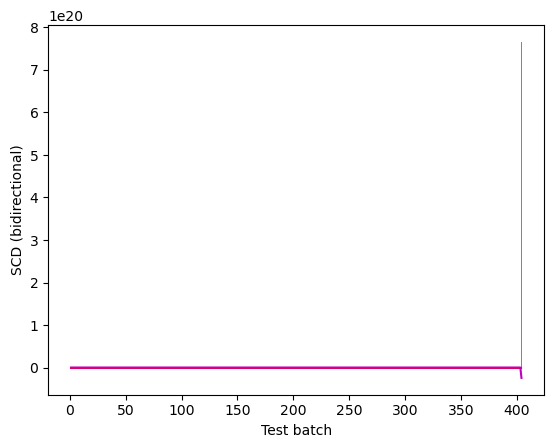

scd_all (bidir) took 416.3125648498535 seconds

 real_world_data/weather_dataset.csv monthly encoder: None

SCD_bidir: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 20

Running in reverse for batch 2
t 0 mean: 60.01577 std: 0.0 diff_std: inf time: 0.0012989044189453125
t 1 mean: 53.38992 std: 6.62586 diff_std: inf time: 0.002203702926635742
t 2 mean: 53.97724 std: 5.47338 diff_std: 0.17394 time: 0.003084897994995117
t 3 mean: 45.83764 std: 14.87372 diff_std: 1.71747 time: 0.003985881805419922
t 4 mean: 44.89763 std: 13.43565 diff_std: 0.09669 time: 0.004899024963378906
t 5 mean: 47.71389 std: 13.78721 diff_std: 0.02617 time: 0.005800724029541016
t 6 mean: 47.10668 std: 12.85084 diff_std: 0.06792 time: 0.006683826446533203
t 7 mean: 45.03942 std: 13.20667 diff_std: 0.02769 time: 0.007569789886474609
t 8 mean: 48.65232 std: 16.1078 diff_std: 0.21967 time: 0.008453845977783203
t 9 mean: 48.53148 std: 15.2855 diff_std: 0.05105 time: 0.009335994720458984
t 10 mean: 47.30823 std: 15.07877 diff_std: 0.01352 time: 0.010226726531982422
t 11 mean: 45.53918 std: 15.58354 diff_std: 0.03348 time: 0.011204004287719727
t 12 mean: 45.52859 std: 14.97223 diff_std: 0.0

Running in reverse for batch 7
t 0 mean: 30.56505 std: 0.0 diff_std: inf time: 0.0009567737579345703
t 1 mean: 182.92717 std: 152.36212 diff_std: inf time: 0.001909017562866211
t 2 mean: 132.03217 std: 143.72455 diff_std: 0.05669 time: 0.0028238296508789062
t 3 mean: 116.38627 std: 127.38502 diff_std: 0.11369 time: 0.00373077392578125
t 4 mean: 99.94065 std: 118.58915 diff_std: 0.06905 time: 0.0046389102935791016
t 5 mean: 229.19997 std: 308.64113 diff_std: 1.60261 time: 0.0055408477783203125
t 6 mean: 287.13395 std: 319.0438 diff_std: 0.0337 time: 0.006454944610595703
t 7 mean: 257.23104 std: 308.74685 diff_std: 0.03227 time: 0.0073659420013427734
t 8 mean: 233.41744 std: 298.78035 diff_std: 0.03228 time: 0.008270740509033203
t 9 mean: 271.71874 std: 305.8523 diff_std: 0.02367 time: 0.009179830551147461
t 10 mean: 278.99614 std: 292.52537 diff_std: 0.04357 time: 0.010201692581176758
t 11 mean: 283.80542 std: 280.52555 diff_std: 0.04102 time: 0.011140823364257812
t 12 mean: 289.32686 s

Running in reverse for batch 11
t 0 mean: 23.78786 std: 0.0 diff_std: inf time: 0.0012531280517578125
t 1 mean: 22.69043 std: 1.09743 diff_std: inf time: 0.002171039581298828
t 2 mean: 21.01784 std: 2.52944 diff_std: 1.30488 time: 0.0030829906463623047
t 3 mean: 20.36337 std: 2.46648 diff_std: 0.02489 time: 0.003955841064453125
t 4 mean: 19.94928 std: 2.35642 diff_std: 0.04462 time: 0.006011962890625
t 5 mean: 19.48807 std: 2.38554 diff_std: 0.01236 time: 0.007208824157714844
t 6 mean: 18.22767 std: 3.79599 diff_std: 0.59125 time: 0.008344888687133789
t 7 mean: 18.10091 std: 3.56662 diff_std: 0.06042 time: 0.009373188018798828
t 8 mean: 17.91869 std: 3.40191 diff_std: 0.04618 time: 0.010355949401855469
t 9 mean: 18.28921 std: 3.4134 diff_std: 0.00338 time: 0.011269092559814453
t 10 mean: 17.53652 std: 4.03208 diff_std: 0.18125 time: 0.012166023254394531
t 11 mean: 16.73916 std: 4.67935 diff_std: 0.16053 time: 0.013064146041870117
t 12 mean: 16.6223 std: 4.51397 diff_std: 0.03534 time: 

Running in reverse for batch 15
t 0 mean: 85.25315 std: 0.0 diff_std: inf time: 0.0011720657348632812
t 1 mean: 63.32473 std: 21.92842 diff_std: inf time: 0.002124786376953125
t 2 mean: 44.01044 std: 32.65967 diff_std: 0.48938 time: 0.003047943115234375
t 3 mean: 43.3034 std: 28.3106 diff_std: 0.13316 time: 0.003960847854614258
t 4 mean: 36.75887 std: 28.50466 diff_std: 0.00685 time: 0.0048639774322509766
t 5 mean: 32.31064 std: 27.85732 diff_std: 0.02271 time: 0.0058100223541259766
t 6 mean: 36.6939 std: 27.93648 diff_std: 0.00284 time: 0.006803035736083984
t 7 mean: 37.08308 std: 26.15246 diff_std: 0.06386 time: 0.007709026336669922
t 8 mean: 37.82972 std: 24.74705 diff_std: 0.05374 time: 0.008882999420166016
t 9 mean: 38.1555 std: 23.49744 diff_std: 0.0505 time: 0.009935855865478516
t 10 mean: 38.50219 std: 22.43074 diff_std: 0.0454 time: 0.011236906051635742
t 11 mean: 38.7776 std: 21.49522 diff_std: 0.04171 time: 0.012613773345947266
t 12 mean: 41.03591 std: 22.08398 diff_std: 0.0

Running in reverse for batch 19
t 0 mean: 40.32501 std: 0.0 diff_std: inf time: 0.0010442733764648438
t 1 mean: 84.68323 std: 44.35822 diff_std: inf time: 0.002019166946411133
t 2 mean: 131.72379 std: 75.74561 diff_std: 0.70759 time: 0.002974271774291992
t 3 mean: 150.77347 std: 73.42832 diff_std: 0.03059 time: 0.00402522087097168
t 4 mean: 147.04997 std: 66.09714 diff_std: 0.09984 time: 0.005056142807006836
t 5 mean: 145.14838 std: 60.4878 diff_std: 0.08487 time: 0.006064176559448242
t 6 mean: 130.18425 std: 66.93014 diff_std: 0.10651 time: 0.007010221481323242
t 7 mean: 130.29001 std: 62.60804 diff_std: 0.06458 time: 0.008009195327758789
t 8 mean: 119.66988 std: 66.23092 diff_std: 0.05787 time: 0.008935213088989258
t 9 mean: 112.13405 std: 66.77559 diff_std: 0.00822 time: 0.009872198104858398
t 10 mean: 120.66965 std: 69.15333 diff_std: 0.03561 time: 0.010809183120727539
t 11 mean: 113.96983 std: 69.83861 diff_std: 0.00991 time: 0.011741161346435547
t 12 mean: 114.54403 std: 67.12824

Running in reverse for batch 23
t 0 mean: 37.80517 std: 0.0 diff_std: inf time: 0.0010139942169189453
t 1 mean: 31.41819 std: 6.38698 diff_std: inf time: 0.0019538402557373047
t 2 mean: 36.06096 std: 8.38488 diff_std: 0.31281 time: 0.0029871463775634766
t 3 mean: 35.54748 std: 7.31578 diff_std: 0.1275 time: 0.004152774810791016
t 4 mean: 32.43174 std: 9.03593 diff_std: 0.23513 time: 0.006083965301513672
t 5 mean: 36.53031 std: 12.3301 diff_std: 0.36456 time: 0.007525920867919922
t 6 mean: 36.91779 std: 11.45485 diff_std: 0.07099 time: 0.008539915084838867
t 7 mean: 35.31379 std: 11.52482 diff_std: 0.00611 time: 0.00950002670288086
t 8 mean: 34.89794 std: 10.92918 diff_std: 0.05168 time: 0.010476112365722656
t 9 mean: 35.24441 std: 10.42031 diff_std: 0.04656 time: 0.011482954025268555
t 10 mean: 35.61116 std: 10.00283 diff_std: 0.04006 time: 0.01240992546081543
t 11 mean: 35.83692 std: 9.60621 diff_std: 0.03965 time: 0.014018774032592773
t 12 mean: 35.24355 std: 9.45546 diff_std: 0.0156

Running in reverse for batch 27
t 0 mean: 94.23497 std: 0.0 diff_std: inf time: 0.0024139881134033203
t 1 mean: 92.13446 std: 2.10051 diff_std: inf time: 0.003918170928955078
t 2 mean: 137.67518 std: 64.42714 diff_std: 29.67215 time: 0.004850149154663086
t 3 mean: 142.90168 std: 56.52513 diff_std: 0.12265 time: 0.005843162536621094
t 4 mean: 146.40197 std: 51.03999 diff_std: 0.09704 time: 0.007152080535888672
t 5 mean: 156.56912 std: 51.84356 diff_std: 0.01574 time: 0.008072137832641602
t 6 mean: 135.77784 std: 69.98181 diff_std: 0.34986 time: 0.008977174758911133
t 7 mean: 130.32829 std: 67.031 diff_std: 0.04217 time: 0.009934186935424805
t 8 mean: 139.53305 std: 68.35011 diff_std: 0.01968 time: 0.010849952697753906
t 9 mean: 142.13063 std: 65.30919 diff_std: 0.04449 time: 0.012319326400756836
t 10 mean: 137.0808 std: 64.28487 diff_std: 0.01568 time: 0.013859033584594727
t 11 mean: 133.36703 std: 62.76845 diff_std: 0.02359 time: 0.014789104461669922
t 12 mean: 123.57945 std: 69.18361 

Running in reverse for batch 31
t 0 mean: 15.87512 std: 0.0 diff_std: inf time: 0.0009758472442626953
t 1 mean: 19.2032 std: 3.32808 diff_std: inf time: 0.0019116401672363281
t 2 mean: 13.20082 std: 8.91298 diff_std: 1.67812 time: 0.0028128623962402344
t 3 mean: 15.66335 std: 8.81891 diff_std: 0.01055 time: 0.003747701644897461
t 4 mean: 14.3961 std: 8.28506 diff_std: 0.06053 time: 0.004663705825805664
t 5 mean: 12.98275 std: 8.19693 diff_std: 0.01064 time: 0.005684852600097656
t 6 mean: 13.16745 std: 7.60236 diff_std: 0.07254 time: 0.006661891937255859
t 7 mean: 12.35803 std: 7.42681 diff_std: 0.02309 time: 0.007630825042724609
t 8 mean: 13.23757 std: 7.43085 diff_std: 0.00054 time: 0.008563995361328125
t 9 mean: 13.28411 std: 7.05091 diff_std: 0.05113 time: 0.009551763534545898
t 10 mean: 14.45888 std: 7.68092 diff_std: 0.08935 time: 0.010493993759155273
t 11 mean: 14.11828 std: 7.44017 diff_std: 0.03134 time: 0.011441946029663086
t 12 mean: 14.6276 std: 7.36281 diff_std: 0.0104 time

Running in reverse for batch 35
t 0 mean: 50.38665 std: 0.0 diff_std: inf time: 0.001313924789428711
t 1 mean: 45.14353 std: 5.24312 diff_std: inf time: 0.0022270679473876953
t 2 mean: 44.31643 std: 4.43791 diff_std: 0.15357 time: 0.0031099319458007812
t 3 mean: 38.66543 std: 10.51536 diff_std: 1.36944 time: 0.004161834716796875
t 4 mean: 39.79784 std: 9.67407 diff_std: 0.08001 time: 0.005171060562133789
t 5 mean: 41.54013 std: 9.65234 diff_std: 0.00225 time: 0.006097078323364258
t 6 mean: 43.10475 std: 9.72348 diff_std: 0.00737 time: 0.0070209503173828125
t 7 mean: 41.84613 std: 9.6859 diff_std: 0.00387 time: 0.00798797607421875
t 8 mean: 44.2174 std: 11.33031 diff_std: 0.16977 time: 0.008888959884643555
t 9 mean: 43.51976 std: 10.95074 diff_std: 0.0335 time: 0.00987696647644043
t 10 mean: 42.8613 std: 10.64672 diff_std: 0.02776 time: 0.01082611083984375
t 11 mean: 43.57437 std: 10.46421 diff_std: 0.01714 time: 0.011726856231689453
t 12 mean: 42.76416 std: 10.43811 diff_std: 0.00249 t

Running in reverse for batch 39
t 0 mean: 145.17254 std: 0.0 diff_std: inf time: 0.0015749931335449219
t 1 mean: 84.30572 std: 60.86682 diff_std: inf time: 0.0025510787963867188
t 2 mean: 107.05185 std: 59.19983 diff_std: 0.02739 time: 0.003509998321533203
t 3 mean: 84.36195 std: 64.59845 diff_std: 0.09119 time: 0.004446983337402344
t 4 mean: 97.34683 std: 63.34663 diff_std: 0.01938 time: 0.005709171295166016
t 5 mean: 95.95091 std: 57.91148 diff_std: 0.0858 time: 0.007247209548950195
t 6 mean: 95.44151 std: 53.63013 diff_std: 0.07393 time: 0.008323192596435547
t 7 mean: 95.0278 std: 50.17833 diff_std: 0.06436 time: 0.009498119354248047
t 8 mean: 86.96425 std: 52.51922 diff_std: 0.04665 time: 0.01053309440612793
t 9 mean: 79.14527 std: 55.06969 diff_std: 0.04856 time: 0.011595010757446289
t 10 mean: 80.48979 std: 52.67875 diff_std: 0.04342 time: 0.012655258178710938
t 11 mean: 86.59479 std: 54.34867 diff_std: 0.0317 time: 0.013747930526733398
t 12 mean: 90.85549 std: 54.26239 diff_std:

Running in reverse for batch 44
t 0 mean: 214.95004 std: 0.0 diff_std: inf time: 0.0013272762298583984
t 1 mean: 212.66498 std: 2.28506 diff_std: inf time: 0.002251148223876953
t 2 mean: 219.60214 std: 9.98645 diff_std: 3.37033 time: 0.0033979415893554688
t 3 mean: 249.11437 std: 51.84316 diff_std: 4.19135 time: 0.004472255706787109
t 4 mean: 241.88778 std: 48.57021 diff_std: 0.06313 time: 0.005383014678955078
t 5 mean: 211.14658 std: 81.7985 diff_std: 0.68413 time: 0.006284236907958984
t 6 mean: 220.6219 std: 79.2075 diff_std: 0.03168 time: 0.007194995880126953
t 7 mean: 220.17628 std: 74.10121 diff_std: 0.06447 time: 0.008308172225952148
t 8 mean: 224.44502 std: 70.89892 diff_std: 0.04322 time: 0.00931692123413086
t 9 mean: 229.99627 std: 69.29168 diff_std: 0.02267 time: 0.010389089584350586
t 10 mean: 230.57875 std: 66.0927 diff_std: 0.04617 time: 0.011614084243774414
t 11 mean: 234.45962 std: 64.57474 diff_std: 0.02297 time: 0.012894153594970703
t 12 mean: 242.89079 std: 68.57223 d

Running in reverse for batch 48
t 0 mean: 240.45468 std: 0.0 diff_std: inf time: 0.0012919902801513672
t 1 mean: 431.37077 std: 190.91609 diff_std: inf time: 0.0022068023681640625
t 2 mean: 596.13958 std: 280.35125 diff_std: 0.46845 time: 0.0031058788299560547
t 3 mean: 582.55828 std: 243.92821 diff_std: 0.12992 time: 0.0040318965911865234
t 4 mean: 659.91975 std: 267.46956 diff_std: 0.09651 time: 0.004976749420166016
t 5 mean: 748.60569 std: 314.55146 diff_std: 0.17603 time: 0.005924701690673828
t 6 mean: 645.98243 std: 384.704 diff_std: 0.22302 time: 0.0068569183349609375
t 7 mean: 643.00345 std: 359.94394 diff_std: 0.06436 time: 0.007752895355224609
t 8 mean: 642.69649 std: 339.35951 diff_std: 0.05719 time: 0.008651018142700195
t 9 mean: 583.62117 std: 367.5016 diff_std: 0.08293 time: 0.009544849395751953
t 10 mean: 573.55906 std: 351.84079 diff_std: 0.04261 time: 0.010437726974487305
t 11 mean: 564.84342 std: 338.09988 diff_std: 0.03905 time: 0.011477947235107422
t 12 mean: 558.348

Running in reverse for batch 52
t 0 mean: 469.45985 std: 0.0 diff_std: inf time: 0.0014438629150390625
t 1 mean: 493.22261 std: 23.76276 diff_std: inf time: 0.003307819366455078
t 2 mean: 477.04815 std: 29.99453 diff_std: 0.26225 time: 0.007028102874755859
t 3 mean: 379.31234 std: 171.26476 diff_std: 4.70987 time: 0.009185791015625
t 4 mean: 334.26202 std: 177.71724 diff_std: 0.03768 time: 0.011305093765258789
t 5 mean: 404.35333 std: 225.57365 diff_std: 0.26928 time: 0.012748956680297852
t 6 mean: 410.95705 std: 209.46613 diff_std: 0.07141 time: 0.014132022857666016
t 7 mean: 371.81588 std: 221.62077 diff_std: 0.05803 time: 0.015527009963989258
t 8 mean: 347.78628 std: 219.72217 diff_std: 0.00857 time: 0.017160892486572266
t 9 mean: 360.52818 std: 211.92275 diff_std: 0.0355 time: 0.01818394660949707
t 10 mean: 373.00208 std: 205.87471 diff_std: 0.02854 time: 0.019148826599121094
t 11 mean: 359.57653 std: 202.07687 diff_std: 0.01845 time: 0.02020096778869629
t 12 mean: 392.25015 std: 2

Running in reverse for batch 56
t 0 mean: 79.70482 std: 0.0 diff_std: inf time: 0.002043008804321289
t 1 mean: 108.79075 std: 29.08593 diff_std: inf time: 0.003718852996826172
t 2 mean: 99.48411 std: 27.15182 diff_std: 0.0665 time: 0.005303859710693359
t 3 mean: 114.94437 std: 35.6367 diff_std: 0.3125 time: 0.006973981857299805
t 4 mean: 117.61546 std: 32.31901 diff_std: 0.0931 time: 0.008594751358032227
t 5 mean: 100.03837 std: 49.14472 diff_std: 0.52061 time: 0.010524749755859375
t 6 mean: 104.18659 std: 46.61996 diff_std: 0.05137 time: 0.01193380355834961
t 7 mean: 100.11745 std: 44.91824 diff_std: 0.0365 time: 0.013571977615356445
t 8 mean: 102.65385 std: 42.95266 diff_std: 0.04376 time: 0.015484809875488281
t 9 mean: 92.98953 std: 50.0103 diff_std: 0.16431 time: 0.017136096954345703
t 10 mean: 100.36363 std: 53.07954 diff_std: 0.06137 time: 0.0191957950592041
t 11 mean: 92.49957 std: 57.12205 diff_std: 0.07616 time: 0.020743846893310547
t 12 mean: 90.48414 std: 55.32339 diff_std: 

Running in reverse for batch 60
t 0 mean: 27.23424 std: 0.0 diff_std: inf time: 0.001291036605834961
t 1 mean: 22.75907 std: 4.47518 diff_std: inf time: 0.002176046371459961
t 2 mean: 28.13744 std: 8.43832 diff_std: 0.88558 time: 0.003101348876953125
t 3 mean: 29.69596 std: 7.79044 diff_std: 0.07678 time: 0.004079103469848633
t 4 mean: 28.881 std: 7.15607 diff_std: 0.08143 time: 0.004983186721801758
t 5 mean: 28.59691 std: 6.56338 diff_std: 0.08282 time: 0.005895376205444336
t 6 mean: 26.68154 std: 7.67697 diff_std: 0.16967 time: 0.0067822933197021484
t 7 mean: 27.79424 std: 7.76116 diff_std: 0.01097 time: 0.007692098617553711
t 8 mean: 29.37454 std: 8.57447 diff_std: 0.10479 time: 0.008598089218139648
t 9 mean: 28.052 std: 9.05049 diff_std: 0.05552 time: 0.009533166885375977
t 10 mean: 29.17317 std: 9.32927 diff_std: 0.0308 time: 0.010435104370117188
t 11 mean: 30.64873 std: 10.1849 diff_std: 0.09171 time: 0.011319160461425781
t 12 mean: 29.63612 std: 10.39507 diff_std: 0.02064 time: 

Running in reverse for batch 63
t 0 mean: 147.47794 std: 0.0 diff_std: inf time: 0.001447916030883789
t 1 mean: 135.61369 std: 11.86425 diff_std: inf time: 0.002482891082763672
t 2 mean: 134.04837 std: 9.93684 diff_std: 0.16246 time: 0.00347900390625
t 3 mean: 136.53067 std: 9.61982 diff_std: 0.0319 time: 0.004387855529785156
t 4 mean: 136.06652 std: 8.65416 diff_std: 0.10038 time: 0.005291938781738281
t 5 mean: 136.45545 std: 7.94785 diff_std: 0.08161 time: 0.0062220096588134766
t 6 mean: 118.8138 std: 43.83506 diff_std: 4.51533 time: 0.007127046585083008
t 7 mean: 134.54621 std: 58.42847 diff_std: 0.33292 time: 0.008037805557250977
t 8 mean: 132.69067 std: 55.33633 diff_std: 0.05292 time: 0.008949041366577148
t 9 mean: 122.13942 std: 61.30137 diff_std: 0.1078 time: 0.00983881950378418
t 10 mean: 115.32592 std: 62.29344 diff_std: 0.01618 time: 0.010767936706542969
t 11 mean: 116.29309 std: 59.72763 diff_std: 0.04119 time: 0.0117340087890625
t 12 mean: 125.623 std: 65.86001 diff_std: 0

Running in reverse for batch 66
t 0 mean: 34.50432 std: 0.0 diff_std: inf time: 0.0012869834899902344
t 1 mean: 41.46812 std: 6.96379 diff_std: inf time: 0.0031099319458007812
t 2 mean: 45.59436 std: 8.14748 diff_std: 0.16998 time: 0.004888772964477539
t 3 mean: 47.25238 std: 7.61795 diff_std: 0.06499 time: 0.0072977542877197266
t 4 mean: 41.02636 std: 14.19437 diff_std: 0.86328 time: 0.009490966796875
t 5 mean: 41.58448 std: 13.01759 diff_std: 0.0829 time: 0.010965108871459961
t 6 mean: 37.90825 std: 15.04452 diff_std: 0.15571 time: 0.0120849609375
t 7 mean: 38.62356 std: 14.19954 diff_std: 0.05616 time: 0.013316869735717773
t 8 mean: 36.14766 std: 15.10843 diff_std: 0.06401 time: 0.014642953872680664
t 9 mean: 33.25163 std: 16.76071 diff_std: 0.10936 time: 0.016106128692626953
t 10 mean: 35.41342 std: 17.38149 diff_std: 0.03704 time: 0.01750469207763672
t 11 mean: 34.72812 std: 16.79601 diff_std: 0.03368 time: 0.01902294158935547
t 12 mean: 32.64413 std: 17.67829 diff_std: 0.05253 ti

Running in reverse for batch 70
t 0 mean: 599.5904 std: 0.0 diff_std: inf time: 0.001004934310913086
t 1 mean: 457.20351 std: 142.38689 diff_std: inf time: 0.001978158950805664
t 2 mean: 430.45306 std: 122.25871 diff_std: 0.14136 time: 0.002897977828979492
t 3 mean: 368.37086 std: 150.90723 diff_std: 0.23433 time: 0.003854990005493164
t 4 mean: 335.21484 std: 150.3851 diff_std: 0.00346 time: 0.004787921905517578
t 5 mean: 314.30695 std: 145.02448 diff_std: 0.03565 time: 0.005713939666748047
t 6 mean: 295.45691 std: 141.984 diff_std: 0.02097 time: 0.006627082824707031
t 7 mean: 291.14784 std: 133.30229 diff_std: 0.06115 time: 0.007547855377197266
t 8 mean: 325.62561 std: 159.07497 diff_std: 0.19334 time: 0.008571863174438477
t 9 mean: 350.66711 std: 168.57654 diff_std: 0.05973 time: 0.009624004364013672
t 10 mean: 394.00501 std: 211.22576 diff_std: 0.253 time: 0.01062917709350586
t 11 mean: 377.20071 std: 209.77255 diff_std: 0.00688 time: 0.011578083038330078
t 12 mean: 374.94746 std: 2

Running in reverse for batch 74
t 0 mean: 1013.15285 std: 0.0 diff_std: inf time: 0.0013027191162109375
t 1 mean: 1001.36899 std: 11.78386 diff_std: inf time: 0.002457857131958008
t 2 mean: 723.05451 std: 393.7137 diff_std: 32.41127 time: 0.004083871841430664
t 3 mean: 709.80031 std: 341.73803 diff_std: 0.13201 time: 0.005303621292114258
t 4 mean: 773.93229 std: 331.48084 diff_std: 0.03001 time: 0.006365776062011719
t 5 mean: 660.56758 std: 394.7456 diff_std: 0.19085 time: 0.00739288330078125
t 6 mean: 583.91659 std: 410.87194 diff_std: 0.04085 time: 0.008467912673950195
t 7 mean: 590.03283 std: 384.67602 diff_std: 0.06376 time: 0.009773731231689453
t 8 mean: 592.85976 std: 362.76416 diff_std: 0.05696 time: 0.010745763778686523
t 9 mean: 544.3429 std: 373.66164 diff_std: 0.03004 time: 0.011705875396728516
t 10 mean: 506.78372 std: 375.54885 diff_std: 0.00505 time: 0.012643814086914062
t 11 mean: 474.43354 std: 375.22758 diff_std: 0.00086 time: 0.013730764389038086
t 12 mean: 442.50638 

Running in reverse for batch 80
t 0 mean: 56.36039 std: 0.0 diff_std: inf time: 0.0013661384582519531
t 1 mean: 73.56908 std: 17.20868 diff_std: inf time: 0.002318859100341797
t 2 mean: 63.0357 std: 20.47754 diff_std: 0.18995 time: 0.0032401084899902344
t 3 mean: 63.02841 std: 17.73407 diff_std: 0.13397 time: 0.0041730403900146484
t 4 mean: 64.29015 std: 16.06131 diff_std: 0.09432 time: 0.005237102508544922
t 5 mean: 67.03048 std: 15.89083 diff_std: 0.01061 time: 0.006181001663208008
t 6 mean: 61.97456 std: 19.23066 diff_std: 0.21017 time: 0.007107973098754883
t 7 mean: 60.81236 std: 18.24954 diff_std: 0.05102 time: 0.008031129837036133
t 8 mean: 60.83304 std: 17.20594 diff_std: 0.05719 time: 0.008955955505371094
t 9 mean: 65.06965 std: 20.68766 diff_std: 0.20236 time: 0.00990605354309082
t 10 mean: 65.20263 std: 19.7294 diff_std: 0.04632 time: 0.010933160781860352
t 11 mean: 65.03802 std: 18.89735 diff_std: 0.04217 time: 0.011985063552856445
t 12 mean: 62.72168 std: 19.85006 diff_std:

Running in reverse for batch 84
t 0 mean: 25.41804 std: 0.0 diff_std: inf time: 0.0012836456298828125
t 1 mean: 22.62681 std: 2.79123 diff_std: inf time: 0.0021927356719970703
t 2 mean: 26.91377 std: 6.47689 diff_std: 1.32044 time: 0.003113985061645508
t 3 mean: 25.96724 std: 5.84383 diff_std: 0.09774 time: 0.004013776779174805
t 4 mean: 27.60999 std: 6.17372 diff_std: 0.05645 time: 0.004899024963378906
t 5 mean: 32.78675 std: 12.87464 diff_std: 1.0854 time: 0.005796670913696289
t 6 mean: 34.45393 std: 12.59976 diff_std: 0.02135 time: 0.006696939468383789
t 7 mean: 35.80644 std: 12.31725 diff_std: 0.02242 time: 0.007606029510498047
t 8 mean: 35.62149 std: 11.62459 diff_std: 0.05623 time: 0.008493661880493164
t 9 mean: 36.07144 std: 11.11036 diff_std: 0.04424 time: 0.009484052658081055
t 10 mean: 37.10351 std: 11.08467 diff_std: 0.00231 time: 0.010390996932983398
t 11 mean: 36.3968 std: 10.86852 diff_std: 0.0195 time: 0.011313915252685547
t 12 mean: 35.92199 std: 10.57088 diff_std: 0.02

Running in reverse for batch 88
t 0 mean: 17.0406 std: 0.0 diff_std: inf time: 0.0009441375732421875
t 1 mean: 13.92518 std: 3.11542 diff_std: inf time: 0.0018858909606933594
t 2 mean: 12.31651 std: 3.41266 diff_std: 0.09541 time: 0.00304412841796875
t 3 mean: 11.89527 std: 3.04417 diff_std: 0.10798 time: 0.003981113433837891
t 4 mean: 11.93057 std: 2.72371 diff_std: 0.10527 time: 0.004878044128417969
t 5 mean: 12.54351 std: 2.83912 diff_std: 0.04237 time: 0.005908966064453125
t 6 mean: 12.13304 std: 2.81424 diff_std: 0.00876 time: 0.006805896759033203
t 7 mean: 12.25501 std: 2.65219 diff_std: 0.05758 time: 0.008419990539550781
t 8 mean: 12.67161 std: 2.76423 diff_std: 0.04225 time: 0.00963902473449707
t 9 mean: 13.13376 std: 2.96633 diff_std: 0.07311 time: 0.011107921600341797
t 10 mean: 12.46956 std: 3.5229 diff_std: 0.18763 time: 0.012372970581054688
t 11 mean: 12.03218 std: 3.67164 diff_std: 0.04222 time: 0.0133209228515625
t 12 mean: 12.39131 std: 3.74054 diff_std: 0.01877 time: 0

Running in reverse for batch 92
t 0 mean: 125.10764 std: 0.0 diff_std: inf time: 0.002444028854370117
t 1 mean: 182.03483 std: 56.9272 diff_std: inf time: 0.003606081008911133
t 2 mean: 145.68165 std: 69.30785 diff_std: 0.21748 time: 0.004665851593017578
t 3 mean: 159.01481 std: 64.31176 diff_std: 0.07209 time: 0.006915092468261719
t 4 mean: 161.878 std: 57.80652 diff_std: 0.10115 time: 0.008105039596557617
t 5 mean: 181.20167 std: 68.20324 diff_std: 0.17985 time: 0.009334087371826172
t 6 mean: 193.08445 std: 69.52955 diff_std: 0.01945 time: 0.010298967361450195
t 7 mean: 199.2266 std: 67.03839 diff_std: 0.03583 time: 0.012187957763671875
t 8 mean: 192.98703 std: 65.62205 diff_std: 0.02113 time: 0.01782989501953125
t 9 mean: 204.69034 std: 71.47262 diff_std: 0.08916 time: 0.01881718635559082
t 10 mean: 213.19438 std: 73.26069 diff_std: 0.02502 time: 0.019763946533203125
t 11 mean: 206.77799 std: 73.29897 diff_std: 0.00052 time: 0.020699024200439453
t 12 mean: 208.47285 std: 70.66769 di

Running in reverse for batch 95
t 0 mean: 735.9738 std: 0.0 diff_std: inf time: 0.0012879371643066406
t 1 mean: 754.43605 std: 18.46226 diff_std: inf time: 0.0022258758544921875
t 2 mean: 1321.69312 std: 802.36426 diff_std: 42.4597 time: 0.003142833709716797
t 3 mean: 1523.08389 std: 777.50628 diff_std: 0.03098 time: 0.004041910171508789
t 4 mean: 1403.6966 std: 735.27282 diff_std: 0.05432 time: 0.0049359798431396484
t 5 mean: 1617.37911 std: 823.90706 diff_std: 0.12055 time: 0.005845069885253906
t 6 mean: 1660.2744 std: 769.99233 diff_std: 0.06544 time: 0.006757974624633789
t 7 mean: 1715.72315 std: 735.05041 diff_std: 0.04538 time: 0.007700920104980469
t 8 mean: 1742.91027 std: 697.26537 diff_std: 0.0514 time: 0.008622884750366211
t 9 mean: 1754.92796 std: 662.46579 diff_std: 0.04991 time: 0.009601831436157227
t 10 mean: 1756.29362 std: 631.65111 diff_std: 0.04652 time: 0.010566949844360352
t 11 mean: 1801.42349 std: 623.00745 diff_std: 0.01368 time: 0.011503934860229492
t 12 mean: 1

Running in reverse for batch 99
t 0 mean: 745.30355 std: 0.0 diff_std: inf time: 0.001161336898803711
t 1 mean: 1233.88472 std: 488.58116 diff_std: inf time: 0.002100229263305664
t 2 mean: 1044.29739 std: 480.65345 diff_std: 0.01623 time: 0.0031082630157470703
t 3 mean: 946.53269 std: 449.38249 diff_std: 0.06506 time: 0.004020214080810547
t 4 mean: 999.76378 std: 415.8003 diff_std: 0.07473 time: 0.0049190521240234375
t 5 mean: 959.74061 std: 389.97971 diff_std: 0.0621 time: 0.005995035171508789
t 6 mean: 1065.18391 std: 443.92298 diff_std: 0.13832 time: 0.007297039031982422
t 7 mean: 1028.80866 std: 426.25845 diff_std: 0.03979 time: 0.00825810432434082
t 8 mean: 1008.44545 std: 405.98655 diff_std: 0.04756 time: 0.009144067764282227
t 9 mean: 1076.0117 std: 435.23482 diff_std: 0.07204 time: 0.010057210922241211
t 10 mean: 1049.43369 std: 423.40572 diff_std: 0.02718 time: 0.010974407196044922
t 11 mean: 1062.25151 std: 407.60311 diff_std: 0.03732 time: 0.011875152587890625
t 12 mean: 114

Running in reverse for batch 103
t 0 mean: 250.69254 std: 0.0 diff_std: inf time: 0.0010190010070800781
t 1 mean: 251.30555 std: 0.61301 diff_std: inf time: 0.0019981861114501953
t 2 mean: 251.83746 std: 0.90354 diff_std: 0.47394 time: 0.0029561519622802734
t 3 mean: 249.2059 std: 4.62467 diff_std: 4.11841 time: 0.0039031505584716797
t 4 mean: 260.31751 std: 22.6049 diff_std: 3.88789 time: 0.004844188690185547
t 5 mean: 268.9382 std: 28.23826 diff_std: 0.24921 time: 0.005835056304931641
t 6 mean: 276.54921 std: 32.10997 diff_std: 0.13711 time: 0.006779909133911133
t 7 mean: 264.16916 std: 44.4413 diff_std: 0.38403 time: 0.007714033126831055
t 8 mean: 271.38762 std: 46.60934 diff_std: 0.04878 time: 0.008667945861816406
t 9 mean: 269.37526 std: 44.62772 diff_std: 0.04252 time: 0.009628057479858398
t 10 mean: 266.09845 std: 43.79441 diff_std: 0.01867 time: 0.01067495346069336
t 11 mean: 263.71924 std: 42.66601 diff_std: 0.02577 time: 0.011667013168334961
t 12 mean: 266.77494 std: 42.33682

Running in reverse for batch 107
t 0 mean: 42.55724 std: 0.0 diff_std: inf time: 0.0010268688201904297
t 1 mean: 44.39151 std: 1.83427 diff_std: inf time: 0.002106904983520508
t 2 mean: 51.49665 std: 10.15919 diff_std: 4.53855 time: 0.0031168460845947266
t 3 mean: 45.25848 std: 13.93382 diff_std: 0.37155 time: 0.004256725311279297
t 4 mean: 44.60266 std: 12.53162 diff_std: 0.10063 time: 0.005322933197021484
t 5 mean: 44.96739 std: 11.46879 diff_std: 0.08481 time: 0.006318807601928711
t 6 mean: 41.17035 std: 14.11552 diff_std: 0.23078 time: 0.007245779037475586
t 7 mean: 45.97694 std: 18.33209 diff_std: 0.29872 time: 0.008313894271850586
t 8 mean: 45.16593 std: 17.43521 diff_std: 0.04892 time: 0.00943899154663086
t 9 mean: 45.48753 std: 16.56861 diff_std: 0.0497 time: 0.010464668273925781
t 10 mean: 47.97055 std: 17.64133 diff_std: 0.06474 time: 0.011665821075439453
t 11 mean: 48.50462 std: 16.98292 diff_std: 0.03732 time: 0.012616872787475586
t 12 mean: 48.83726 std: 16.35729 diff_std:

Running in reverse for batch 111
t 0 mean: 166.72019 std: 0.0 diff_std: inf time: 0.0013561248779296875
t 1 mean: 142.41998 std: 24.30021 diff_std: inf time: 0.0023031234741210938
t 2 mean: 116.68881 std: 41.44698 diff_std: 0.70562 time: 0.003222227096557617
t 3 mean: 106.08748 std: 40.31817 diff_std: 0.02724 time: 0.00411534309387207
t 4 mean: 88.76989 std: 50.00039 diff_std: 0.24015 time: 0.005064249038696289
t 5 mean: 90.77474 std: 45.86352 diff_std: 0.08274 time: 0.005990266799926758
t 6 mean: 80.91236 std: 48.8525 diff_std: 0.06517 time: 0.00690007209777832
t 7 mean: 81.82755 std: 45.76143 diff_std: 0.06327 time: 0.007865190505981445
t 8 mean: 83.55354 std: 43.41961 diff_std: 0.05117 time: 0.008852005004882812
t 9 mean: 91.36007 std: 47.38368 diff_std: 0.0913 time: 0.009813070297241211
t 10 mean: 94.20223 std: 46.06389 diff_std: 0.02785 time: 0.010727167129516602
t 11 mean: 95.62504 std: 44.35455 diff_std: 0.03711 time: 0.011634349822998047
t 12 mean: 93.52041 std: 43.23364 diff_s

Running in reverse for batch 115
t 0 mean: 85.33011 std: 0.0 diff_std: inf time: 0.0010020732879638672
t 1 mean: 74.6804 std: 10.64971 diff_std: inf time: 0.0019359588623046875
t 2 mean: 71.23908 std: 9.96475 diff_std: 0.06432 time: 0.0028848648071289062
t 3 mean: 65.59742 std: 13.03676 diff_std: 0.30829 time: 0.0038738250732421875
t 4 mean: 73.61501 std: 19.82656 diff_std: 0.52082 time: 0.004848957061767578
t 5 mean: 73.91668 std: 18.11166 diff_std: 0.0865 time: 0.006284952163696289
t 6 mean: 70.4258 std: 18.82253 diff_std: 0.03925 time: 0.007490873336791992
t 7 mean: 69.54686 std: 17.75977 diff_std: 0.05646 time: 0.00845193862915039
t 8 mean: 67.96867 std: 17.32886 diff_std: 0.02426 time: 0.009376764297485352
t 9 mean: 66.43629 std: 17.07028 diff_std: 0.01492 time: 0.010370969772338867
t 10 mean: 66.08603 std: 16.31351 diff_std: 0.04433 time: 0.011295795440673828
t 11 mean: 64.33081 std: 16.6686 diff_std: 0.02177 time: 0.012243986129760742
t 12 mean: 64.64865 std: 16.05247 diff_std: 

Running in reverse for batch 119
t 0 mean: 373.28293 std: 0.0 diff_std: inf time: 0.0015180110931396484
t 1 mean: 197.95006 std: 175.33287 diff_std: inf time: 0.0026628971099853516
t 2 mean: 165.15201 std: 150.48533 diff_std: 0.14172 time: 0.0038640499114990234
t 3 mean: 215.76481 std: 157.06477 diff_std: 0.04372 time: 0.004939079284667969
t 4 mean: 226.19222 std: 142.02253 diff_std: 0.09577 time: 0.006042957305908203
t 5 mean: 229.91115 std: 129.91465 diff_std: 0.08525 time: 0.0070950984954833984
t 6 mean: 226.17726 std: 120.62484 diff_std: 0.07151 time: 0.008189916610717773
t 7 mean: 247.41004 std: 126.04513 diff_std: 0.04494 time: 0.00923013687133789
t 8 mean: 276.16727 std: 144.00672 diff_std: 0.1425 time: 0.010172843933105469
t 9 mean: 269.64361 std: 138.01147 diff_std: 0.04163 time: 0.011320114135742188
t 10 mean: 282.1824 std: 137.43296 diff_std: 0.00419 time: 0.012365102767944336
t 11 mean: 273.35244 std: 134.80164 diff_std: 0.01915 time: 0.013267993927001953
t 12 mean: 268.770

Running in reverse for batch 123
t 0 mean: 16.4855 std: 0.0 diff_std: inf time: 0.001039266586303711
t 1 mean: 9.93675 std: 6.54875 diff_std: inf time: 0.0020563602447509766
t 2 mean: 8.20316 std: 5.8823 diff_std: 0.10177 time: 0.0032491683959960938
t 3 mean: 7.21421 std: 5.37449 diff_std: 0.08633 time: 0.004266023635864258
t 4 mean: 8.8908 std: 5.86106 diff_std: 0.09053 time: 0.005238056182861328
t 5 mean: 8.55922 std: 5.40152 diff_std: 0.07841 time: 0.00619816780090332
t 6 mean: 8.04083 std: 5.15953 diff_std: 0.0448 time: 0.007146120071411133
t 7 mean: 7.52554 std: 5.01516 diff_std: 0.02798 time: 0.008103370666503906
t 8 mean: 9.41449 std: 7.13459 diff_std: 0.4226 time: 0.009044170379638672
t 9 mean: 9.23221 std: 6.79052 diff_std: 0.04823 time: 0.01023411750793457
t 10 mean: 8.54763 std: 6.82684 diff_std: 0.00535 time: 0.011288166046142578
t 11 mean: 8.04033 std: 6.74928 diff_std: 0.01136 time: 0.012249231338500977
t 12 mean: 8.54171 std: 6.71307 diff_std: 0.00537 time: 0.01324129104

Running in reverse for batch 128
t 0 mean: 256.19782 std: 0.0 diff_std: inf time: 0.0012657642364501953
t 1 mean: 277.55379 std: 21.35597 diff_std: inf time: 0.0021796226501464844
t 2 mean: 277.31038 std: 17.44047 diff_std: 0.18334 time: 0.0030918121337890625
t 3 mean: 267.17795 std: 23.15439 diff_std: 0.32762 time: 0.00400090217590332
t 4 mean: 259.25528 std: 26.07634 diff_std: 0.12619 time: 0.004961729049682617
t 5 mean: 244.57797 std: 40.54335 diff_std: 0.55479 time: 0.00593876838684082
t 6 mean: 246.80997 std: 37.93192 diff_std: 0.06441 time: 0.006846904754638672
t 7 mean: 247.26672 std: 35.50264 diff_std: 0.06404 time: 0.007749795913696289
t 8 mean: 234.1003 std: 50.0722 diff_std: 0.41038 time: 0.008666753768920898
t 9 mean: 235.19433 std: 47.61591 diff_std: 0.04905 time: 0.009695768356323242
t 10 mean: 221.51695 std: 62.7046 diff_std: 0.31688 time: 0.010606765747070312
t 11 mean: 219.07109 std: 60.58066 diff_std: 0.03387 time: 0.011502742767333984
t 12 mean: 235.3904 std: 81.1390

Running in reverse for batch 132
t 0 mean: 37.92967 std: 0.0 diff_std: inf time: 0.0012557506561279297
t 1 mean: 40.83164 std: 2.90197 diff_std: inf time: 0.0028629302978515625
t 2 mean: 39.57293 std: 2.96361 diff_std: 0.02124 time: 0.004492998123168945
t 3 mean: 38.73791 std: 2.94602 diff_std: 0.00594 time: 0.005651950836181641
t 4 mean: 32.26425 std: 13.21272 diff_std: 3.48494 time: 0.006971836090087891
t 5 mean: 32.61819 std: 12.08745 diff_std: 0.08517 time: 0.008037090301513672
t 6 mean: 31.08098 std: 11.80729 diff_std: 0.02318 time: 0.009005069732666016
t 7 mean: 30.43712 std: 11.17531 diff_std: 0.05352 time: 0.009926795959472656
t 8 mean: 30.07368 std: 10.58621 diff_std: 0.05271 time: 0.011334896087646484
t 9 mean: 30.60547 std: 10.16888 diff_std: 0.03942 time: 0.01304006576538086
t 10 mean: 31.02342 std: 9.78532 diff_std: 0.03772 time: 0.014724016189575195
t 11 mean: 30.25735 std: 9.70714 diff_std: 0.00799 time: 0.016473054885864258
t 12 mean: 32.39776 std: 11.91453 diff_std: 0.

Running in reverse for batch 136
t 0 mean: 149.17297 std: 0.0 diff_std: inf time: 0.0013580322265625
t 1 mean: 142.28591 std: 6.88706 diff_std: inf time: 0.002311229705810547
t 2 mean: 120.5714 std: 31.21957 diff_std: 3.53307 time: 0.0032303333282470703
t 3 mean: 109.42454 std: 33.22278 diff_std: 0.06417 time: 0.004171133041381836
t 4 mean: 102.50962 std: 32.77601 diff_std: 0.01345 time: 0.005101203918457031
t 5 mean: 96.17304 std: 33.10564 diff_std: 0.01006 time: 0.00604701042175293
t 6 mean: 88.95533 std: 35.38343 diff_std: 0.0688 time: 0.007001161575317383
t 7 mean: 85.43223 std: 34.38567 diff_std: 0.0282 time: 0.007954120635986328
t 8 mean: 79.86519 std: 36.04073 diff_std: 0.04813 time: 0.008900165557861328
t 9 mean: 78.86609 std: 34.32236 diff_std: 0.04768 time: 0.009851217269897461
t 10 mean: 76.6272 std: 33.4822 diff_std: 0.02448 time: 0.010798215866088867
t 11 mean: 78.39729 std: 32.5899 diff_std: 0.02665 time: 0.011753320693969727
t 12 mean: 80.28651 std: 31.98799 diff_std: 0.

Running in reverse for batch 142
t 0 mean: 292.66998 std: 0.0 diff_std: inf time: 0.0009508132934570312
t 1 mean: 150.97897 std: 141.69101 diff_std: inf time: 0.0018568038940429688
t 2 mean: 152.63484 std: 115.71392 diff_std: 0.18334 time: 0.002888917922973633
t 3 mean: 155.52207 std: 100.3359 diff_std: 0.1329 time: 0.0037980079650878906
t 4 mean: 197.43666 std: 122.8054 diff_std: 0.22394 time: 0.00469660758972168
t 5 mean: 193.4418 std: 112.46081 diff_std: 0.08424 time: 0.0055887699127197266
t 6 mean: 230.11055 std: 137.50724 diff_std: 0.22271 time: 0.006482839584350586
t 7 mean: 248.52493 std: 137.54394 diff_std: 0.00027 time: 0.007378816604614258
t 8 mean: 242.36752 std: 130.84192 diff_std: 0.04873 time: 0.008258819580078125
t 9 mean: 219.86079 std: 141.3033 diff_std: 0.07995 time: 0.009152889251708984
t 10 mean: 218.33037 std: 134.81431 diff_std: 0.04592 time: 0.010072708129882812
t 11 mean: 217.80562 std: 129.08661 diff_std: 0.04249 time: 0.010977983474731445
t 12 mean: 207.33314 

Running in reverse for batch 146
t 0 mean: 276.94786 std: 0.0 diff_std: inf time: 0.0014569759368896484
t 1 mean: 475.16359 std: 198.21574 diff_std: inf time: 0.002518892288208008
t 2 mean: 422.37686 std: 178.22981 diff_std: 0.10083 time: 0.0034780502319335938
t 3 mean: 344.72708 std: 204.72632 diff_std: 0.14866 time: 0.004380941390991211
t 4 mean: 379.08731 std: 195.58322 diff_std: 0.04466 time: 0.005697965621948242
t 5 mean: 317.2971 std: 225.75977 diff_std: 0.15429 time: 0.007294893264770508
t 6 mean: 322.12144 std: 209.34673 diff_std: 0.0727 time: 0.008339881896972656
t 7 mean: 321.10423 std: 195.84443 diff_std: 0.0645 time: 0.009297847747802734
t 8 mean: 294.12292 std: 199.79314 diff_std: 0.02016 time: 0.010242938995361328
t 9 mean: 265.77949 std: 207.73954 diff_std: 0.03977 time: 0.011166810989379883
t 10 mean: 249.31408 std: 204.80129 diff_std: 0.01414 time: 0.012102127075195312
t 11 mean: 274.94372 std: 213.7146 diff_std: 0.04352 time: 0.012990951538085938
t 12 mean: 278.66989 

Running in reverse for batch 150
t 0 mean: 100.21198 std: 0.0 diff_std: inf time: 0.0010051727294921875
t 1 mean: 100.58179 std: 0.36981 diff_std: inf time: 0.002167940139770508
t 2 mean: 162.64509 std: 87.77129 diff_std: 236.34301 time: 0.0031719207763671875
t 3 mean: 395.19923 std: 409.90502 diff_std: 3.67015 time: 0.004067897796630859
t 4 mean: 351.38617 std: 376.95628 diff_std: 0.08038 time: 0.004967927932739258
t 5 mean: 315.84379 std: 353.17088 diff_std: 0.0631 time: 0.005873918533325195
t 6 mean: 291.80453 std: 332.23254 diff_std: 0.05929 time: 0.006790876388549805
t 7 mean: 337.25386 std: 333.22761 diff_std: 0.003 time: 0.007729053497314453
t 8 mean: 417.94814 std: 388.32375 diff_std: 0.16534 time: 0.008802175521850586
t 9 mean: 438.96243 std: 373.75152 diff_std: 0.03753 time: 0.009788990020751953
t 10 mean: 403.14496 std: 373.92513 diff_std: 0.00046 time: 0.010746955871582031
t 11 mean: 457.34785 std: 400.60681 diff_std: 0.07136 time: 0.011671066284179688
t 12 mean: 431.62331 

Running in reverse for batch 154
t 0 mean: 18.70926 std: 0.0 diff_std: inf time: 0.0013909339904785156
t 1 mean: 27.51861 std: 8.80935 diff_std: inf time: 0.0028700828552246094
t 2 mean: 29.98943 std: 7.99665 diff_std: 0.09225 time: 0.004086017608642578
t 3 mean: 27.7798 std: 7.91247 diff_std: 0.01053 time: 0.0058917999267578125
t 4 mean: 29.27511 std: 7.68307 diff_std: 0.02899 time: 0.008241891860961914
t 5 mean: 30.91832 std: 7.91783 diff_std: 0.03056 time: 0.009508848190307617
t 6 mean: 29.37242 std: 8.25075 diff_std: 0.04205 time: 0.010478973388671875
t 7 mean: 28.37391 std: 8.15749 diff_std: 0.0113 time: 0.01146388053894043
t 8 mean: 27.56451 std: 8.02446 diff_std: 0.01631 time: 0.012491941452026367
t 9 mean: 25.73622 std: 9.38277 diff_std: 0.16927 time: 0.013709068298339844
t 10 mean: 26.097 std: 9.01857 diff_std: 0.03882 time: 0.01571202278137207
t 11 mean: 26.0361 std: 8.63699 diff_std: 0.04231 time: 0.016997814178466797
t 12 mean: 24.26531 std: 10.31927 diff_std: 0.19478 time:

Running in reverse for batch 158
t 0 mean: 8.71562 std: 0.0 diff_std: inf time: 0.0013670921325683594
t 1 mean: 9.35057 std: 0.63495 diff_std: inf time: 0.0025560855865478516
t 2 mean: 8.9412 std: 0.77713 diff_std: 0.22392 time: 0.003693103790283203
t 3 mean: 8.29122 std: 1.31163 diff_std: 0.68779 time: 0.0047149658203125
t 4 mean: 7.81977 std: 1.50512 diff_std: 0.14751 time: 0.00569605827331543
t 5 mean: 7.79485 std: 1.37511 diff_std: 0.08638 time: 0.0072460174560546875
t 6 mean: 7.35796 std: 1.66314 diff_std: 0.20946 time: 0.008460044860839844
t 7 mean: 7.52642 std: 1.61831 diff_std: 0.02696 time: 0.009739875793457031
t 8 mean: 7.41666 std: 1.55701 diff_std: 0.03787 time: 0.010689973831176758
t 9 mean: 6.79996 std: 2.36744 diff_std: 0.5205 time: 0.011627912521362305
t 10 mean: 7.03043 std: 2.372 diff_std: 0.00193 time: 0.012748956680297852
t 11 mean: 7.08849 std: 2.27917 diff_std: 0.03914 time: 0.01374506950378418
t 12 mean: 6.92787 std: 2.25934 diff_std: 0.0087 time: 0.0146770477294

Running in reverse for batch 165
t 0 mean: 35.16361 std: 0.0 diff_std: inf time: 0.0013909339904785156
t 1 mean: 50.76437 std: 15.60076 diff_std: inf time: 0.002338886260986328
t 2 mean: 40.05529 std: 19.78951 diff_std: 0.2685 time: 0.003607034683227539
t 3 mean: 43.41647 std: 18.10003 diff_std: 0.08537 time: 0.004565000534057617
t 4 mean: 48.32573 std: 18.93389 diff_std: 0.04607 time: 0.005546092987060547
t 5 mean: 42.86737 std: 21.15921 diff_std: 0.11753 time: 0.006597995758056641
t 6 mean: 37.99991 std: 22.93265 diff_std: 0.08381 time: 0.007508039474487305
t 7 mean: 37.7142 std: 21.46484 diff_std: 0.06401 time: 0.008487939834594727
t 8 mean: 43.6986 std: 26.38277 diff_std: 0.22912 time: 0.009604930877685547
t 9 mean: 44.19165 std: 25.07256 diff_std: 0.04966 time: 0.010689020156860352
t 10 mean: 46.83801 std: 25.32818 diff_std: 0.0102 time: 0.01170802116394043
t 11 mean: 47.80843 std: 24.46254 diff_std: 0.03418 time: 0.01261591911315918
t 12 mean: 44.57694 std: 26.03256 diff_std: 0.0

Running in reverse for batch 169
t 0 mean: 18.17467 std: 0.0 diff_std: inf time: 0.0011670589447021484
t 1 mean: 16.92209 std: 1.25258 diff_std: inf time: 0.0024840831756591797
t 2 mean: 15.07781 std: 2.80155 diff_std: 1.23662 time: 0.004088163375854492
t 3 mean: 13.94815 std: 3.11688 diff_std: 0.11256 time: 0.005827188491821289
t 4 mean: 13.06707 std: 3.29806 diff_std: 0.05813 time: 0.00837397575378418
t 5 mean: 13.98324 std: 3.64159 diff_std: 0.10416 time: 0.010607242584228516
t 6 mean: 14.12712 std: 3.38983 diff_std: 0.06914 time: 0.012230873107910156
t 7 mean: 14.43268 std: 3.27233 diff_std: 0.03466 time: 0.013737916946411133
t 8 mean: 15.12066 std: 3.64758 diff_std: 0.11467 time: 0.015044212341308594
t 9 mean: 15.1588 std: 3.46229 diff_std: 0.0508 time: 0.017100095748901367
t 10 mean: 14.8664 std: 3.42822 diff_std: 0.00984 time: 0.019076108932495117
t 11 mean: 14.8423 std: 3.28324 diff_std: 0.04229 time: 0.02049994468688965
t 12 mean: 14.71633 std: 3.18448 diff_std: 0.03008 time: 

Running in reverse for batch 174
t 0 mean: 174.77993 std: 0.0 diff_std: inf time: 0.0012412071228027344
t 1 mean: 138.78289 std: 35.99704 diff_std: inf time: 0.002142190933227539
t 2 mean: 134.6422 std: 29.96912 diff_std: 0.16746 time: 0.0030341148376464844
t 3 mean: 145.4246 std: 31.97486 diff_std: 0.06693 time: 0.003915071487426758
t 4 mean: 129.27005 std: 43.14847 diff_std: 0.34945 time: 0.004830360412597656
t 5 mean: 130.38645 std: 39.46801 diff_std: 0.0853 time: 0.0059092044830322266
t 6 mean: 128.33986 std: 36.88256 diff_std: 0.06551 time: 0.007262229919433594
t 7 mean: 139.69698 std: 45.7512 diff_std: 0.24046 time: 0.008661031723022461
t 8 mean: 142.70937 std: 43.9681 diff_std: 0.03897 time: 0.009580135345458984
t 9 mean: 138.87209 std: 43.2712 diff_std: 0.01585 time: 0.010477066040039062
t 10 mean: 132.9222 std: 45.34524 diff_std: 0.04793 time: 0.011397123336791992
t 11 mean: 128.80143 std: 45.51516 diff_std: 0.00375 time: 0.012397050857543945
t 12 mean: 138.52924 std: 55.20724

Running in reverse for batch 178
t 0 mean: 192.07408 std: 0.0 diff_std: inf time: 0.0021009445190429688
t 1 mean: 218.18479 std: 26.11071 diff_std: inf time: 0.003785848617553711
t 2 mean: 214.01608 std: 22.11943 diff_std: 0.15286 time: 0.0049550533294677734
t 3 mean: 210.32154 std: 20.19655 diff_std: 0.08693 time: 0.005975961685180664
t 4 mean: 206.81198 std: 19.38011 diff_std: 0.04042 time: 0.007632017135620117
t 5 mean: 209.06488 std: 18.39479 diff_std: 0.05084 time: 0.008939981460571289
t 6 mean: 225.26841 std: 43.18978 diff_std: 1.34794 time: 0.010423898696899414
t 7 mean: 234.11934 std: 46.69646 diff_std: 0.08119 time: 0.012058019638061523
t 8 mean: 241.84315 std: 49.14808 diff_std: 0.0525 time: 0.01389622688293457
t 9 mean: 259.26088 std: 70.03125 diff_std: 0.4249 time: 0.014980077743530273
t 10 mean: 258.62513 std: 66.80244 diff_std: 0.04611 time: 0.015972137451171875
t 11 mean: 253.48337 std: 66.19289 diff_std: 0.00912 time: 0.017143964767456055
t 12 mean: 252.45996 std: 63.69

Running in reverse for batch 182
t 0 mean: 13.99364 std: 0.0 diff_std: inf time: 0.0009732246398925781
t 1 mean: 15.39838 std: 1.40474 diff_std: inf time: 0.001898050308227539
t 2 mean: 16.45513 std: 1.88387 diff_std: 0.34108 time: 0.0028061866760253906
t 3 mean: 16.81251 std: 1.74496 diff_std: 0.07374 time: 0.0037140846252441406
t 4 mean: 18.03408 std: 2.89912 diff_std: 0.66143 time: 0.0045931339263916016
t 5 mean: 18.27457 std: 2.7006 diff_std: 0.06848 time: 0.0054819583892822266
t 6 mean: 17.56802 std: 3.04082 diff_std: 0.12598 time: 0.006387233734130859
t 7 mean: 16.9413 std: 3.29246 diff_std: 0.08275 time: 0.00742030143737793
t 8 mean: 17.53188 std: 3.52507 diff_std: 0.07065 time: 0.008352994918823242
t 9 mean: 17.59484 std: 3.3495 diff_std: 0.0498 time: 0.009268999099731445
t 10 mean: 16.73815 std: 4.18788 diff_std: 0.2503 time: 0.01017904281616211
t 11 mean: 18.40319 std: 6.82444 diff_std: 0.62957 time: 0.011070966720581055
t 12 mean: 18.03495 std: 6.67965 diff_std: 0.02122 time

Running in reverse for batch 187
t 0 mean: 164.21875 std: 0.0 diff_std: inf time: 0.0009851455688476562
t 1 mean: 156.17726 std: 8.0415 diff_std: inf time: 0.0018911361694335938
t 2 mean: 147.73043 std: 13.63115 diff_std: 0.6951 time: 0.002821207046508789
t 3 mean: 156.56292 std: 19.32342 diff_std: 0.41759 time: 0.003906965255737305
t 4 mean: 141.38283 std: 34.93502 diff_std: 0.80791 time: 0.0050661563873291016
t 5 mean: 139.07491 std: 32.30602 diff_std: 0.07525 time: 0.006141185760498047
t 6 mean: 140.53128 std: 30.12155 diff_std: 0.06762 time: 0.007082223892211914
t 7 mean: 137.46225 std: 29.32281 diff_std: 0.02652 time: 0.008658170700073242
t 8 mean: 130.50077 std: 33.94095 diff_std: 0.15749 time: 0.009763002395629883
t 9 mean: 139.77187 std: 42.54843 diff_std: 0.2536 time: 0.010995149612426758
t 10 mean: 134.48623 std: 43.87676 diff_std: 0.03122 time: 0.012095928192138672
t 11 mean: 135.51938 std: 42.14832 diff_std: 0.03939 time: 0.01317906379699707
t 12 mean: 139.45198 std: 42.724

Running in reverse for batch 191
t 0 mean: 77.95084 std: 0.0 diff_std: inf time: 0.0012052059173583984
t 1 mean: 50.31154 std: 27.6393 diff_std: inf time: 0.0021703243255615234
t 2 mean: 55.76465 std: 23.8487 diff_std: 0.13715 time: 0.0031621456146240234
t 3 mean: 42.7285 std: 30.60056 diff_std: 0.28311 time: 0.004050016403198242
t 4 mean: 47.07334 std: 28.71631 diff_std: 0.06158 time: 0.004984140396118164
t 5 mean: 43.2822 std: 27.5509 diff_std: 0.04058 time: 0.0068013668060302734
t 6 mean: 47.8751 std: 27.87803 diff_std: 0.01187 time: 0.0077593326568603516
t 7 mean: 44.09157 std: 27.93282 diff_std: 0.00197 time: 0.008777141571044922
t 8 mean: 52.28683 std: 35.08342 diff_std: 0.25599 time: 0.009679317474365234
t 9 mean: 53.08288 std: 33.36862 diff_std: 0.04888 time: 0.010598182678222656
t 10 mean: 58.69787 std: 36.43518 diff_std: 0.0919 time: 0.011548995971679688
t 11 mean: 54.14242 std: 38.01538 diff_std: 0.04337 time: 0.012426137924194336
t 12 mean: 59.40496 std: 40.82075 diff_std: 

Running in reverse for batch 195
t 0 mean: 127.626 std: 0.0 diff_std: inf time: 0.0012538433074951172
t 1 mean: 114.2334 std: 13.39259 diff_std: inf time: 0.0021820068359375
t 2 mean: 104.75981 std: 17.2937 diff_std: 0.29129 time: 0.0030982494354248047
t 3 mean: 105.29958 std: 15.00594 diff_std: 0.13229 time: 0.004004240036010742
t 4 mean: 102.76251 std: 14.34885 diff_std: 0.04379 time: 0.004904031753540039
t 5 mean: 95.92184 std: 20.13823 diff_std: 0.40347 time: 0.005802154541015625
t 6 mean: 100.96148 std: 22.36069 diff_std: 0.11036 time: 0.006715059280395508
t 7 mean: 90.43701 std: 34.82602 diff_std: 0.55747 time: 0.00761103630065918
t 8 mean: 95.37113 std: 35.67709 diff_std: 0.02444 time: 0.00851893424987793
t 9 mean: 95.48191 std: 33.84789 diff_std: 0.05127 time: 0.009401082992553711
t 10 mean: 99.13141 std: 34.27413 diff_std: 0.01259 time: 0.010297060012817383
t 11 mean: 98.06268 std: 33.00586 diff_std: 0.037 time: 0.011211156845092773
t 12 mean: 102.66117 std: 35.4872 diff_std: 

Running in reverse for batch 199
t 0 mean: 88.34384 std: 0.0 diff_std: inf time: 0.0014262199401855469
t 1 mean: 230.08938 std: 141.74554 diff_std: inf time: 0.002473115921020508
t 2 mean: 200.69441 std: 122.97423 diff_std: 0.13243 time: 0.003421306610107422
t 3 mean: 321.89608 std: 235.39653 diff_std: 0.91419 time: 0.004606008529663086
t 4 mean: 331.31478 std: 211.38607 diff_std: 0.102 time: 0.0055999755859375
t 5 mean: 343.96507 std: 195.03044 diff_std: 0.07737 time: 0.006565093994140625
t 6 mean: 347.28505 std: 180.74614 diff_std: 0.07324 time: 0.007496356964111328
t 7 mean: 383.34899 std: 194.13855 diff_std: 0.0741 time: 0.008520126342773438
t 8 mean: 410.07603 std: 198.03207 diff_std: 0.02006 time: 0.009595155715942383
t 9 mean: 434.05136 std: 201.16754 diff_std: 0.01583 time: 0.010522127151489258
t 10 mean: 452.82302 std: 200.78144 diff_std: 0.00192 time: 0.011543035507202148
t 11 mean: 418.07904 std: 224.12572 diff_std: 0.11627 time: 0.012796163558959961
t 12 mean: 388.30515 std

Running in reverse for batch 203
t 0 mean: 26.35825 std: 0.0 diff_std: inf time: 0.0009739398956298828
t 1 mean: 29.15273 std: 2.79448 diff_std: inf time: 0.0018811225891113281
t 2 mean: 29.72444 std: 2.4207 diff_std: 0.13376 time: 0.0027780532836914062
t 3 mean: 35.32961 std: 9.9322 diff_std: 3.10302 time: 0.003670930862426758
t 4 mean: 38.56209 std: 10.98702 diff_std: 0.1062 time: 0.0045969486236572266
t 5 mean: 39.18505 std: 10.126 diff_std: 0.07837 time: 0.005502939224243164
t 6 mean: 40.70438 std: 10.08652 diff_std: 0.0039 time: 0.007524013519287109
t 7 mean: 40.47865 std: 9.45396 diff_std: 0.06271 time: 0.008886098861694336
t 8 mean: 43.40373 std: 12.16123 diff_std: 0.28636 time: 0.009929180145263672
t 9 mean: 40.22716 std: 14.964 diff_std: 0.23047 time: 0.01107025146484375
t 10 mean: 39.55762 std: 14.42386 diff_std: 0.0361 time: 0.012012958526611328
t 11 mean: 38.71715 std: 14.08832 diff_std: 0.02326 time: 0.012927055358886719
t 12 mean: 38.11997 std: 13.69279 diff_std: 0.02808 

Running in reverse for batch 207
t 0 mean: 63.57778 std: 0.0 diff_std: inf time: 0.0010499954223632812
t 1 mean: 65.64909 std: 2.07131 diff_std: inf time: 0.002089262008666992
t 2 mean: 77.50151 std: 16.84696 diff_std: 7.13347 time: 0.003052949905395508
t 3 mean: 66.61515 std: 23.84121 diff_std: 0.41516 time: 0.004113197326660156
t 4 mean: 69.35897 std: 22.01901 diff_std: 0.07643 time: 0.00503230094909668
t 5 mean: 62.62937 std: 25.10911 diff_std: 0.14034 time: 0.005917072296142578
t 6 mean: 62.76179 std: 23.24879 diff_std: 0.07409 time: 0.006803274154663086
t 7 mean: 61.53182 std: 21.98937 diff_std: 0.05417 time: 0.007681131362915039
t 8 mean: 61.34486 std: 20.73852 diff_std: 0.05688 time: 0.008605241775512695
t 9 mean: 65.30958 std: 22.99019 diff_std: 0.10857 time: 0.009539127349853516
t 10 mean: 68.15859 std: 23.69953 diff_std: 0.03085 time: 0.010430097579956055
t 11 mean: 64.43388 std: 25.83545 diff_std: 0.09013 time: 0.011336088180541992
t 12 mean: 63.61507 std: 24.98344 diff_std:

Running in reverse for batch 212
t 0 mean: 51.41248 std: 0.0 diff_std: inf time: 0.0014770030975341797
t 1 mean: 45.79319 std: 5.61929 diff_std: inf time: 0.0025529861450195312
t 2 mean: 41.91082 std: 7.15517 diff_std: 0.27332 time: 0.0035152435302734375
t 3 mean: 39.76618 std: 7.22467 diff_std: 0.00971 time: 0.004644155502319336
t 4 mean: 40.35564 std: 6.5686 diff_std: 0.09081 time: 0.0055999755859375
t 5 mean: 44.37334 std: 10.80116 diff_std: 0.64436 time: 0.0066471099853515625
t 6 mean: 44.64942 std: 10.02277 diff_std: 0.07207 time: 0.0076351165771484375
t 7 mean: 43.89019 std: 9.58822 diff_std: 0.04336 time: 0.008585214614868164
t 8 mean: 45.29322 std: 9.87254 diff_std: 0.02965 time: 0.009549140930175781
t 9 mean: 45.43222 std: 9.37519 diff_std: 0.05038 time: 0.010519027709960938
t 10 mean: 45.52589 std: 8.9438 diff_std: 0.04601 time: 0.011462211608886719
t 11 mean: 45.04038 std: 8.71313 diff_std: 0.02579 time: 0.012408018112182617
t 12 mean: 43.79569 std: 9.41646 diff_std: 0.08072

Running in reverse for batch 216
t 0 mean: 22.57284 std: 0.0 diff_std: inf time: 0.0012140274047851562
t 1 mean: 19.03036 std: 3.54248 diff_std: inf time: 0.0023109912872314453
t 2 mean: 19.82916 std: 3.1052 diff_std: 0.12344 time: 0.003347158432006836
t 3 mean: 20.4511 std: 2.89692 diff_std: 0.06708 time: 0.004869937896728516
t 4 mean: 17.3727 std: 6.67981 diff_std: 1.30584 time: 0.006181955337524414
t 5 mean: 18.17307 std: 6.35502 diff_std: 0.04862 time: 0.007155179977416992
t 6 mean: 18.51475 std: 5.94283 diff_std: 0.06486 time: 0.008147954940795898
t 7 mean: 18.20282 std: 5.61993 diff_std: 0.05433 time: 0.009058952331542969
t 8 mean: 18.2081 std: 5.29854 diff_std: 0.05719 time: 0.010675191879272461
t 9 mean: 18.84724 std: 5.37993 diff_std: 0.01536 time: 0.011638879776000977
t 10 mean: 19.57977 std: 5.62835 diff_std: 0.04618 time: 0.012567996978759766
t 11 mean: 19.68364 std: 5.39974 diff_std: 0.04062 time: 0.013489007949829102
t 12 mean: 19.80193 std: 5.20406 diff_std: 0.03624 time

Running in reverse for batch 220
t 0 mean: 104.34521 std: 0.0 diff_std: inf time: 0.0012431144714355469
t 1 mean: 108.54089 std: 4.19568 diff_std: inf time: 0.002145051956176758
t 2 mean: 135.43857 std: 38.19301 diff_std: 8.10293 time: 0.0032410621643066406
t 3 mean: 118.8801 std: 43.77873 diff_std: 0.14625 time: 0.004292964935302734
t 4 mean: 143.16539 std: 62.3888 diff_std: 0.42509 time: 0.005215883255004883
t 5 mean: 155.22564 std: 63.01495 diff_std: 0.01004 time: 0.006141185760498047
t 6 mean: 137.57899 std: 72.60883 diff_std: 0.15225 time: 0.0070209503173828125
t 7 mean: 133.72457 std: 68.68066 diff_std: 0.0541 time: 0.007925987243652344
t 8 mean: 129.50356 std: 65.84416 diff_std: 0.0413 time: 0.008808135986328125
t 9 mean: 127.24983 std: 62.8301 diff_std: 0.04578 time: 0.009705066680908203
t 10 mean: 121.64395 std: 62.47404 diff_std: 0.00567 time: 0.010644197463989258
t 11 mean: 126.27737 std: 61.75685 diff_std: 0.01148 time: 0.011564016342163086
t 12 mean: 127.86793 std: 59.5893

Running in reverse for batch 224
t 0 mean: 894.45886 std: 0.0 diff_std: inf time: 0.0009989738464355469
t 1 mean: 902.61365 std: 8.15479 diff_std: inf time: 0.0019578933715820312
t 2 mean: 908.28833 std: 10.42773 diff_std: 0.27872 time: 0.0028870105743408203
t 3 mean: 1235.29992 std: 566.47269 diff_std: 53.32367 time: 0.0038340091705322266
t 4 mean: 999.85889 std: 691.69572 diff_std: 0.22106 time: 0.0047571659088134766
t 5 mean: 989.95929 std: 631.81681 diff_std: 0.08657 time: 0.005667209625244141
t 6 mean: 1082.31497 std: 627.17016 diff_std: 0.00735 time: 0.0070018768310546875
t 7 mean: 1064.11325 std: 588.63718 diff_std: 0.06144 time: 0.008095026016235352
t 8 mean: 1047.54553 std: 556.94734 diff_std: 0.05384 time: 0.009562015533447266
t 9 mean: 943.94413 std: 613.00127 diff_std: 0.10064 time: 0.010843038558959961
t 10 mean: 1003.7732 std: 614.33278 diff_std: 0.00217 time: 0.01211404800415039
t 11 mean: 928.2654 std: 639.27308 diff_std: 0.0406 time: 0.013048887252807617
t 12 mean: 104

Running in reverse for batch 228
t 0 mean: 9.05461 std: 0.0 diff_std: inf time: 0.0014619827270507812
t 1 mean: 7.75906 std: 1.29555 diff_std: inf time: 0.0023431777954101562
t 2 mean: 11.13852 std: 4.89495 diff_std: 2.77827 time: 0.0032570362091064453
t 3 mean: 11.31364 std: 4.24999 diff_std: 0.13176 time: 0.004163980484008789
t 4 mean: 11.97393 std: 4.02415 diff_std: 0.05314 time: 0.005079984664916992
t 5 mean: 11.22572 std: 4.03658 diff_std: 0.00309 time: 0.006201982498168945
t 6 mean: 11.83941 std: 4.02815 diff_std: 0.00209 time: 0.00714111328125
t 7 mean: 12.09788 std: 3.82954 diff_std: 0.04931 time: 0.008048057556152344
t 8 mean: 11.60714 std: 3.86814 diff_std: 0.01008 time: 0.009235858917236328
t 9 mean: 11.796 std: 3.71312 diff_std: 0.04008 time: 0.010558843612670898
t 10 mean: 11.80681 std: 3.54049 diff_std: 0.04649 time: 0.011495113372802734
t 11 mean: 11.19243 std: 3.95505 diff_std: 0.11709 time: 0.012393951416015625
t 12 mean: 10.982 std: 3.86918 diff_std: 0.02171 time: 0.0

Running in reverse for batch 232
t 0 mean: 1014.00473 std: 0.0 diff_std: inf time: 0.0013709068298339844
t 1 mean: 1305.40453 std: 291.3998 diff_std: inf time: 0.002357959747314453
t 2 mean: 1290.09982 std: 238.90939 diff_std: 0.18013 time: 0.003368854522705078
t 3 mean: 1043.9318 std: 473.92442 diff_std: 0.9837 time: 0.004297971725463867
t 4 mean: 973.21054 std: 446.86628 diff_std: 0.05709 time: 0.0052340030670166016
t 5 mean: 1008.83428 std: 415.63584 diff_std: 0.06989 time: 0.006198883056640625
t 6 mean: 952.06483 std: 409.15859 diff_std: 0.01558 time: 0.00724482536315918
t 7 mean: 1055.01464 std: 469.76063 diff_std: 0.14811 time: 0.008378982543945312
t 8 mean: 1084.788 std: 450.82949 diff_std: 0.0403 time: 0.00933980941772461
t 9 mean: 1106.92618 std: 432.82028 diff_std: 0.03995 time: 0.010421037673950195
t 10 mean: 1097.17172 std: 413.82917 diff_std: 0.04388 time: 0.011511802673339844
t 11 mean: 1119.28641 std: 402.94296 diff_std: 0.02631 time: 0.012673139572143555
t 12 mean: 1178

Running in reverse for batch 237
t 0 mean: 924.69975 std: 0.0 diff_std: inf time: 0.0013561248779296875
t 1 mean: 663.46067 std: 261.23908 diff_std: inf time: 0.002315998077392578
t 2 mean: 821.4016 std: 308.84934 diff_std: 0.18225 time: 0.003264904022216797
t 3 mean: 694.77351 std: 345.89733 diff_std: 0.11995 time: 0.0042150020599365234
t 4 mean: 624.04186 std: 340.18793 diff_std: 0.01651 time: 0.005204916000366211
t 5 mean: 754.2274 std: 425.65389 diff_std: 0.25123 time: 0.0061359405517578125
t 6 mean: 706.34383 std: 411.16325 diff_std: 0.03404 time: 0.007153987884521484
t 7 mean: 632.13569 std: 431.82317 diff_std: 0.05025 time: 0.008123159408569336
t 8 mean: 608.69695 std: 412.48905 diff_std: 0.04477 time: 0.009116888046264648
t 9 mean: 579.40027 std: 401.07002 diff_std: 0.02768 time: 0.01027989387512207
t 10 mean: 629.9502 std: 414.47164 diff_std: 0.03341 time: 0.011293888092041016
t 11 mean: 591.28586 std: 417.03168 diff_std: 0.00618 time: 0.012443065643310547
t 12 mean: 602.25091

Running in reverse for batch 241
t 0 mean: 527.77231 std: 0.0 diff_std: inf time: 0.0014011859893798828
t 1 mean: 370.95237 std: 156.81994 diff_std: inf time: 0.002397298812866211
t 2 mean: 376.47333 std: 128.28078 diff_std: 0.18199 time: 0.0033211708068847656
t 3 mean: 379.75342 std: 111.23959 diff_std: 0.13284 time: 0.004232883453369141
t 4 mean: 323.39347 std: 150.35017 diff_std: 0.35159 time: 0.0051271915435791016
t 5 mean: 314.49077 std: 138.68646 diff_std: 0.07758 time: 0.00602412223815918
t 6 mean: 281.49852 std: 151.71407 diff_std: 0.09394 time: 0.0069141387939453125
t 7 mean: 270.34609 std: 144.95051 diff_std: 0.04458 time: 0.007899045944213867
t 8 mean: 250.91381 std: 147.29917 diff_std: 0.0162 time: 0.00882411003112793
t 9 mean: 236.29762 std: 146.45831 diff_std: 0.00571 time: 0.009719133377075195
t 10 mean: 222.15382 std: 146.6305 diff_std: 0.00118 time: 0.010618209838867188
t 11 mean: 227.67966 std: 141.57923 diff_std: 0.03445 time: 0.011538982391357422
t 12 mean: 250.7416

Running in reverse for batch 245
t 0 mean: 16.52152 std: 0.0 diff_std: inf time: 0.0011382102966308594
t 1 mean: 34.91682 std: 18.3953 diff_std: inf time: 0.002357006072998047
t 2 mean: 46.5159 std: 22.24115 diff_std: 0.20907 time: 0.003774881362915039
t 3 mean: 49.98461 std: 20.17665 diff_std: 0.09282 time: 0.005197048187255859
t 4 mean: 43.45773 std: 22.27282 diff_std: 0.10389 time: 0.00622105598449707
t 5 mean: 40.05531 std: 21.70901 diff_std: 0.02531 time: 0.007331132888793945
t 6 mean: 41.45222 std: 20.38783 diff_std: 0.06086 time: 0.00874018669128418
t 7 mean: 37.43016 std: 21.83906 diff_std: 0.07118 time: 0.010412931442260742
t 8 mean: 40.1589 std: 21.98907 diff_std: 0.00687 time: 0.011622190475463867
t 9 mean: 38.8753 std: 21.21311 diff_std: 0.03529 time: 0.013296127319335938
t 10 mean: 44.25428 std: 26.42766 diff_std: 0.24582 time: 0.014678001403808594
t 11 mean: 45.46381 std: 25.61859 diff_std: 0.03061 time: 0.015949010848999023
t 12 mean: 45.75989 std: 24.63491 diff_std: 0.0

Running in reverse for batch 249
t 0 mean: 11.41343 std: 0.0 diff_std: inf time: 0.0021839141845703125
t 1 mean: 81.81935 std: 70.40592 diff_std: inf time: 0.003236055374145508
t 2 mean: 72.61844 std: 58.94044 diff_std: 0.16285 time: 0.0041730403900146484
t 3 mean: 93.96914 std: 63.03204 diff_std: 0.06942 time: 0.005094051361083984
t 4 mean: 81.9106 std: 61.31936 diff_std: 0.02717 time: 0.006023883819580078
t 5 mean: 124.24781 std: 109.97992 diff_std: 0.79356 time: 0.006951093673706055
t 6 mean: 112.38807 std: 105.88466 diff_std: 0.03724 time: 0.007884025573730469
t 7 mean: 103.77721 std: 101.63241 diff_std: 0.04016 time: 0.0088958740234375
t 8 mean: 96.62944 std: 97.9295 diff_std: 0.03643 time: 0.00982809066772461
t 9 mean: 101.47742 std: 94.0356 diff_std: 0.03976 time: 0.01093602180480957
t 10 mean: 106.04314 std: 90.81448 diff_std: 0.03425 time: 0.011919975280761719
t 11 mean: 109.23818 std: 87.59161 diff_std: 0.03549 time: 0.013547897338867188
t 12 mean: 112.6231 std: 84.96826 diff

Running in reverse for batch 253
t 0 mean: 74.46637 std: 0.0 diff_std: inf time: 0.0012972354888916016
t 1 mean: 55.75134 std: 18.71503 diff_std: inf time: 0.002927064895629883
t 2 mean: 72.03267 std: 27.63449 diff_std: 0.47659 time: 0.004043102264404297
t 3 mean: 113.53043 std: 75.7558 diff_std: 1.74135 time: 0.005891084671020508
t 4 mean: 136.50507 std: 81.86873 diff_std: 0.08069 time: 0.007842063903808594
t 5 mean: 128.1953 std: 77.01084 diff_std: 0.05934 time: 0.009124040603637695
t 6 mean: 129.90308 std: 71.4208 diff_std: 0.07259 time: 0.010303020477294922
t 7 mean: 144.89304 std: 77.69304 diff_std: 0.08782 time: 0.011384010314941406
t 8 mean: 131.40256 std: 82.59215 diff_std: 0.06306 time: 0.012959957122802734
t 9 mean: 133.29097 std: 78.55834 diff_std: 0.04884 time: 0.014670133590698242
t 10 mean: 143.31842 std: 81.33801 diff_std: 0.03538 time: 0.016180038452148438
t 11 mean: 137.52289 std: 80.21233 diff_std: 0.01384 time: 0.017853975296020508
t 12 mean: 137.81642 std: 77.07223 

Running in reverse for batch 257
t 0 mean: 12.69951 std: 0.0 diff_std: inf time: 0.0011022090911865234
t 1 mean: 13.13271 std: 0.4332 diff_std: inf time: 0.002062082290649414
t 2 mean: 11.51434 std: 2.31589 diff_std: 4.34602 time: 0.0031061172485351562
t 3 mean: 12.38382 std: 2.50809 diff_std: 0.08299 time: 0.004492044448852539
t 4 mean: 11.63468 std: 2.69764 diff_std: 0.07558 time: 0.00555109977722168
t 5 mean: 12.6681 std: 3.37702 diff_std: 0.25184 time: 0.00685429573059082
t 6 mean: 12.11232 std: 3.41005 diff_std: 0.00978 time: 0.008168935775756836
t 7 mean: 12.7919 std: 3.66165 diff_std: 0.07378 time: 0.009197235107421875
t 8 mean: 12.98294 std: 3.49427 diff_std: 0.04571 time: 0.010143041610717773
t 9 mean: 13.25755 std: 3.41579 diff_std: 0.02246 time: 0.011075258255004883
t 10 mean: 13.06027 std: 3.31604 diff_std: 0.0292 time: 0.011993169784545898
t 11 mean: 12.90853 std: 3.2145 diff_std: 0.03062 time: 0.012917041778564453
t 12 mean: 13.03115 std: 3.11747 diff_std: 0.03019 time: 0

Running in reverse for batch 261
t 0 mean: 864.14643 std: 0.0 diff_std: inf time: 0.0011310577392578125
t 1 mean: 866.3717 std: 2.22527 diff_std: inf time: 0.002315044403076172
t 2 mean: 613.0605 std: 358.24075 diff_std: 159.98746 time: 0.0034770965576171875
t 3 mean: 650.74749 std: 317.03826 diff_std: 0.11501 time: 0.004588127136230469
t 4 mean: 617.51448 std: 291.25305 diff_std: 0.08133 time: 0.005567073822021484
t 5 mean: 649.97018 std: 275.60323 diff_std: 0.05373 time: 0.006968975067138672
t 6 mean: 667.67895 std: 258.81987 diff_std: 0.0609 time: 0.008486032485961914
t 7 mean: 774.51831 std: 372.17846 diff_std: 0.43798 time: 0.009560823440551758
t 8 mean: 751.46133 std: 356.90201 diff_std: 0.04105 time: 0.010830879211425781
t 9 mean: 749.44138 std: 338.6412 diff_std: 0.05116 time: 0.012170076370239258
t 10 mean: 765.70024 std: 326.9497 diff_std: 0.03452 time: 0.013593912124633789
t 11 mean: 740.82591 std: 323.71925 diff_std: 0.00988 time: 0.014945030212402344
t 12 mean: 749.48681 s

Running in reverse for batch 265
t 0 mean: 81.17623 std: 0.0 diff_std: inf time: 0.0009970664978027344
t 1 mean: 81.1799 std: 0.00367 diff_std: inf time: 0.0023610591888427734
t 2 mean: 85.44032 std: 6.02516 diff_std: 1642.74075 time: 0.0038149356842041016
t 3 mean: 79.44296 std: 11.62463 diff_std: 0.92935 time: 0.0048618316650390625
t 4 mean: 76.63696 std: 11.81525 diff_std: 0.0164 time: 0.005995035171508789
t 5 mean: 68.66049 std: 20.84355 diff_std: 0.76412 time: 0.00757598876953125
t 6 mean: 69.68502 std: 19.45988 diff_std: 0.06638 time: 0.009266853332519531
t 7 mean: 72.89697 std: 20.08898 diff_std: 0.03233 time: 0.010685920715332031
t 8 mean: 75.23242 std: 20.05894 diff_std: 0.0015 time: 0.012252092361450195
t 9 mean: 74.74608 std: 19.08543 diff_std: 0.04853 time: 0.013737916946411133
t 10 mean: 74.62264 std: 18.20143 diff_std: 0.04632 time: 0.014786958694458008
t 11 mean: 76.36526 std: 18.35996 diff_std: 0.00871 time: 0.01597309112548828
t 12 mean: 75.78222 std: 17.75493 diff_std

Running in reverse for batch 272
t 0 mean: 50.43336 std: 0.0 diff_std: inf time: 0.001458883285522461
t 1 mean: 48.36624 std: 2.06712 diff_std: inf time: 0.002444028854370117
t 2 mean: 46.96469 std: 2.60334 diff_std: 0.2594 time: 0.003398895263671875
t 3 mean: 45.24481 std: 3.7359 diff_std: 0.43504 time: 0.004349946975708008
t 4 mean: 44.67746 std: 3.5289 diff_std: 0.05541 time: 0.005270957946777344
t 5 mean: 45.10576 std: 3.36077 diff_std: 0.04764 time: 0.006201982498168945
t 6 mean: 43.64512 std: 4.74152 diff_std: 0.41084 time: 0.0071239471435546875
t 7 mean: 42.49879 std: 5.37311 diff_std: 0.1332 time: 0.008296012878417969
t 8 mean: 42.3425 std: 5.08507 diff_std: 0.05361 time: 0.010675907135009766
t 9 mean: 42.46569 std: 4.83825 diff_std: 0.04854 time: 0.011718034744262695
t 10 mean: 40.08792 std: 8.82148 diff_std: 0.82328 time: 0.01262807846069336
t 11 mean: 40.06821 std: 8.44618 diff_std: 0.04254 time: 0.013756036758422852
t 12 mean: 39.94529 std: 8.12599 diff_std: 0.03791 time: 0

Running in reverse for batch 276
t 0 mean: 10.80396 std: 0.0 diff_std: inf time: 0.0013289451599121094
t 1 mean: 8.42299 std: 2.38098 diff_std: inf time: 0.002223968505859375
t 2 mean: 9.69836 std: 2.65189 diff_std: 0.11378 time: 0.0033597946166992188
t 3 mean: 11.46493 std: 3.82579 diff_std: 0.44267 time: 0.004266023635864258
t 4 mean: 12.96774 std: 4.55445 diff_std: 0.19046 time: 0.005314826965332031
t 5 mean: 14.00625 std: 4.76218 diff_std: 0.04561 time: 0.0062007904052734375
t 6 mean: 14.24043 std: 4.44609 diff_std: 0.06638 time: 0.0070989131927490234
t 7 mean: 14.61273 std: 4.27398 diff_std: 0.03871 time: 0.00799703598022461
t 8 mean: 15.60849 std: 4.91626 diff_std: 0.15028 time: 0.008882999420166016
t 9 mean: 15.25503 std: 4.78299 diff_std: 0.02711 time: 0.00977182388305664
t 10 mean: 16.25943 std: 5.55746 diff_std: 0.16192 time: 0.010670900344848633
t 11 mean: 16.32444 std: 5.32523 diff_std: 0.04179 time: 0.01157379150390625
t 12 mean: 16.4323 std: 5.12994 diff_std: 0.03667 time

Running in reverse for batch 280
t 0 mean: 9.9772 std: 0.0 diff_std: inf time: 0.0009961128234863281
t 1 mean: 7.8031 std: 2.1741 diff_std: inf time: 0.0018889904022216797
t 2 mean: 14.01627 std: 8.96427 diff_std: 3.12321 time: 0.002819061279296875
t 3 mean: 16.88471 std: 9.21697 diff_std: 0.02819 time: 0.003782033920288086
t 4 mean: 15.40749 std: 8.75732 diff_std: 0.04987 time: 0.005482196807861328
t 5 mean: 18.86809 std: 11.12599 diff_std: 0.27048 time: 0.007172107696533203
t 6 mean: 17.23189 std: 11.0529 diff_std: 0.00657 time: 0.008193016052246094
t 7 mean: 15.78747 std: 11.02271 diff_std: 0.00273 time: 0.009109258651733398
t 8 mean: 20.22081 std: 16.28609 diff_std: 0.4775 time: 0.010021209716796875
t 9 mean: 21.28777 std: 15.77842 diff_std: 0.03117 time: 0.010952234268188477
t 10 mean: 22.96121 std: 15.94773 diff_std: 0.01073 time: 0.01186823844909668
t 11 mean: 21.51666 std: 16.00281 diff_std: 0.00345 time: 0.012766122817993164
t 12 mean: 20.41669 std: 15.84014 diff_std: 0.01016 

Running in reverse for batch 284
t 0 mean: 76.94064 std: 0.0 diff_std: inf time: 0.0009982585906982422
t 1 mean: 336.50346 std: 259.56282 diff_std: inf time: 0.002093076705932617
t 2 mean: 365.06251 std: 215.74633 diff_std: 0.16881 time: 0.0030891895294189453
t 3 mean: 287.81481 std: 229.80749 diff_std: 0.06517 time: 0.004127025604248047
t 4 mean: 320.44699 std: 215.65858 diff_std: 0.06157 time: 0.005248069763183594
t 5 mean: 275.6836 std: 220.85287 diff_std: 0.02409 time: 0.006305217742919922
t 6 mean: 245.57605 std: 217.36324 diff_std: 0.0158 time: 0.0076181888580322266
t 7 mean: 287.69239 std: 231.8565 diff_std: 0.06668 time: 0.008662223815917969
t 8 mean: 321.15466 std: 238.20616 diff_std: 0.02739 time: 0.009639978408813477
t 9 mean: 347.50919 std: 239.41389 diff_std: 0.00507 time: 0.010950326919555664
t 10 mean: 343.0833 std: 228.70084 diff_std: 0.04475 time: 0.012365102767944336
t 11 mean: 334.48466 std: 220.81373 diff_std: 0.03449 time: 0.013837099075317383
t 12 mean: 312.5893 s

Running in reverse for batch 288
t 0 mean: 79.77926 std: 0.0 diff_std: inf time: 0.0022881031036376953
t 1 mean: 74.91527 std: 4.86399 diff_std: inf time: 0.0037751197814941406
t 2 mean: 88.77184 std: 19.99454 diff_std: 3.11073 time: 0.00496220588684082
t 3 mean: 91.97023 std: 18.18035 diff_std: 0.09073 time: 0.005982160568237305
t 4 mean: 91.58012 std: 16.27971 diff_std: 0.10454 time: 0.0077283382415771484
t 5 mean: 103.69099 std: 30.8905 diff_std: 0.89748 time: 0.00920724868774414
t 6 mean: 109.65935 std: 32.11905 diff_std: 0.03977 time: 0.011201143264770508
t 7 mean: 109.16939 std: 30.07257 diff_std: 0.06372 time: 0.012670040130615234
t 8 mean: 110.01226 std: 28.45274 diff_std: 0.05386 time: 0.013859272003173828
t 9 mean: 102.01869 std: 36.10646 diff_std: 0.269 time: 0.014996051788330078
t 10 mean: 99.17149 std: 35.58407 diff_std: 0.01447 time: 0.01595902442932129
t 11 mean: 98.02377 std: 34.28115 diff_std: 0.03662 time: 0.01738119125366211
t 12 mean: 97.09845 std: 33.09187 diff_std

Running in reverse for batch 292
t 0 mean: 1188.03166 std: 0.0 diff_std: inf time: 0.0013549327850341797
t 1 mean: 1115.11498 std: 72.91668 diff_std: inf time: 0.00226593017578125
t 2 mean: 1142.33724 std: 70.89896 diff_std: 0.02767 time: 0.003167867660522461
t 3 mean: 1311.75138 std: 299.78902 diff_std: 3.2284 time: 0.004086971282958984
t 4 mean: 1217.39352 std: 327.89082 diff_std: 0.09374 time: 0.005021810531616211
t 5 mean: 1130.62528 std: 356.70337 diff_std: 0.08787 time: 0.005908966064453125
t 6 mean: 1312.39973 std: 554.3575 diff_std: 0.55411 time: 0.007696866989135742
t 7 mean: 1294.5409 std: 520.70219 diff_std: 0.06071 time: 0.009349822998046875
t 8 mean: 1275.66286 std: 493.81795 diff_std: 0.05163 time: 0.01034402847290039
t 9 mean: 1226.40153 std: 491.23382 diff_std: 0.00523 time: 0.011265039443969727
t 10 mean: 1236.86967 std: 469.54143 diff_std: 0.04416 time: 0.012171030044555664
t 11 mean: 1283.54933 std: 475.46358 diff_std: 0.01261 time: 0.01305389404296875
t 12 mean: 126

Running in reverse for batch 296
t 0 mean: 10.09174 std: 0.0 diff_std: inf time: 0.0017399787902832031
t 1 mean: 13.66074 std: 3.569 diff_std: inf time: 0.003498077392578125
t 2 mean: 12.47293 std: 3.36357 diff_std: 0.05756 time: 0.005041837692260742
t 3 mean: 12.39013 std: 2.91647 diff_std: 0.13293 time: 0.006863832473754883
t 4 mean: 12.01536 std: 2.71411 diff_std: 0.06938 time: 0.008695125579833984
t 5 mean: 11.82149 std: 2.51527 diff_std: 0.07326 time: 0.010307073593139648
t 6 mean: 12.95453 std: 3.6229 diff_std: 0.44036 time: 0.011449098587036133
t 7 mean: 12.76438 std: 3.42606 diff_std: 0.05433 time: 0.012911796569824219
t 8 mean: 12.54411 std: 3.28965 diff_std: 0.03981 time: 0.014255046844482422
t 9 mean: 12.4551 std: 3.13224 diff_std: 0.04785 time: 0.01602792739868164
t 10 mean: 12.80523 std: 3.18511 diff_std: 0.01688 time: 0.0172421932220459
t 11 mean: 12.07611 std: 3.89196 diff_std: 0.22192 time: 0.01836395263671875
t 12 mean: 11.48812 std: 4.25805 diff_std: 0.09406 time: 0.0

Running in reverse for batch 300
t 0 mean: 7328.55452 std: 0.0 diff_std: inf time: 0.0009989738464355469
t 1 mean: 3700.05632 std: 3628.49821 diff_std: inf time: 0.0021560192108154297
t 2 mean: 2922.24148 std: 3160.27288 diff_std: 0.12904 time: 0.0031747817993164062
t 3 mean: 3068.27285 std: 2748.53943 diff_std: 0.13028 time: 0.004604816436767578
t 4 mean: 3138.73855 std: 2462.40469 diff_std: 0.1041 time: 0.005800962448120117
t 5 mean: 3086.44947 std: 2250.89644 diff_std: 0.08589 time: 0.007183074951171875
t 6 mean: 3058.30038 std: 2085.06554 diff_std: 0.07367 time: 0.008461952209472656
t 7 mean: 2864.23303 std: 2016.85299 diff_std: 0.03271 time: 0.009737968444824219
t 8 mean: 2981.54878 std: 1930.24186 diff_std: 0.04294 time: 0.010936975479125977
t 9 mean: 3072.61941 std: 1851.45754 diff_std: 0.04082 time: 0.011945009231567383
t 10 mean: 2794.2472 std: 1972.60718 diff_std: 0.06543 time: 0.013302087783813477
t 11 mean: 3330.60227 std: 2594.48618 diff_std: 0.31526 time: 0.01459980010986

Running in reverse for batch 304
t 0 mean: 359.27933 std: 0.0 diff_std: inf time: 0.0012469291687011719
t 1 mean: 719.05835 std: 359.77901 diff_std: inf time: 0.0022559165954589844
t 2 mean: 674.69574 std: 300.38316 diff_std: 0.16509 time: 0.003654956817626953
t 3 mean: 714.75735 std: 269.23471 diff_std: 0.1037 time: 0.0053141117095947266
t 4 mean: 694.51689 std: 244.18962 diff_std: 0.09302 time: 0.0064411163330078125
t 5 mean: 639.83715 std: 254.24367 diff_std: 0.04117 time: 0.007387876510620117
t 6 mean: 553.21374 std: 316.90263 diff_std: 0.24645 time: 0.008326053619384766
t 7 mean: 554.71319 std: 296.46181 diff_std: 0.0645 time: 0.009268045425415039
t 8 mean: 529.53639 std: 288.43555 diff_std: 0.02707 time: 0.010529041290283203
t 9 mean: 512.1683 std: 278.55055 diff_std: 0.03427 time: 0.012048006057739258
t 10 mean: 561.10277 std: 307.38016 diff_std: 0.1035 time: 0.012990951538085938
t 11 mean: 515.91621 std: 330.2561 diff_std: 0.07442 time: 0.014056921005249023
t 12 mean: 480.67377

Running in reverse for batch 308
t 0 mean: 54.32591 std: 0.0 diff_std: inf time: 0.001363992691040039
t 1 mean: 84.4571 std: 30.1312 diff_std: inf time: 0.00232696533203125
t 2 mean: 84.0093 std: 24.61017 diff_std: 0.18323 time: 0.003261089324951172
t 3 mean: 92.59998 std: 25.99316 diff_std: 0.0562 time: 0.004163980484008789
t 4 mean: 91.99632 std: 23.28032 diff_std: 0.10437 time: 0.005075931549072266
t 5 mean: 92.97512 std: 21.36433 diff_std: 0.0823 time: 0.006125926971435547
t 6 mean: 93.34071 std: 19.79979 diff_std: 0.07323 time: 0.007026195526123047
t 7 mean: 88.20525 std: 22.97037 diff_std: 0.16013 time: 0.00795888900756836
t 8 mean: 91.45413 std: 23.52558 diff_std: 0.02417 time: 0.008852958679199219
t 9 mean: 89.21531 std: 23.30705 diff_std: 0.00929 time: 0.009789228439331055
t 10 mean: 89.4597 std: 22.23584 diff_std: 0.04596 time: 0.010685205459594727
t 11 mean: 90.47117 std: 21.55188 diff_std: 0.03076 time: 0.011595010757446289
t 12 mean: 90.85789 std: 20.74967 diff_std: 0.0372

Running in reverse for batch 312
t 0 mean: 41.4846 std: 0.0 diff_std: inf time: 0.0010228157043457031
t 1 mean: 47.11513 std: 5.63053 diff_std: inf time: 0.002298116683959961
t 2 mean: 44.46411 std: 5.9322 diff_std: 0.05358 time: 0.0036678314208984375
t 3 mean: 47.65046 std: 7.54 diff_std: 0.27103 time: 0.004745006561279297
t 4 mean: 53.40473 std: 13.33896 diff_std: 0.76909 time: 0.005904197692871094
t 5 mean: 56.86844 std: 14.43121 diff_std: 0.08188 time: 0.006876945495605469
t 6 mean: 58.35773 std: 13.84978 diff_std: 0.04029 time: 0.008123159408569336
t 7 mean: 55.88805 std: 14.50981 diff_std: 0.04766 time: 0.009834051132202148
t 8 mean: 56.39434 std: 13.75472 diff_std: 0.05204 time: 0.011077165603637695
t 9 mean: 60.27177 std: 17.48095 diff_std: 0.27091 time: 0.012124061584472656
t 10 mean: 59.367 std: 16.91122 diff_std: 0.03259 time: 0.013080120086669922
t 11 mean: 61.22135 std: 17.31997 diff_std: 0.02417 time: 0.014029979705810547
t 12 mean: 60.62382 std: 16.76873 diff_std: 0.0318

Running in reverse for batch 316
t 0 mean: 1265.96503 std: 0.0 diff_std: inf time: 0.0010089874267578125
t 1 mean: 1059.3685 std: 206.59653 diff_std: inf time: 0.001965045928955078
t 2 mean: 791.56361 std: 414.60062 diff_std: 1.00681 time: 0.0029778480529785156
t 3 mean: 779.92043 std: 359.62056 diff_std: 0.13261 time: 0.0039348602294921875
t 4 mean: 799.58868 std: 324.05079 diff_std: 0.09891 time: 0.005347013473510742
t 5 mean: 845.86179 std: 313.39022 diff_std: 0.0329 time: 0.00669407844543457
t 6 mean: 850.91401 std: 290.40677 diff_std: 0.07334 time: 0.007676124572753906
t 7 mean: 861.16419 std: 273.001 diff_std: 0.05994 time: 0.008675098419189453
t 8 mean: 928.57915 std: 320.32281 diff_std: 0.17334 time: 0.009741067886352539
t 9 mean: 927.87075 std: 303.89233 diff_std: 0.05129 time: 0.010779857635498047
t 10 mean: 990.89215 std: 351.67031 diff_std: 0.15722 time: 0.01171875
t 11 mean: 1000.85611 std: 338.31655 diff_std: 0.03797 time: 0.012678146362304688
t 12 mean: 1005.01812 std: 3

Running in reverse for batch 320
t 0 mean: 12.61756 std: 0.0 diff_std: inf time: 0.0013070106506347656
t 1 mean: 11.57598 std: 1.04158 diff_std: inf time: 0.0022449493408203125
t 2 mean: 10.13149 std: 2.21276 diff_std: 1.12443 time: 0.0031549930572509766
t 3 mean: 11.19772 std: 2.66135 diff_std: 0.20272 time: 0.0040569305419921875
t 4 mean: 11.79771 std: 2.66574 diff_std: 0.00165 time: 0.0049591064453125
t 5 mean: 12.63955 std: 3.07656 diff_std: 0.15411 time: 0.005841970443725586
t 6 mean: 13.12878 std: 3.09018 diff_std: 0.00442 time: 0.00681304931640625
t 7 mean: 12.79738 std: 3.02065 diff_std: 0.0225 time: 0.007834911346435547
t 8 mean: 13.3183 std: 3.20647 diff_std: 0.06152 time: 0.008720874786376953
t 9 mean: 13.02713 std: 3.16486 diff_std: 0.01298 time: 0.009605884552001953
t 10 mean: 13.22145 std: 3.07951 diff_std: 0.02697 time: 0.01049494743347168
t 11 mean: 13.19809 std: 2.94942 diff_std: 0.04224 time: 0.011389970779418945
t 12 mean: 13.14667 std: 2.83931 diff_std: 0.03733 time

Running in reverse for batch 324
t 0 mean: 11.35588 std: 0.0 diff_std: inf time: 0.0018329620361328125
t 1 mean: 9.13266 std: 2.22322 diff_std: inf time: 0.002794027328491211
t 2 mean: 10.83054 std: 3.01011 diff_std: 0.35394 time: 0.0037009716033935547
t 3 mean: 12.7934 std: 4.28416 diff_std: 0.42326 time: 0.004597902297973633
t 4 mean: 13.53175 std: 4.10656 diff_std: 0.04145 time: 0.005483865737915039
t 5 mean: 13.36648 std: 3.76693 diff_std: 0.0827 time: 0.00638270378112793
t 6 mean: 12.7213 std: 3.82886 diff_std: 0.01644 time: 0.007312774658203125
t 7 mean: 12.42764 std: 3.66487 diff_std: 0.04283 time: 0.008228778839111328
t 8 mean: 11.68095 std: 4.04961 diff_std: 0.10498 time: 0.00912165641784668
t 9 mean: 11.16509 std: 4.14179 diff_std: 0.02276 time: 0.010035991668701172
t 10 mean: 10.80257 std: 4.11207 diff_std: 0.00717 time: 0.010985851287841797
t 11 mean: 11.01466 std: 3.99935 diff_std: 0.02741 time: 0.011886835098266602
t 12 mean: 10.78768 std: 3.92207 diff_std: 0.01932 time: 

Running in reverse for batch 328
t 0 mean: 24.55701 std: 0.0 diff_std: inf time: 0.0013568401336669922
t 1 mean: 443.83972 std: 419.28271 diff_std: inf time: 0.0023190975189208984
t 2 mean: 778.27635 std: 583.86161 diff_std: 0.39252 time: 0.003237009048461914
t 3 mean: 785.94968 std: 505.81363 diff_std: 0.13368 time: 0.004146099090576172
t 4 mean: 671.8155 std: 506.73898 diff_std: 0.00183 time: 0.005065202713012695
t 5 mean: 705.6854 std: 468.74603 diff_std: 0.07498 time: 0.006129026412963867
t 6 mean: 820.10995 std: 516.61567 diff_std: 0.10212 time: 0.007066965103149414
t 7 mean: 727.69375 std: 541.58616 diff_std: 0.04833 time: 0.007971048355102539
t 8 mean: 656.55239 std: 548.82938 diff_std: 0.01337 time: 0.008903980255126953
t 9 mean: 672.10016 std: 522.75034 diff_std: 0.04752 time: 0.009807109832763672
t 10 mean: 799.43575 std: 640.75652 diff_std: 0.22574 time: 0.010767936706542969
t 11 mean: 858.69793 std: 644.19477 diff_std: 0.00537 time: 0.011703968048095703
t 12 mean: 860.59084

Running in reverse for batch 333
t 0 mean: 19.92151 std: 0.0 diff_std: inf time: 0.001550912857055664
t 1 mean: 96.11124 std: 76.18973 diff_std: inf time: 0.0029129981994628906
t 2 mean: 96.99441 std: 62.22119 diff_std: 0.18334 time: 0.003857851028442383
t 3 mean: 102.62767 std: 54.76138 diff_std: 0.11989 time: 0.004776954650878906
t 4 mean: 93.90802 std: 51.99208 diff_std: 0.05057 time: 0.005712747573852539
t 5 mean: 103.92074 std: 52.4778 diff_std: 0.00934 time: 0.0072879791259765625
t 6 mean: 112.10229 std: 52.55596 diff_std: 0.00149 time: 0.011596918106079102
t 7 mean: 113.72554 std: 49.34883 diff_std: 0.06102 time: 0.013298988342285156
t 8 mean: 108.85452 std: 48.52352 diff_std: 0.01672 time: 0.014657974243164062
t 9 mean: 112.71013 std: 47.46441 diff_std: 0.02183 time: 0.01559591293334961
t 10 mean: 115.05354 std: 45.85826 diff_std: 0.03384 time: 0.016525745391845703
t 11 mean: 114.14703 std: 44.00876 diff_std: 0.04033 time: 0.01744675636291504
t 12 mean: 111.67904 std: 43.13792 

Running in reverse for batch 337
t 0 mean: 4781.54787 std: 0.0 diff_std: inf time: 0.0012748241424560547
t 1 mean: 11162.46988 std: 6380.92201 diff_std: inf time: 0.0023238658905029297
t 2 mean: 12322.09686 std: 5462.01244 diff_std: 0.14401 time: 0.0034799575805664062
t 3 mean: 11735.21153 std: 4838.23192 diff_std: 0.1142 time: 0.005159854888916016
t 4 mean: 11140.04558 std: 4488.17118 diff_std: 0.07235 time: 0.006228923797607422
t 5 mean: 10538.5769 std: 4312.21791 diff_std: 0.0392 time: 0.007467031478881836
t 6 mean: 10733.46377 std: 4020.77707 diff_std: 0.06758 time: 0.009727001190185547
t 7 mean: 10676.95375 std: 3764.06308 diff_std: 0.06385 time: 0.011568069458007812
t 8 mean: 11148.93792 std: 3791.58043 diff_std: 0.00731 time: 0.01370096206665039
t 9 mean: 11650.21996 std: 3898.72121 diff_std: 0.02826 time: 0.015352964401245117
t 10 mean: 11955.11791 std: 3840.29088 diff_std: 0.01499 time: 0.017123937606811523
t 11 mean: 11840.97685 std: 3696.23564 diff_std: 0.03751 time: 0.01868

Running in reverse for batch 341
t 0 mean: 269.49148 std: 0.0 diff_std: inf time: 0.0012519359588623047
t 1 mean: 1678.5474 std: 1409.05592 diff_std: inf time: 0.0021970272064208984
t 2 mean: 1530.44714 std: 1169.39861 diff_std: 0.17008 time: 0.003114938735961914
t 3 mean: 1484.06689 std: 1015.91004 diff_std: 0.13125 time: 0.004023075103759766
t 4 mean: 1421.68918 std: 917.18182 diff_std: 0.09718 time: 0.004936933517456055
t 5 mean: 1395.38448 std: 839.33213 diff_std: 0.08488 time: 0.005940914154052734
t 6 mean: 1350.91822 std: 784.6669 diff_std: 0.06513 time: 0.0068509578704833984
t 7 mean: 1215.58849 std: 816.66292 diff_std: 0.04078 time: 0.007832050323486328
t 8 mean: 1213.45586 std: 769.98081 diff_std: 0.05716 time: 0.008738040924072266
t 9 mean: 1214.34804 std: 730.47284 diff_std: 0.05131 time: 0.009624958038330078
t 10 mean: 1288.92335 std: 735.32108 diff_std: 0.00664 time: 0.010557889938354492
t 11 mean: 1359.94113 std: 742.37308 diff_std: 0.00959 time: 0.011456012725830078
t 12

Running in reverse for batch 345
t 0 mean: 22.54802 std: 0.0 diff_std: inf time: 0.0012941360473632812
t 1 mean: 12.32345 std: 10.22457 diff_std: inf time: 0.002232074737548828
t 2 mean: 11.59428 std: 8.41177 diff_std: 0.1773 time: 0.003159046173095703
t 3 mean: 10.98065 std: 7.36193 diff_std: 0.12481 time: 0.004075050354003906
t 4 mean: 9.22742 std: 7.46014 diff_std: 0.01334 time: 0.004998207092285156
t 5 mean: 9.15794 std: 6.81191 diff_std: 0.08689 time: 0.0059320926666259766
t 6 mean: 8.48658 std: 6.51749 diff_std: 0.04322 time: 0.006838083267211914
t 7 mean: 8.49886 std: 6.09664 diff_std: 0.06457 time: 0.007754087448120117
t 8 mean: 8.00284 std: 5.91671 diff_std: 0.02951 time: 0.008700132369995117
t 9 mean: 8.25459 std: 5.66367 diff_std: 0.04277 time: 0.009613990783691406
t 10 mean: 7.75891 std: 5.62299 diff_std: 0.00718 time: 0.010534048080444336
t 11 mean: 7.47851 std: 5.46334 diff_std: 0.02839 time: 0.011438131332397461
t 12 mean: 7.22013 std: 5.32477 diff_std: 0.02536 time: 0.0

Running in reverse for batch 349
t 0 mean: 14.25422 std: 0.0 diff_std: inf time: 0.0012500286102294922
t 1 mean: 81.91959 std: 67.66537 diff_std: inf time: 0.0021643638610839844
t 2 mean: 93.37193 std: 57.57355 diff_std: 0.14914 time: 0.003063201904296875
t 3 mean: 85.61214 std: 51.63989 diff_std: 0.10306 time: 0.003972053527832031
t 4 mean: 101.16937 std: 55.69068 diff_std: 0.07844 time: 0.004954099655151367
t 5 mean: 100.18102 std: 50.88642 diff_std: 0.08627 time: 0.005889177322387695
t 6 mean: 99.4065 std: 47.14985 diff_std: 0.07343 time: 0.0067980289459228516
t 7 mean: 105.7737 std: 47.21238 diff_std: 0.00133 time: 0.00771021842956543
t 8 mean: 106.34043 std: 44.54111 diff_std: 0.05658 time: 0.008632183074951172
t 9 mean: 101.91055 std: 44.29598 diff_std: 0.0055 time: 0.009557962417602539
t 10 mean: 97.72821 std: 44.25695 diff_std: 0.00088 time: 0.010505199432373047
t 11 mean: 95.94439 std: 42.78383 diff_std: 0.03329 time: 0.011414051055908203
t 12 mean: 98.17171 std: 41.82324 diff

Running in reverse for batch 353
t 0 mean: 89.39778 std: 0.0 diff_std: inf time: 0.001264810562133789
t 1 mean: 87.27996 std: 2.11781 diff_std: inf time: 0.0021529197692871094
t 2 mean: 92.48819 std: 7.5658 diff_std: 2.57246 time: 0.003047943115234375
t 3 mean: 90.99734 std: 7.04264 diff_std: 0.06915 time: 0.003944873809814453
t 4 mean: 84.88601 std: 13.75037 diff_std: 0.95244 time: 0.004838705062866211
t 5 mean: 101.13563 std: 38.44232 diff_std: 1.79573 time: 0.0058438777923583984
t 6 mean: 107.01388 std: 38.39295 diff_std: 0.00128 time: 0.006754636764526367
t 7 mean: 104.89871 std: 36.34671 diff_std: 0.0533 time: 0.007664918899536133
t 8 mean: 99.90954 std: 37.05983 diff_std: 0.01962 time: 0.008559703826904297
t 9 mean: 100.07897 std: 35.16171 diff_std: 0.05122 time: 0.009467840194702148
t 10 mean: 94.59069 std: 37.75134 diff_std: 0.07365 time: 0.010361671447753906
t 11 mean: 90.78437 std: 38.28536 diff_std: 0.01415 time: 0.011260747909545898
t 12 mean: 85.92463 std: 40.45272 diff_st

Running in reverse for batch 357
t 0 mean: 62.91549 std: 0.0 diff_std: inf time: 0.001276254653930664
t 1 mean: 49.1908 std: 13.72469 diff_std: inf time: 0.002203226089477539
t 2 mean: 34.65175 std: 23.41679 diff_std: 0.70618 time: 0.003103017807006836
t 3 mean: 35.01063 std: 20.28906 diff_std: 0.13357 time: 0.003995180130004883
t 4 mean: 39.15497 std: 19.95041 diff_std: 0.01669 time: 0.004909992218017578
t 5 mean: 33.18095 std: 22.58599 diff_std: 0.13211 time: 0.00580906867980957
t 6 mean: 33.12947 std: 20.91094 diff_std: 0.07416 time: 0.006709098815917969
t 7 mean: 33.56166 std: 19.59379 diff_std: 0.06299 time: 0.007592916488647461
t 8 mean: 33.88596 std: 18.49596 diff_std: 0.05603 time: 0.008500099182128906
t 9 mean: 33.99488 std: 17.54985 diff_std: 0.05115 time: 0.009560108184814453
t 10 mean: 31.39243 std: 18.64739 diff_std: 0.06254 time: 0.010473966598510742
t 11 mean: 31.33837 std: 17.85441 diff_std: 0.04252 time: 0.011388063430786133
t 12 mean: 33.71191 std: 19.02269 diff_std: 

Running in reverse for batch 361
t 0 mean: 11.88804 std: 0.0 diff_std: inf time: 0.0012671947479248047
t 1 mean: 10.49754 std: 1.3905 diff_std: inf time: 0.002218008041381836
t 2 mean: 9.83838 std: 1.46901 diff_std: 0.05646 time: 0.003142118453979492
t 3 mean: 10.4733 std: 1.68162 diff_std: 0.14473 time: 0.004060268402099609
t 4 mean: 9.90296 std: 1.8877 diff_std: 0.12255 time: 0.004973173141479492
t 5 mean: 9.18579 std: 2.35397 diff_std: 0.247 time: 0.0058879852294921875
t 6 mean: 9.63046 std: 2.43639 diff_std: 0.03501 time: 0.006802082061767578
t 7 mean: 9.41289 std: 2.35061 diff_std: 0.03521 time: 0.007944107055664062
t 8 mean: 10.14638 std: 3.03572 diff_std: 0.29146 time: 0.008889198303222656
t 9 mean: 9.82047 std: 3.04138 diff_std: 0.00186 time: 0.009817123413085938
t 10 mean: 9.65709 std: 2.94551 diff_std: 0.03152 time: 0.010727167129516602
t 11 mean: 9.49193 std: 2.87281 diff_std: 0.02468 time: 0.011649131774902344
t 12 mean: 9.92917 std: 3.14838 diff_std: 0.09592 time: 0.012551

Running in reverse for batch 365
t 0 mean: 228.09842 std: 0.0 diff_std: inf time: 0.0012269020080566406
t 1 mean: 364.13319 std: 136.03477 diff_std: inf time: 0.002337932586669922
t 2 mean: 458.83902 std: 173.99816 diff_std: 0.27907 time: 0.003367185592651367
t 3 mean: 492.47456 std: 161.5567 diff_std: 0.0715 time: 0.004416942596435547
t 4 mean: 494.98944 std: 144.58822 diff_std: 0.10503 time: 0.005757808685302734
t 5 mean: 497.22614 std: 132.08511 diff_std: 0.08647 time: 0.007838010787963867
t 6 mean: 459.448 std: 153.35335 diff_std: 0.16102 time: 0.009801864624023438
t 7 mean: 416.72422 std: 182.63308 diff_std: 0.19093 time: 0.010922908782958984
t 8 mean: 418.1762 std: 172.23709 diff_std: 0.05692 time: 0.011970996856689453
t 9 mean: 452.08198 std: 192.472 diff_std: 0.11748 time: 0.012970924377441406
t 10 mean: 445.1061 std: 184.83595 diff_std: 0.03967 time: 0.013950824737548828
t 11 mean: 454.92809 std: 179.94024 diff_std: 0.02649 time: 0.01486515998840332
t 12 mean: 455.13647 std: 1

Running in reverse for batch 369
t 0 mean: 37.50079 std: 0.0 diff_std: inf time: 0.0011930465698242188
t 1 mean: 33.45642 std: 4.04437 diff_std: inf time: 0.0022020339965820312
t 2 mean: 25.55695 std: 11.64937 diff_std: 1.88039 time: 0.0031270980834960938
t 3 mean: 22.97306 std: 11.03678 diff_std: 0.05259 time: 0.00411224365234375
t 4 mean: 25.99009 std: 11.56972 diff_std: 0.04829 time: 0.005122184753417969
t 5 mean: 24.58349 std: 11.02004 diff_std: 0.04751 time: 0.006089925765991211
t 6 mean: 24.72796 std: 10.20871 diff_std: 0.07362 time: 0.007327079772949219
t 7 mean: 24.31223 std: 9.61251 diff_std: 0.0584 time: 0.008685111999511719
t 8 mean: 24.51586 std: 9.08104 diff_std: 0.05529 time: 0.010043859481811523
t 9 mean: 25.33642 std: 8.95984 diff_std: 0.01335 time: 0.011375188827514648
t 10 mean: 26.31927 std: 9.09068 diff_std: 0.0146 time: 0.013125181198120117
t 11 mean: 26.54179 std: 8.7349 diff_std: 0.03914 time: 0.014470100402832031
t 12 mean: 26.70533 std: 8.41132 diff_std: 0.0370

Running in reverse for batch 373
t 0 mean: 380.86427 std: 0.0 diff_std: inf time: 0.0010178089141845703
t 1 mean: 421.73578 std: 40.87151 diff_std: inf time: 0.00208282470703125
t 2 mean: 556.23458 std: 193.11527 diff_std: 3.72494 time: 0.0030388832092285156
t 3 mean: 504.64047 std: 189.62064 diff_std: 0.0181 time: 0.003946065902709961
t 4 mean: 526.70739 std: 175.25007 diff_std: 0.07579 time: 0.004884004592895508
t 5 mean: 502.30566 std: 169.02972 diff_std: 0.03549 time: 0.005798816680908203
t 6 mean: 549.47779 std: 194.52694 diff_std: 0.15084 time: 0.006731986999511719
t 7 mean: 594.11074 std: 216.92243 diff_std: 0.11513 time: 0.007669925689697266
t 8 mean: 545.15757 std: 246.97828 diff_std: 0.13856 time: 0.008569955825805664
t 9 mean: 535.83627 std: 235.96699 diff_std: 0.04458 time: 0.009467840194702148
t 10 mean: 525.08887 std: 227.5382 diff_std: 0.03572 time: 0.010380029678344727
t 11 mean: 520.17898 std: 218.45901 diff_std: 0.0399 time: 0.011290788650512695
t 12 mean: 536.26586 s

Running in reverse for batch 377
t 0 mean: 1886.22941 std: 0.0 diff_std: inf time: 0.0016758441925048828
t 1 mean: 1004.66866 std: 881.56075 diff_std: inf time: 0.003859996795654297
t 2 mean: 1297.53279 std: 830.44468 diff_std: 0.05798 time: 0.005295991897583008
t 3 mean: 1828.45958 std: 1167.4239 diff_std: 0.40578 time: 0.007097959518432617
t 4 mean: 1559.99197 std: 1174.13895 diff_std: 0.00575 time: 0.008291006088256836
t 5 mean: 1807.78021 std: 1206.57792 diff_std: 0.02763 time: 0.009464025497436523
t 6 mean: 1818.50083 std: 1117.38271 diff_std: 0.07392 time: 0.010565996170043945
t 7 mean: 1832.3519 std: 1045.85805 diff_std: 0.06401 time: 0.011729955673217773
t 8 mean: 1666.12863 std: 1092.39416 diff_std: 0.0445 time: 0.01374197006225586
t 9 mean: 1696.94361 std: 1040.45114 diff_std: 0.04755 time: 0.015153169631958008
t 10 mean: 1575.47606 std: 1063.79962 diff_std: 0.02244 time: 0.016841888427734375
t 11 mean: 1480.13883 std: 1066.46373 diff_std: 0.0025 time: 0.018507003784179688
t 

Running in reverse for batch 381
t 0 mean: 115.646 std: 0.0 diff_std: inf time: 0.0015950202941894531
t 1 mean: 128.92298 std: 13.27698 diff_std: inf time: 0.002911090850830078
t 2 mean: 108.95072 std: 30.25395 diff_std: 1.27868 time: 0.003871917724609375
t 3 mean: 111.99613 std: 26.72638 diff_std: 0.1166 time: 0.00504302978515625
t 4 mean: 99.44646 std: 34.66146 diff_std: 0.2969 time: 0.0059740543365478516
t 5 mean: 87.43175 std: 41.50839 diff_std: 0.19754 time: 0.00687098503112793
t 6 mean: 86.48741 std: 38.49885 diff_std: 0.0725 time: 0.00780487060546875
t 7 mean: 89.5379 std: 36.90569 diff_std: 0.04138 time: 0.008862972259521484
t 8 mean: 86.49533 std: 35.84342 diff_std: 0.02878 time: 0.009781122207641602
t 9 mean: 85.70261 std: 34.08712 diff_std: 0.049 time: 0.010702848434448242
t 10 mean: 84.05142 std: 32.91756 diff_std: 0.03431 time: 0.011675834655761719
t 11 mean: 83.29729 std: 31.61526 diff_std: 0.03956 time: 0.012709856033325195
t 12 mean: 84.61237 std: 30.71467 diff_std: 0.0

Running in reverse for batch 385
t 0 mean: 35.09188 std: 0.0 diff_std: inf time: 0.0009799003601074219
t 1 mean: 529.24675 std: 494.15488 diff_std: inf time: 0.0018968582153320312
t 2 mean: 532.66713 std: 403.50476 diff_std: 0.18344 time: 0.0027718544006347656
t 3 mean: 541.85091 std: 349.80722 diff_std: 0.13308 time: 0.003667116165161133
t 4 mean: 637.71036 std: 366.94443 diff_std: 0.04899 time: 0.004563808441162109
t 5 mean: 625.3515 std: 336.11093 diff_std: 0.08403 time: 0.005513906478881836
t 6 mean: 684.5439 std: 343.2992 diff_std: 0.02139 time: 0.006434917449951172
t 7 mean: 729.76579 std: 342.69182 diff_std: 0.00177 time: 0.0073277950286865234
t 8 mean: 707.74645 std: 329.04083 diff_std: 0.03983 time: 0.008238077163696289
t 9 mean: 691.40778 std: 315.98046 diff_std: 0.03969 time: 0.009123086929321289
t 10 mean: 677.26569 std: 304.57666 diff_std: 0.03609 time: 0.010061025619506836
t 11 mean: 667.43819 std: 293.42587 diff_std: 0.03661 time: 0.010982990264892578
t 12 mean: 659.3244

Running in reverse for batch 389
t 0 mean: 198.51746 std: 0.0 diff_std: inf time: 0.0009970664978027344
t 1 mean: 167.7056 std: 30.81186 diff_std: inf time: 0.0019519329071044922
t 2 mean: 165.88379 std: 25.28936 diff_std: 0.17923 time: 0.0031099319458007812
t 3 mean: 177.73799 std: 30.02049 diff_std: 0.18708 time: 0.004333972930908203
t 4 mean: 154.05283 std: 54.45118 diff_std: 0.8138 time: 0.005368947982788086
t 5 mean: 157.27214 std: 50.22545 diff_std: 0.07761 time: 0.006325960159301758
t 6 mean: 139.54565 std: 63.62071 diff_std: 0.2667 time: 0.0072629451751708984
t 7 mean: 146.54582 std: 62.32706 diff_std: 0.02033 time: 0.00820302963256836
t 8 mean: 155.03126 std: 63.47484 diff_std: 0.01842 time: 0.009142875671386719
t 9 mean: 152.61377 std: 60.65268 diff_std: 0.04446 time: 0.010078907012939453
t 10 mean: 154.16784 std: 58.0385 diff_std: 0.0431 time: 0.010992765426635742
t 11 mean: 159.67863 std: 58.49631 diff_std: 0.00789 time: 0.012032032012939453
t 12 mean: 154.20616 std: 59.312

Running in reverse for batch 393
t 0 mean: 2732.26737 std: 0.0 diff_std: inf time: 0.0009641647338867188
t 1 mean: 1785.91202 std: 946.35535 diff_std: inf time: 0.0018591880798339844
t 2 mean: 2399.9067 std: 1162.34156 diff_std: 0.22823 time: 0.0027611255645751953
t 3 mean: 2159.39257 std: 1089.41249 diff_std: 0.06274 time: 0.0036852359771728516
t 4 mean: 2271.31333 std: 999.78032 diff_std: 0.08228 time: 0.005131244659423828
t 5 mean: 1961.53752 std: 1145.76285 diff_std: 0.14601 time: 0.006225109100341797
t 6 mean: 1811.4602 std: 1122.66325 diff_std: 0.02016 time: 0.007205963134765625
t 7 mean: 1801.83115 std: 1050.46428 diff_std: 0.06431 time: 0.008193254470825195
t 8 mean: 1679.87575 std: 1048.7382 diff_std: 0.00164 time: 0.009125232696533203
t 9 mean: 1701.89193 std: 997.11034 diff_std: 0.04923 time: 0.010070085525512695
t 10 mean: 1737.47647 std: 957.34381 diff_std: 0.03988 time: 0.011013984680175781
t 11 mean: 1641.01038 std: 970.82148 diff_std: 0.01408 time: 0.011970281600952148


Running in reverse for batch 397
t 0 mean: 113.50949 std: 0.0 diff_std: inf time: 0.0013113021850585938
t 1 mean: 73.47619 std: 40.0333 diff_std: inf time: 0.0022902488708496094
t 2 mean: 54.62517 std: 42.18015 diff_std: 0.05363 time: 0.0036401748657226562
t 3 mean: 48.68358 std: 37.95104 diff_std: 0.10026 time: 0.0047872066497802734
t 4 mean: 48.89572 std: 33.94709 diff_std: 0.1055 time: 0.005796194076538086
t 5 mean: 51.43506 std: 31.50522 diff_std: 0.07193 time: 0.006880044937133789
t 6 mean: 49.65392 std: 29.49265 diff_std: 0.06388 time: 0.008804082870483398
t 7 mean: 55.6208 std: 31.78544 diff_std: 0.07774 time: 0.010370016098022461
t 8 mean: 59.92092 std: 32.34171 diff_std: 0.0175 time: 0.013067007064819336
t 9 mean: 69.48837 std: 42.01442 diff_std: 0.29908 time: 0.014542102813720703
t 10 mean: 69.37788 std: 40.0607 diff_std: 0.0465 time: 0.015539169311523438
t 11 mean: 71.04331 std: 38.75089 diff_std: 0.0327 time: 0.016506195068359375
t 12 mean: 68.78236 std: 38.04555 diff_std: 

Running in reverse for batch 401
t 0 mean: 961.72801 std: 0.0 diff_std: inf time: 0.0013058185577392578
t 1 mean: 983.34413 std: 21.61613 diff_std: inf time: 0.0022878646850585938
t 2 mean: 835.73231 std: 209.49942 diff_std: 8.69181 time: 0.003815889358520508
t 3 mean: 639.20215 std: 385.73282 diff_std: 0.84121 time: 0.004814863204956055
t 4 mean: 621.39941 std: 346.84233 diff_std: 0.10082 time: 0.0057680606842041016
t 5 mean: 721.12724 std: 387.26975 diff_std: 0.11656 time: 0.006719112396240234
t 6 mean: 693.87956 std: 364.70134 diff_std: 0.05828 time: 0.007625102996826172
t 7 mean: 617.58346 std: 396.39482 diff_std: 0.0869 time: 0.008591890335083008
t 8 mean: 566.14126 std: 401.04924 diff_std: 0.01174 time: 0.009507894515991211
t 9 mean: 572.13511 std: 380.89339 diff_std: 0.05026 time: 0.010437965393066406
t 10 mean: 571.07476 std: 363.18308 diff_std: 0.0465 time: 0.011362791061401367
t 11 mean: 600.62255 std: 361.26709 diff_std: 0.00528 time: 0.012274026870727539
t 12 mean: 558.3361

LinAlgError: 8-th leading minor of the array is not positive definite

In [10]:
def run_rw_detectors(X_train, X_test_batches, y_train, filename, real_drifts, encoder=None, scaler=None):
    ref_data = X_train
    test_batches = X_test_batches
    ref_labels = y_train
    
#     timer = time()
#     drifts_pca_ref = syncstream_pca_all(ref_data, test_batches, ref_labels, encoder, scaler)
#     print("syncstream_pca_all took", time() - timer, "seconds")
    
#     timer = time()
#     drifts_stat_ref = syncstream_stat_all(ref_data, test_batches, ref_labels, encoder, scaler)
#     print("syncstream_stat_all took", time() - timer, "seconds")
    
#     drifts_scd_unidir = []
#     if encoder != "onehot": # due to matrix errors
#         timer = time()
#         drifts_scd_unidir = scd_all(ref_data, test_batches, ref_labels, encoder, scaler)
#         print("scd_all took", time() - timer, "seconds")

    drifts_scd_bidir = []
    if encoder != "onehot": # due to matrix errors
        timer = time()
        drifts_scd_bidir = scd_all(ref_data, test_batches, ref_labels, encoder, scaler, bidirectional=True)
        print("scd_all (bidir) took", time() - timer, "seconds")

    print("\n", filename, "encoder:", encoder)
    report_1 = [
#         "PCA_ref:",
#         drifts_pca_ref,
#         postprocess_rw(real_drifts, drifts_pca_ref, len(test_batches)),
#         "Stat_ref:",
#         drifts_stat_ref,
#         postprocess_rw(real_drifts, drifts_stat_ref, len(test_batches)),
#         "SCD_unidir:",
#         drifts_scd_unidir,
#         postprocess_rw(real_drifts, drifts_scd_unidir, len(test_batches))
    ]
    report_2 = [
        "SCD_bidir:",
        drifts_scd_bidir,
        postprocess_rw(real_drifts, drifts_scd_bidir, len(test_batches))
    ]

    print(*report_1)
    print(*report_2, "\n")

def run_airlines():
    filename = "real_world_data/airline_dataset.csv"

    data = pd.read_csv(filename)
    df = pd.DataFrame(data)
    train = df.iloc[:179794,:]
    test = df.iloc[179794:,:]
    
    X_train = train.drop(columns=["Delay", "Unnamed: 0"])
    X_test = test.drop(columns=["Delay", "Unnamed: 0"])
    y_train = train[["Delay"]]
    y_test = test[["Delay"]]
    
    X_test_batches = []

    i = 0
    while i < len(X_test):
        new_i = i + 17000
        if new_i > len(X_test):
            new_i = len(X_test)
        X_test_batches.append(X_test[i: new_i])
        i = new_i
        
    # See drift definitions
    real_drifts = [2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22]

    run_rw_detectors(X_train, X_test_batches, y_train, filename, real_drifts, encoder="onehot", scaler=None)
    run_rw_detectors(X_train, X_test_batches, y_train, filename, real_drifts, encoder="onehot", scaler="minmax")
    run_rw_detectors(X_train, X_test_batches, y_train, filename, real_drifts, encoder="ordinal", scaler=None)
    run_rw_detectors(X_train, X_test_batches, y_train, filename, real_drifts, encoder="ordinal", scaler="minmax")
    run_rw_detectors(X_train, X_test_batches, y_train, filename, real_drifts, encoder="target", scaler=None)
    run_rw_detectors(X_train, X_test_batches, y_train, filename, real_drifts, encoder="target", scaler="minmax")

def run_elect2():
    filename = "real_world_data/electricity_dataset.csv"
    
    data = pd.read_csv(filename)
    df = pd.DataFrame(data)
    
    df["day"] = df["day"].apply(lambda x: float(x.split("\'")[1]))
    
    train = df.iloc[:15104,:]
    test = df.iloc[15104:,:]
    
    X_train = train.drop(columns=["label", "Unnamed: 0", "real_date", "vicprice", "vicdemand"])
    X_test = test.drop(columns=["label", "Unnamed: 0", "real_date", "vicprice", "vicdemand"])
#     X_train = train.drop(columns=["label", "Unnamed: 0", "real_date", "vicprice", "vicdemand", "transfer"])
#     X_test = test.drop(columns=["label", "Unnamed: 0", "real_date", "vicprice", "vicdemand", "transfer"])
    y_train = train[["label"]]
    y_test = test[["label"]]
    
#     mms = MinMaxScaler()
#     X_train = pd.DataFrame(mms.fit_transform(X_train))
#     X_test = pd.DataFrame(mms.transform(X_test))
    
    print(X_train)
    print(np.linalg.matrix_rank(X_train))
    
    X_test_batches = []

    i = 0
    while i < len(X_test):
        new_i = i + 365
        if new_i > len(X_test):
            new_i = len(X_test)
        X_test_batches.append(X_test[i: new_i])
        i = new_i
    
    real_drifts = [1]
    
    run_rw_detectors(X_train, X_test_batches, y_train, filename, real_drifts, encoder=None, scaler=None)
    
    
def run_weather(monthly):
    filename = "real_world_data/weather_dataset.csv"
    
    data = pd.read_csv(filename)
    df = pd.DataFrame(data)
    
    train = df.iloc[:6053,:]
    test = df.iloc[6053:,:]
    
    X_train = train.drop(columns=["Label_Rain", "Unnamed: 0"])
    X_test = test.drop(columns=["Label_Rain", "Unnamed: 0"])
    
    y_train = train[["Label_Rain"]]
    y_test = test[["Label_Rain"]]
    
    batch_size = 365
    label = filename + " yearly"
    if monthly:
        batch_size = 30
        label = filename + " monthly"
        
    X_test_batches = []
    
    i = 0
    while i < len(X_test):
        new_i = i + batch_size
        if new_i > len(X_test):
            new_i = len(X_test)
        X_test_batches.append(X_test[i: new_i])
        i = new_i
    
    real_drifts = [1]
        
    run_rw_detectors(X_train, X_test_batches, y_train, label, real_drifts, encoder=None, scaler=None)
    run_rw_detectors(X_train, X_test_batches, y_train, label, real_drifts, encoder=None, scaler="minmax")
    
    
def run_spam(batch_size):
    filename = "real_world_data/spam_dataset.csv"
    
    data = pd.read_csv(filename)
    df = pd.DataFrame(data).drop(columns=["Unnamed: 0"])
    
    train = df.iloc[:1468,:]
    test = df.iloc[1468:,:]
    
    X_train = train.drop(columns=["ACTUAL_LABEL"])
    X_test = test.drop(columns=["ACTUAL_LABEL"])
    
    print(X_train)
    print(np.linalg.matrix_rank(X_train))
    
    y_train = train[["ACTUAL_LABEL"]]
    y_test = test[["ACTUAL_LABEL"]]
    
    X_test_batches = []
    
    i = 0
    while i < len(X_test):
        new_i = i + batch_size
        if new_i > len(X_test):
            new_i = len(X_test)
        X_test_batches.append(X_test[i: new_i])
        i = new_i
        
    print("batches:", len(X_test_batches))
    
    real_drifts = [1]
    
    label = filename + " " + str(batch_size)
        
    run_rw_detectors(X_train, X_test_batches, y_train, label, real_drifts, encoder=None, scaler=None)
    run_rw_detectors(X_train, X_test_batches, y_train, label, real_drifts, encoder=None, scaler="minmax")
    
# run_airlines() # try on das6 with SCD
# run_elect2()
run_weather(monthly=True)
run_weather(monthly=False) # run scd on weather a few times and also bidirectional
# run_spam(batch_size=100) # try pca for scd
# run_spam(batch_size=50)
# run_spam(batch_size=20)

In [ ]:
# For developing the stat/crit graphs

# deltas = [-500, -112.33805834087934, -5.63757670366158, -254.64638163367908, -105.95361974932212, -277.2522005160049, -0.7797701869503726, -17.160444052856292, 0.6515078028928656, -500, 81.65627519798909, -251.6647424837547, -104.890988106441, -500, -362.3305095837991, -155.8376577058052, -153.27112026764098, 104.28955944645986, 103.35571477773283, -198.54996551748536, -9.33669177511274, -139.4456957732, -500, -500, -164.03845542809495, -203.69279570797062, -309.29205775200353, 30.91586674598011, -221.1829434006777, -71.75523475546379, -0.4561412892317094, 180.17201171699162, -180.71892697522435, -92.823026451837]
# crits = [-112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -112.87767355681257, -44.02884159020756]
# y_label = "SCD (unidirectional)"
# deltas_reverse = [-626.5247613554766, 462.732832569769, 1228.4724605070069, 1428.1028153758189, 1252.3197326216869, -2360.207044655568, -2482.9791209586383]
# crits_reverse = [-1722.3482489631685, -1709.2903407223453, -1790.3885036189583, -1784.6916262708824, -1774.6846479583753, -1828.9015713027097, -1820.821524179729]

# graph(deltas, crits, y_label)


In [ ]:
# [ 2, 3, 4, 6, 11, 12, 15, 16, 17, 18, 22, 24, 25, 27, 28, 29, 32, 33 ]